# MIMICIV Sepsis-3: ICU 30-days modality prediction 
# Data Cleaning and EDA

## Path Management

In [ ]:
"""
Unified path configuration file
Used for managing data reading and output paths
"""
from pathlib import Path

# Project root directory (directory where script is located)
# Note: In Jupyter notebooks, use Path.cwd() or Path('.').absolute() instead of Path(__file__)
try:
    PROJECT_ROOT = Path(__file__).parent.absolute()
except NameError:
    # For Jupyter notebooks
    PROJECT_ROOT = Path.cwd()

# Data file paths
DATA_DIR = PROJECT_ROOT
RAW_DATA_FILE = DATA_DIR / 'sepsis3_cohort_all_features.csv'
CLEANED_DATA_FILE = DATA_DIR / 'output' / 'cleaned_data.csv'

# Output directory structure
OUTPUT_DIR = PROJECT_ROOT / 'output'
FIGURES_DIR = OUTPUT_DIR / 'figures'
TABLES_DIR = OUTPUT_DIR / 'tables'
LOGS_DIR = OUTPUT_DIR / 'logs'
MODELS_DIR = OUTPUT_DIR / 'models'
VISUALIZATIONS_DIR = OUTPUT_DIR / 'visualizations'
CALIBRATION_DIR = OUTPUT_DIR / 'calibration'
INTERPRETABILITY_DIR = OUTPUT_DIR / 'interpretability'

# Modeling-related subdirectories
MODELING_LOGS_DIR = LOGS_DIR / 'modeling'
MODELING_VIS_DIR = VISUALIZATIONS_DIR / 'modeling'


def get_output_paths(model_type='original'):
    """
    Get output paths dictionary
    
    Parameters:
    -----------
    model_type : str
        Model type, used to distinguish between different model versions
        
    Returns:
    --------
    dict : Dictionary containing various output paths
    """
    return {
        'output': OUTPUT_DIR,
        'figures': FIGURES_DIR,
        'tables': TABLES_DIR,
        'logs': LOGS_DIR,
        'metrics': MODELING_LOGS_DIR,
        'models': MODELS_DIR,
        'visualizations': MODELING_VIS_DIR,  # Modeling-related visualization files saved to modeling subdirectory
        'calibration': CALIBRATION_DIR,
        'interpretability': INTERPRETABILITY_DIR,
    }


def create_directories():
    """Create all necessary output directories"""
    directories = [
        OUTPUT_DIR,
        FIGURES_DIR,
        TABLES_DIR,
        LOGS_DIR,
        MODELING_LOGS_DIR,
        MODELS_DIR,
        VISUALIZATIONS_DIR,
        MODELING_VIS_DIR,
        CALIBRATION_DIR,
        INTERPRETABILITY_DIR,
    ]
    
    for directory in directories:
        directory.mkdir(parents=True, exist_ok=True)
    
    print(f"All output directories created at: {OUTPUT_DIR}")

## Imports and Color Selections

In [121]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
import json
from pathlib import Path
import os

# Use path management from Cell 2 (Path Management)
# All path variables (RAW_DATA_FILE, CLEANED_DATA_FILE, OUTPUT_DIR, etc.) 
# and create_directories() function are already defined in the previous cell

warnings.filterwarnings('ignore')

# Set plotting style (using English)
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Clinical risk theme color palette
COLOR_PALETTE = {
    # Binary classification color scheme (Binary: Survived vs. Died)
    'survived': '#0773B3',  # Clinical Blue
    'died': '#D55E00',       # Warning Red
    'binary_palette': {0: '#0773B3', 1: '#D55E00'},
    
    # Sequential variable color scheme (Sequential: Risk/Severity)
    'sequential_cmap': 'Reds',  # or 'YlOrRd'
    
    # Diverging/correlation color scheme (Diverging: Correlation)
    'diverging_cmap': 'vlag',  # or 'RdBu_r'
    
    # Categorical subgroup color scheme (Categorical: Infection source, etc.)
    'categorical_palette': 'Dark2',  # or 'muted'
}

# Create output directories (using function from Cell 2)
create_directories()
output_dir = OUTPUT_DIR
fig_dir = FIGURES_DIR
table_dir = TABLES_DIR

All output directories created at: /Users/zixuanhe/Desktop/ML4H/Final_code/output


## Step 0: Minimal Cleaning (for EDA)

In [ ]:
# 读取数据
df_raw = pd.read_csv(RAW_DATA_FILE)
print(f"\nOriginal data shape: {df_raw.shape}")
print(f"Number of columns: {len(df_raw.columns)}")

# 创建数据字典
data_dict = {
    'variable': [],
    'type': [],
    'unit': [],
    'time_window': [],
    'clinical_range': [],
    'notes': []
}


Original data shape: (20391, 24)
Number of columns: 24


### 1. Type/Unit Verification: Convert String Numbers → Numeric; Empty Strings → NaN

In [124]:
df = df_raw.copy()

# Identify numeric columns (exclude ID columns and categorical columns)
numeric_cols = ['age', 'mbp_mean', 'sbp_mean', 'heart_rate_mean', 'wbc_max', 
                'lactate_max_24h', 'sodium_min', 'sodium_max', 'platelets_min', 
                'platelets_max', 'creatinine_max', 'urine_output_24h', 
                'albumin_min', 'charlson_comorbidity_index', 'sofa_total', 
                'inr_max', 'aniongap_max']

binary_cols = ['pressor_used_24h', 'rrt_present', 'mortality_30d']
categorical_cols = ['infection_source_category']

# Convert numeric columns to numeric type, empty strings to NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Record in data dictionary
        data_dict['variable'].append(col)
        if 'mean' in col or 'min' in col or 'max' in col:
            data_dict['type'].append('continuous')
        else:
            data_dict['type'].append('continuous')
        data_dict['unit'].append('To be confirmed')
        data_dict['time_window'].append('ICU admission 0-24h')
        data_dict['clinical_range'].append('To be confirmed')
        data_dict['notes'].append('')

# Record binary variables
for col in binary_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
        data_dict['variable'].append(col)
        data_dict['type'].append('binary')
        data_dict['unit'].append('')
        if col == 'mortality_30d':
            data_dict['time_window'].append('30-day outcome')
        else:
            data_dict['time_window'].append('ICU admission 0-24h')
        data_dict['clinical_range'].append('0/1')
        data_dict['notes'].append('')

# Record categorical variables
for col in categorical_cols:
    if col in df.columns:
        data_dict['variable'].append(col)
        data_dict['type'].append('categorical')
        data_dict['unit'].append('')
        data_dict['time_window'].append('ICU admission 0-24h')
        data_dict['clinical_range'].append('')
        data_dict['notes'].append('')

### 2. Implausible Value Masking (Mark but Do Not Delete)

In [123]:
outlier_mask = pd.Series(False, index=df.index)
outlier_log = []

# age < 18
if 'age' in df.columns:
    age_mask = df['age'] < 18
    if age_mask.sum() > 0:
        outlier_mask |= age_mask
        outlier_log.append({'variable': 'age', 'rule': '< 18', 'count': age_mask.sum(), 'ratio': age_mask.mean()})

# urine_output_24h < 0
if 'urine_output_24h' in df.columns:
    urine_mask = df['urine_output_24h'] < 0
    if urine_mask.sum() > 0:
        outlier_mask |= urine_mask
        outlier_log.append({'variable': 'urine_output_24h', 'rule': '< 0', 'count': urine_mask.sum(), 'ratio': urine_mask.mean()})

# Create data frame for EDA (mark outliers but do not delete)
df_eda = df.copy()
df_eda['_outlier_flag'] = outlier_mask

print(f"\nOutlier marking completed:")
print(f"- Total marked: {outlier_mask.sum()}")
print(f"- Outlier proportion: {outlier_mask.mean():.2%}")


Outlier marking completed:
- Total marked: 5
- Outlier proportion: 0.02%


### 3. Time Window Verification (All features limited to ICU admission 0-24h, outcome is 30-day mortality)

In [125]:
# Assume data already meets time window requirements, only record verification here
print("\nTime window verification: Assume all features are limited to ICU admission 0-24h, outcome is 30-day mortality")

# Save data dictionary
df_dict = pd.DataFrame(data_dict)
df_dict.to_csv(table_dir / "Table1_VariableTypeUnitTimeWindowList.csv", index=False, encoding='utf-8-sig')
print(f"\n[Table 1] Variable type/unit/time window list saved")

# Display Table 1
print("\n" + "="*80)
print("Table 1: Variable Type/Unit/Time Window List")
print("="*80)
display(df_dict)

# Create data ingestion flow diagram (text description)
flow_text = """
Data Ingestion and Minimal Processing Flow:
1. Read sepsis3_cohort_all_features.csv
2. Type conversion: String numbers → numeric type, empty strings → NaN
3. Outlier marking: age<18, urine_output_24h<0, etc.
4. Time window verification: All features limited to ICU admission 0-24h, outcome 30-day mortality
5. Output: Data frame ready for EDA
"""
with open(fig_dir / "Figure1_DataIngestionFlowDiagram.txt", 'w', encoding='utf-8') as f:
    f.write(flow_text)
print(f"\n[Figure 1] Data ingestion and minimal processing flow diagram saved")

# Display Figure 1
print("\n" + "="*80)
print("Figure 1: Data Ingestion and Minimal Processing Flow")
print("="*80)
print(flow_text)


Time window verification: Assume all features are limited to ICU admission 0-24h, outcome is 30-day mortality

[Table 1] Variable type/unit/time window list saved

Table 1: Variable Type/Unit/Time Window List


variable         type             unit  \
0                          age   continuous  To be confirmed   
1                     mbp_mean   continuous  To be confirmed   
2                     sbp_mean   continuous  To be confirmed   
3              heart_rate_mean   continuous  To be confirmed   
4                      wbc_max   continuous  To be confirmed   
5              lactate_max_24h   continuous  To be confirmed   
6                   sodium_min   continuous  To be confirmed   
7                   sodium_max   continuous  To be confirmed   
8                platelets_min   continuous  To be confirmed   
9                platelets_max   continuous  To be confirmed   
10              creatinine_max   continuous  To be confirmed   
11            urine_output_24h   continuous  To be confirmed   
12                 albumin_min   continuous  To be confirmed   
13  charlson_comorbidity_index   continuous  To be confirmed   
14                  sofa_total   continuous  To be confirmed   
15                     inr_max   continuous  To be confirmed   
16                aniongap_max   continuous  To be confirmed   
17            pressor_used_24h       binary                    
18                 rrt_present       binary                    
19               mortality_30d       binary                    
20   infection_source_category  categorical                    

            time_window   clinical_range notes  
0   ICU admission 0-24h  To be confirmed        
1   ICU admission 0-24h  To be confirmed        
2   ICU admission 0-24h  To be confirmed        
3   ICU admission 0-24h  To be confirmed        
4   ICU admission 0-24h  To be confirmed        
5   ICU admission 0-24h  To be confirmed        
6   ICU admission 0-24h  To be confirmed        
7   ICU admission 0-24h  To be confirmed        
8   ICU admission 0-24h  To be confirmed        
9   ICU admission 0-24h  To be confirmed        
10  ICU admission 0-24h  To be confirmed        
11  ICU admission 0-24h  To be confirmed        
12  ICU admission 0-24h  To be confirmed        
13  ICU admission 0-24h  To be confirmed        
14  ICU admission 0-24h  To be confirmed        
15  ICU admission 0-24h  To be confirmed        
16  ICU admission 0-24h  To be confirmed        
17  ICU admission 0-24h              0/1        
18  ICU admission 0-24h              0/1        
19       30-day outcome              0/1        
20  ICU admission 0-24h


[Figure 1] Data ingestion and minimal processing flow diagram saved

Figure 1: Data Ingestion and Minimal Processing Flow

Data Ingestion and Minimal Processing Flow:
1. Read sepsis3_cohort_all_features.csv
2. Type conversion: String numbers → numeric type, empty strings → NaN
3. Outlier marking: age<18, urine_output_24h<0, etc.
4. Time window verification: All features limited to ICU admission 0-24h, outcome 30-day mortality
5. Output: Data frame ready for EDA



## Step 1: Diagnostic EDA (Discover Issues and Signals)

### B1. Overview and Skewness


--- B1. Overview and Skewness ---
[Table 2] Continuous variable summary statistics saved

Table 2: Continuous Variable Summary Statistics


variable      n  missing_pct         mean          std  \
0                          age  20391     0.000000    65.168310    15.877005   
1                     mbp_mean  20364     0.132411    76.672569    10.089820   
2                     sbp_mean  20359     0.156932   114.974380    15.215626   
3              heart_rate_mean  20364     0.132411    87.662220    16.424376   
4                      wbc_max  20356     0.171644    15.936373    11.914163   
5              lactate_max_24h  14573    28.532196     3.185096     2.878092   
6                   sodium_min  20350     0.201069   136.739607     5.299730   
7                   sodium_max  20350     0.201069   140.032826     5.237051   
8                platelets_min  20355     0.176548   180.144289   107.986271   
9                platelets_max  20355     0.176548   224.934070   123.324368   
10              creatinine_max  20367     0.117699     1.803687     1.864566   
11            urine_output_24h  19581     3.972341  1690.092539  1239.435217   
12                 albumin_min   9623    52.807611     2.982459     0.705765   
13  charlson_comorbidity_index  20391     0.000000     5.264528     2.996672   
14                  sofa_total  20391     0.000000     6.458438     3.591258   
15                     inr_max  19273     5.482811     1.710373     1.187182   
16                aniongap_max  20326     0.318768    16.524058     5.366104   

         median         q25          q75          min           max  \
0     67.000000   56.000000    77.000000    18.000000     99.000000   
1     75.360556   70.000000    82.037393    34.045455    159.470588   
2    112.678571  104.418860   123.305172    57.465116    206.388889   
3     86.173913   76.038105    98.310345    33.612903    166.307692   
4     14.000000   10.100000    19.200000     0.100000    398.300000   
5      2.300000    1.500000     3.700000     0.000000     32.000000   
6    137.000000  134.000000   140.000000    79.000000    175.000000   
7    140.000000  137.000000   143.000000   111.000000    182.000000   
8    160.000000  108.000000   229.000000     5.000000   1258.000000   
9    203.000000  144.000000   279.000000     6.000000   1799.000000   
10     1.200000    0.800000     2.000000     0.100000     80.000000   
11  1465.000000  847.000000  2270.000000 -2600.000000  15985.000000   
12     3.000000    2.500000     3.500000     0.300000      5.500000   
13     5.000000    3.000000     7.000000     0.000000     19.000000   
14     6.000000    4.000000     9.000000     2.000000     23.000000   
15     1.400000    1.200000     1.700000     0.800000     21.500000   
16    16.000000   13.000000    19.000000     3.000000     76.000000   

     skewness    kurtosis  
0   -0.587692    0.017330  
1    0.834271    1.809672  
2    0.765233    0.978613  
3    0.392239    0.091874  
4   10.143102  218.541513  
5    2.973929   12.506575  
6   -0.717516    5.161012  
7    0.489237    4.470369  
8    1.625190    5.578007  
9    1.837735    8.025612  
10   6.996327  174.441837  
11   1.784655    7.545627  
12   0.057125   -0.170770  
13   0.400394   -0.032289  
14   0.916064    0.539637  
15   6.083676   56.495895  
16   1.626991    5.295493

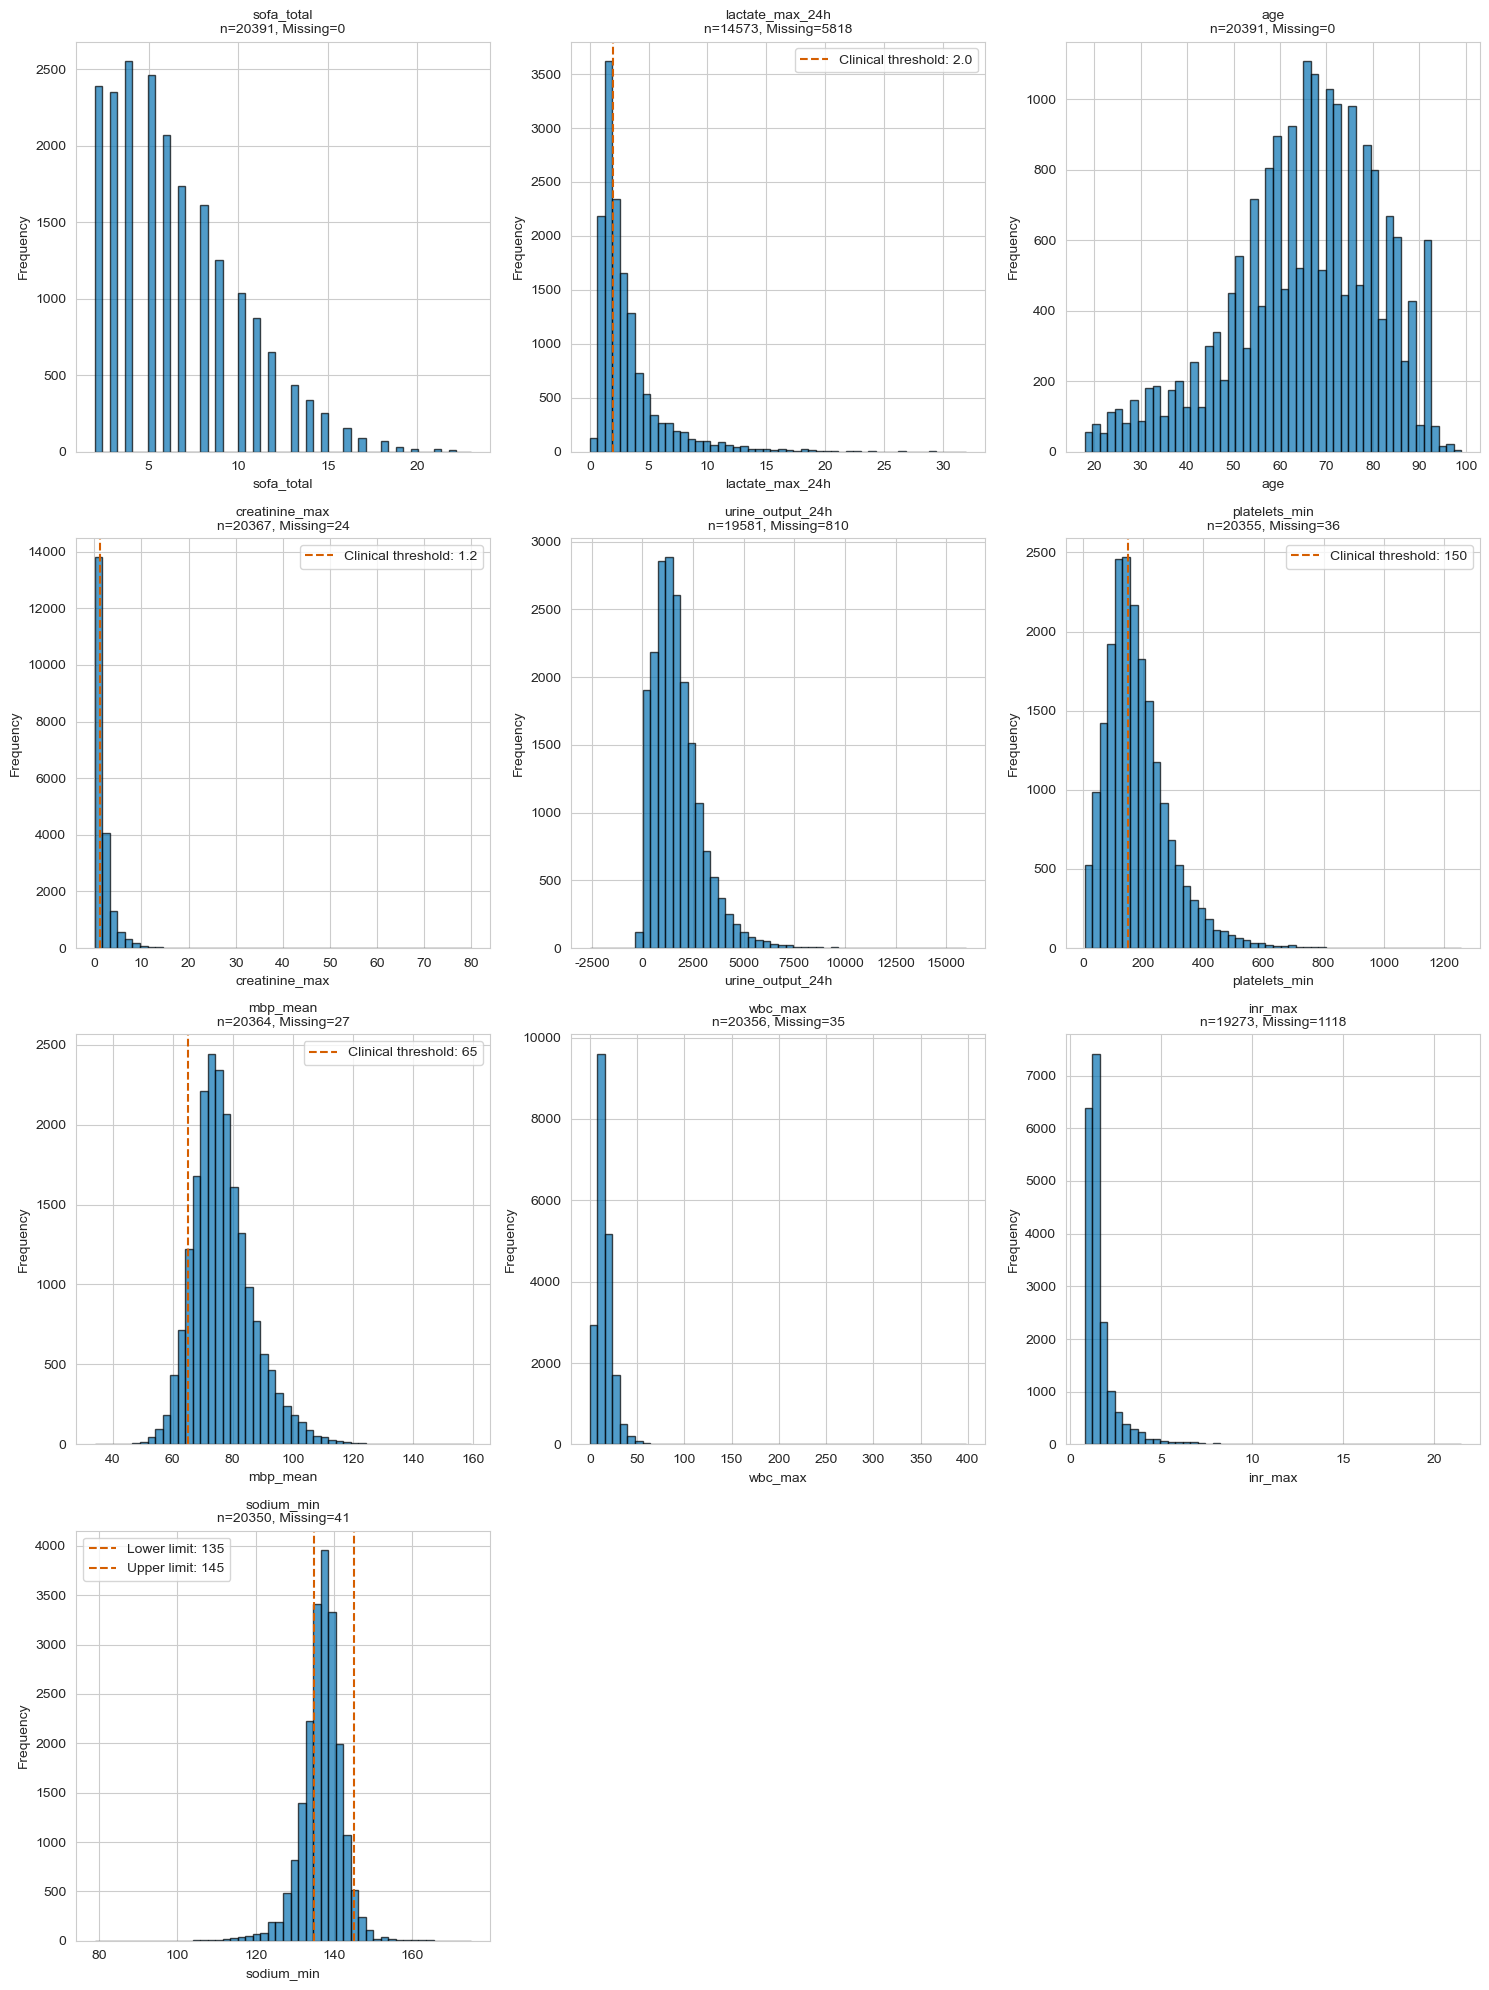


[Figure 2] Key variable distributions (with clinical thresholds) saved


In [126]:
print("\n--- B1. Overview and Skewness ---")

# Continuous variable summary statistics
# Note: charlson_comorbidity_index and sofa_total may already be in numeric_cols, need to deduplicate
continuous_vars = numeric_cols.copy()
if 'charlson_comorbidity_index' not in continuous_vars:
    continuous_vars.append('charlson_comorbidity_index')
if 'sofa_total' not in continuous_vars:
    continuous_vars.append('sofa_total')
continuous_vars = [v for v in continuous_vars if v in df_eda.columns]
# Deduplicate (prevent duplicates)
continuous_vars = list(dict.fromkeys(continuous_vars))  # Deduplication method that preserves order

summary_stats = []
for var in continuous_vars:
    data = df_eda[var].dropna()
    if len(data) > 0:
        missing_pct = df_eda[var].isna().sum() / len(df_eda) * 100
        summary_stats.append({
            'variable': var,
            'n': len(data),
            'missing_pct': missing_pct,
            'mean': data.mean(),
            'std': data.std(),
            'median': data.median(),
            'q25': data.quantile(0.25),
            'q75': data.quantile(0.75),
            'min': data.min(),
            'max': data.max(),
            'skewness': skew(data),
            'kurtosis': kurtosis(data)
        })

df_summary = pd.DataFrame(summary_stats)
df_summary.to_csv(table_dir / "Table2_ContinuousVariableSummaryStatistics.csv",index=False, encoding='utf-8-sig')
print(f"[Table 2] Continuous variable summary statistics saved")

# Display Table 2
print("\n" + "="*80)
print("Table 2: Continuous Variable Summary Statistics")
print("="*80)
display(df_summary)

# Key variable distribution plots (with clinical thresholds)
key_vars = ['sofa_total', 'lactate_max_24h', 'age', 'creatinine_max', 
            'urine_output_24h', 'platelets_min', 'mbp_mean', 'wbc_max', 
            'inr_max', 'sodium_min']

key_vars = [v for v in key_vars if v in df_eda.columns]

n_cols = 3
n_rows = (len(key_vars) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

clinical_thresholds = {
    'lactate_max_24h': 2.0,  # mmol/L
    'platelets_min': 150,  # ×10^9/L
    'sodium_min': (135, 145),  # mmol/L (range)
    'creatinine_max': 1.2,  # mg/dL (male reference value)
    'mbp_mean': 65,  # mmHg
}

for idx, var in enumerate(key_vars):
    if idx < len(axes):
        data = df_eda[var].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=50, alpha=0.7, edgecolor='black', 
                          color=COLOR_PALETTE['survived'])
            axes[idx].set_title(f'{var}\nn={len(data)}, Missing={df_eda[var].isna().sum()}', 
                              fontsize=10)
            axes[idx].set_xlabel(var)
            axes[idx].set_ylabel('Frequency')
            
            # Add clinical thresholds
            if var in clinical_thresholds:
                threshold = clinical_thresholds[var]
                if isinstance(threshold, tuple):
                    axes[idx].axvline(threshold[0], color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Lower limit: {threshold[0]}')
                    axes[idx].axvline(threshold[1], color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Upper limit: {threshold[1]}')
                    axes[idx].legend()
                else:
                    axes[idx].axvline(threshold, color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Clinical threshold: {threshold}')
                    axes[idx].legend()

# Hide extra subplots
for idx in range(len(key_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(fig_dir / "Figure2_KeyVariableDistributionsWithClinicalThresholds.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot in notebook
print(f"\n[Figure 2] Key variable distributions (with clinical thresholds) saved")

### B2. Cohort Distribution and Imbalance


--- B2. Target Distribution and Imbalance ---


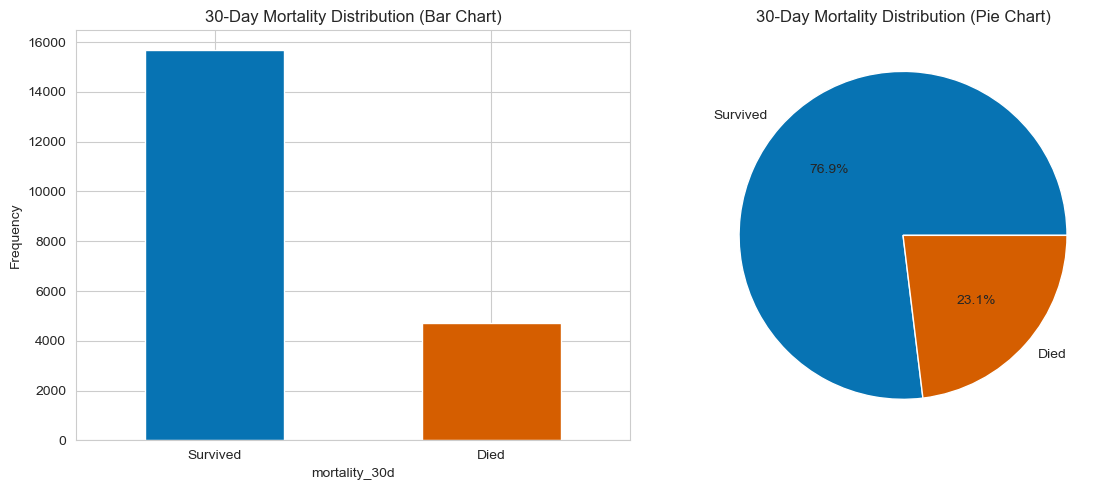


[Figure 3] 30-day outcome distribution saved
- Survived: 15688 (76.94%)
- Died: 4703 (23.06%)
- Imbalance ratio: 3.34:1


In [127]:
# B2. Target Distribution and Imbalance
print("\n--- B2. Target Distribution and Imbalance ---")

if 'mortality_30d' in df_eda.columns:
    mortality_counts = df_eda['mortality_30d'].value_counts()
    mortality_pct = df_eda['mortality_30d'].value_counts(normalize=True) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar chart
    mortality_counts.plot(kind='bar', ax=ax1, 
                         color=[COLOR_PALETTE['survived'], COLOR_PALETTE['died']])
    ax1.set_title('30-Day Mortality Distribution (Bar Chart)')
    ax1.set_xlabel('mortality_30d')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(['Survived', 'Died'], rotation=0)
    
    # Pie chart
    ax2.pie(mortality_counts.values, labels=['Survived', 'Died'], autopct='%1.1f%%', 
           colors=[COLOR_PALETTE['survived'], COLOR_PALETTE['died']])
    ax2.set_title('30-Day Mortality Distribution (Pie Chart)')
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure3_30DayOutcomeDistribution.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    
    imbalance_ratio = mortality_counts[0] / mortality_counts[1] if len(mortality_counts) > 1 else 0
    print(f"\n[Figure 3] 30-day outcome distribution saved")
    print(f"- Survived: {mortality_counts[0]} ({mortality_pct[0]:.2f}%)")
    print(f"- Died: {mortality_counts[1]} ({mortality_pct[1]:.2f}%)")
    print(f"- Imbalance ratio: {imbalance_ratio:.2f}:1")

### B3. 缺失机制与MNAR线索


--- B3. Missingness Mechanism and MNAR Clues ---
[Table 3] Missing proportion table saved

Table 3: Missing Proportion Table


variable  missing_count  missing_pct
14                 albumin_min          10768    52.807611
5              lactate_max_24h           5818    28.532196
18                     inr_max           1118     5.482811
11            urine_output_24h            810     3.972341
19                aniongap_max             65     0.318768
6                   sodium_min             41     0.201069
7                   sodium_max             41     0.201069
8                platelets_min             36     0.176548
9                platelets_max             36     0.176548
4                      wbc_max             35     0.171644
2                     sbp_mean             32     0.156932
3              heart_rate_mean             27     0.132411
1                     mbp_mean             27     0.132411
10              creatinine_max             24     0.117699
16   infection_source_category              0     0.000000
17                  sofa_total              0     0.000000
0                          age              0     0.000000
15  charlson_comorbidity_index              0     0.000000
13                 rrt_present              0     0.000000
12            pressor_used_24h              0     0.000000
20               mortality_30d              0     0.000000

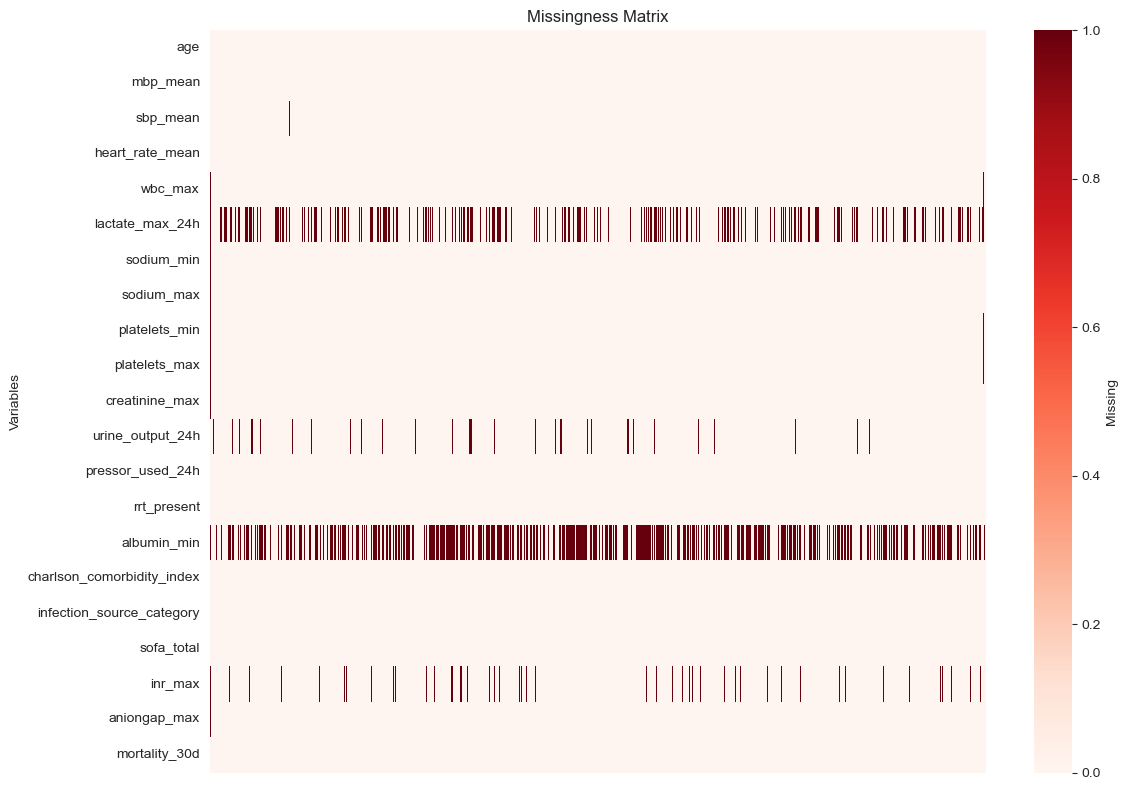


[Figure 4] Missingness matrix saved


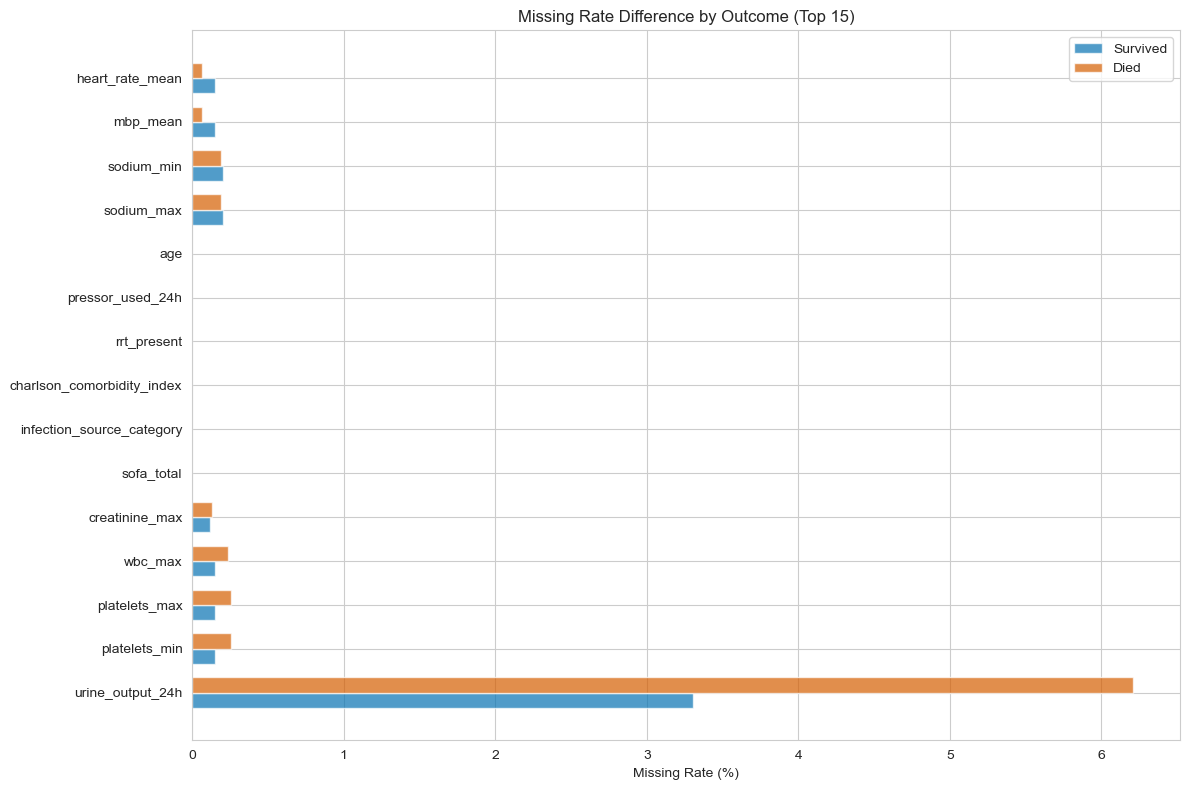


[Figure 5] Missing rate difference by outcome (bar chart) saved
[Table 4] Missing indicator and mortality OR (95% CI) saved

Table 4: Missing Indicator and Mortality OR (95% CI)


variable        OR  CI_lower  CI_upper       p_value
0  urine_output_24h  1.938660  1.673136  2.246322  5.088211e-19
1     platelets_min  1.669580  0.834302  3.341114  2.055147e-01
2     platelets_max  1.669580  0.834302  3.341114  2.055147e-01
3           wbc_max  1.530122  0.748973  3.125979  3.295907e-01
4    creatinine_max  1.112057  0.441174  2.803139  1.000000e+00

In [128]:
# B3. Missingness Mechanism and MNAR Clues
print("\n--- B3. Missingness Mechanism and MNAR Clues ---")

# Missing proportion table
missing_stats = []
for col in df_eda.columns:
    if col not in ['subject_id', 'hadm_id', 'stay_id', '_outlier_flag']:
        missing_count = df_eda[col].isna().sum()
        missing_pct = missing_count / len(df_eda) * 100
        missing_stats.append({
            'variable': col,
            'missing_count': missing_count,
            'missing_pct': missing_pct
        })

df_missing = pd.DataFrame(missing_stats).sort_values('missing_pct', ascending=False)
df_missing.to_csv(table_dir / "Table3_MissingProportionTable.csv", index=False, encoding='utf-8-sig')
print(f"[Table 3] Missing proportion table saved")

# Display Table 3
print("\n" + "="*80)
print("Table 3: Missing Proportion Table")
print("="*80)
display(df_missing)

# Missingness matrix
plt.figure(figsize=(12, 8))
missing_matrix = df_eda.drop(columns=['subject_id', 'hadm_id', 'stay_id', '_outlier_flag']).isna()
sns.heatmap(missing_matrix.T, cmap=COLOR_PALETTE['sequential_cmap'], 
           cbar_kws={'label': 'Missing'}, 
           yticklabels=True, xticklabels=False)
plt.title('Missingness Matrix')
plt.ylabel('Variables')
plt.tight_layout()
plt.savefig(fig_dir / "Figure4_MissingnessMatrix.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot in notebook
print(f"\n[Figure 4] Missingness matrix saved")

# Missing rate difference by outcome
if 'mortality_30d' in df_eda.columns:
    missing_by_outcome = []
    for col in df_eda.columns:
        if col not in ['subject_id', 'hadm_id', 'stay_id', 'mortality_30d', '_outlier_flag']:
            missing_alive = df_eda[df_eda['mortality_30d'] == 0][col].isna().mean() * 100
            missing_dead = df_eda[df_eda['mortality_30d'] == 1][col].isna().mean() * 100
            diff = missing_dead - missing_alive
            missing_by_outcome.append({
                'variable': col,
                'missing_pct_alive': missing_alive,
                'missing_pct_dead': missing_dead,
                'difference': diff
            })
    
    df_missing_diff = pd.DataFrame(missing_by_outcome).sort_values('difference', ascending=False)
    
    # Bar chart
    plt.figure(figsize=(12, 8))
    top_vars = df_missing_diff.head(15)
    x = np.arange(len(top_vars))
    width = 0.35
    plt.barh(x - width/2, top_vars['missing_pct_alive'], width, 
            label='Survived', alpha=0.7, color=COLOR_PALETTE['survived'])
    plt.barh(x + width/2, top_vars['missing_pct_dead'], width, 
            label='Died', alpha=0.7, color=COLOR_PALETTE['died'])
    plt.yticks(x, top_vars['variable'])
    plt.xlabel('Missing Rate (%)')
    plt.title('Missing Rate Difference by Outcome (Top 15)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure5_MissingRateDifferenceByOutcomeBarChart.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    print(f"\n[Figure 5] Missing rate difference by outcome (bar chart) saved")
    
    # Missing indicator and mortality OR (univariate Logit)
    missing_or_results = []
    for row in df_missing_diff.head(10).itertuples():
        var = row.variable
        if df_eda[var].dtype in ['float64', 'Int64']:
            missing_indicator = df_eda[var].isna().astype(int)
            if missing_indicator.sum() > 0 and missing_indicator.sum() < len(missing_indicator):
                try:
                    from scipy.stats import chi2_contingency
                    contingency = pd.crosstab(missing_indicator, df_eda['mortality_30d'])
                    if contingency.shape == (2, 2):
                        chi2, p, dof, expected = chi2_contingency(contingency)
                        odds_ratio = (contingency.iloc[1, 1] / contingency.iloc[1, 0]) / \
                                    (contingency.iloc[0, 1] / contingency.iloc[0, 0] + 1e-10)
                        # Simplified CI calculation
                        log_or = np.log(odds_ratio + 1e-10)
                        se = np.sqrt(1/contingency.iloc[1, 1] + 1/contingency.iloc[1, 0] + 
                                    1/contingency.iloc[0, 1] + 1/contingency.iloc[0, 0] + 1e-10)
                        ci_lower = np.exp(log_or - 1.96 * se)
                        ci_upper = np.exp(log_or + 1.96 * se)
                        missing_or_results.append({
                            'variable': var,
                            'OR': odds_ratio,
                            'CI_lower': ci_lower,
                            'CI_upper': ci_upper,
                            'p_value': p
                        })
                except:
                    pass
    
    if missing_or_results:
        df_missing_or = pd.DataFrame(missing_or_results)
        df_missing_or.to_csv(table_dir / "Table4_MissingIndicatorAndMortalityOR.csv", index=False, encoding='utf-8-sig')
        print(f"[Table 4] Missing indicator and mortality OR (95% CI) saved")
        
        # Display Table 4
        print("\n" + "="*80)
        print("Table 4: Missing Indicator and Mortality OR (95% CI)")
        print("="*80)
        display(df_missing_or)

### B4. Missingness Mechanisms and MNAR Indicators


--- B4. Correlation Structure and Collinearity ---


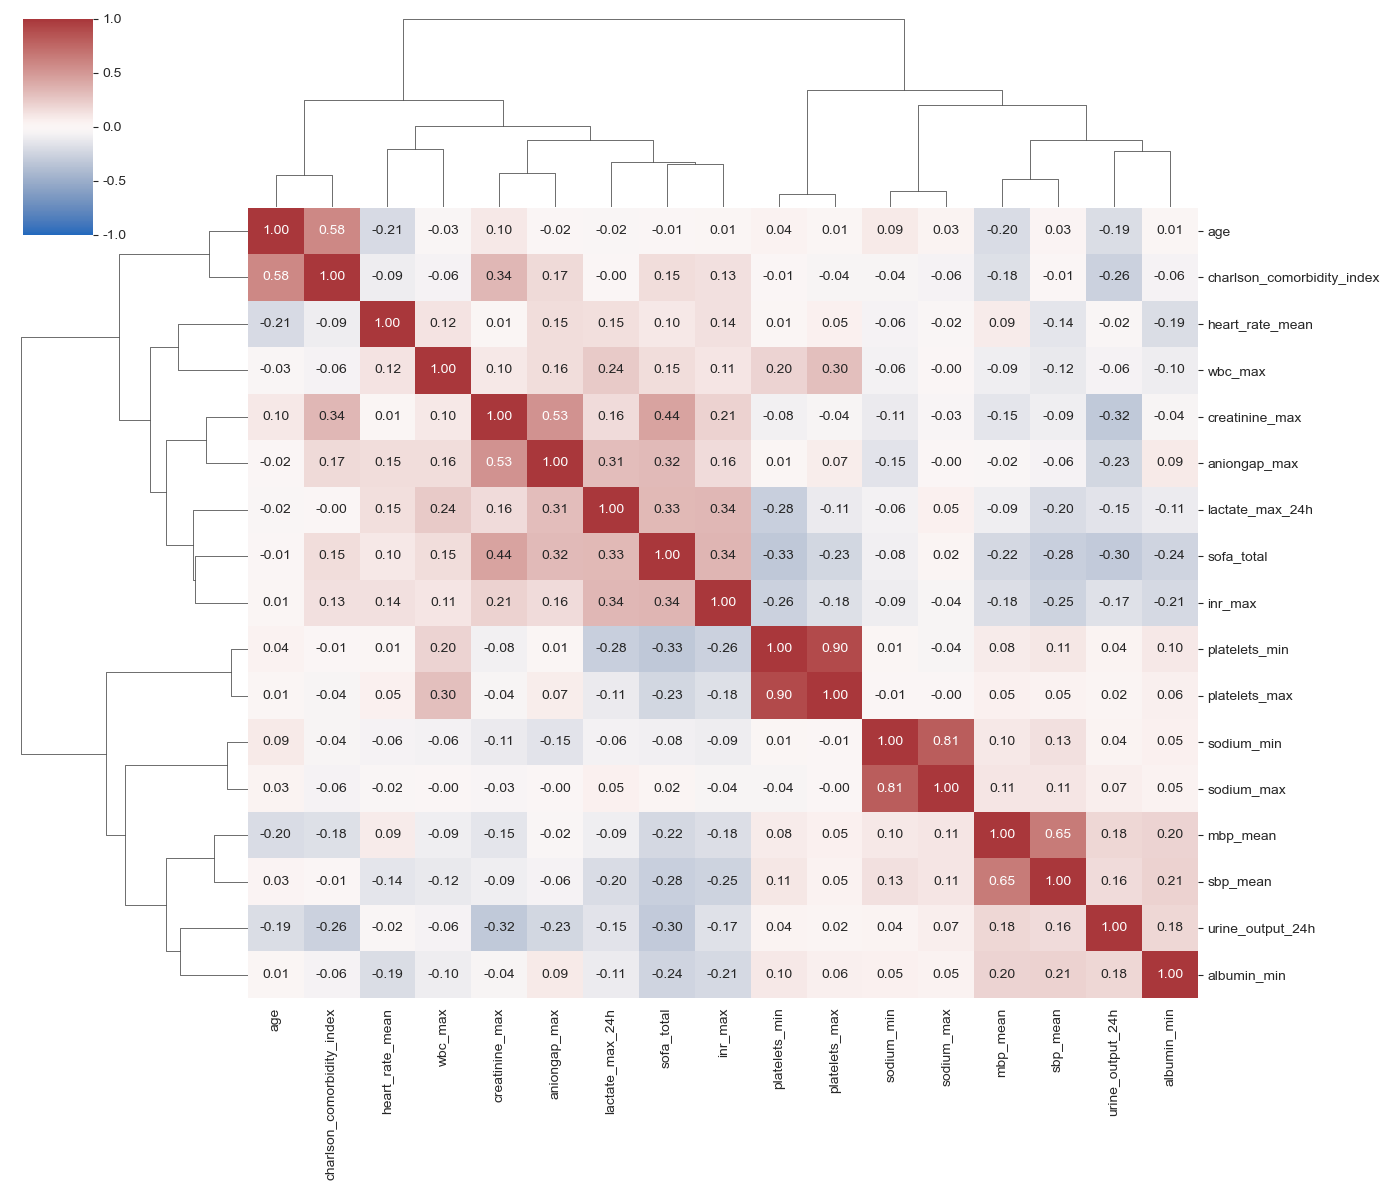


[Figure 6] Hierarchical clustering correlation plot (Spearman) saved
[Table 5] High correlation pairs list (|r|>0.7) saved

Table 5: High Correlation Pairs List (|r|>0.7)


variable1      variable2  correlation
0     sodium_min     sodium_max     0.806278
1  platelets_min  platelets_max     0.899458


[Table 6] VIF ranking saved

Table 6: VIF Ranking


variable          VIF
7                   sodium_max  1741.407090
6                   sodium_min  1609.423737
1                     mbp_mean   131.749212
2                     sbp_mean   128.545271
3              heart_rate_mean    29.928279
0                          age    28.651153
9                platelets_max    24.310740
8                platelets_min    21.916520
12                 albumin_min    21.246568
16                aniongap_max    21.125220
14                  sofa_total     8.985889
13  charlson_comorbidity_index     6.989813
5              lactate_max_24h     4.153840
11            urine_output_24h     3.052169
10              creatinine_max     2.943680
15                     inr_max     2.921098
4                      wbc_max     2.898473

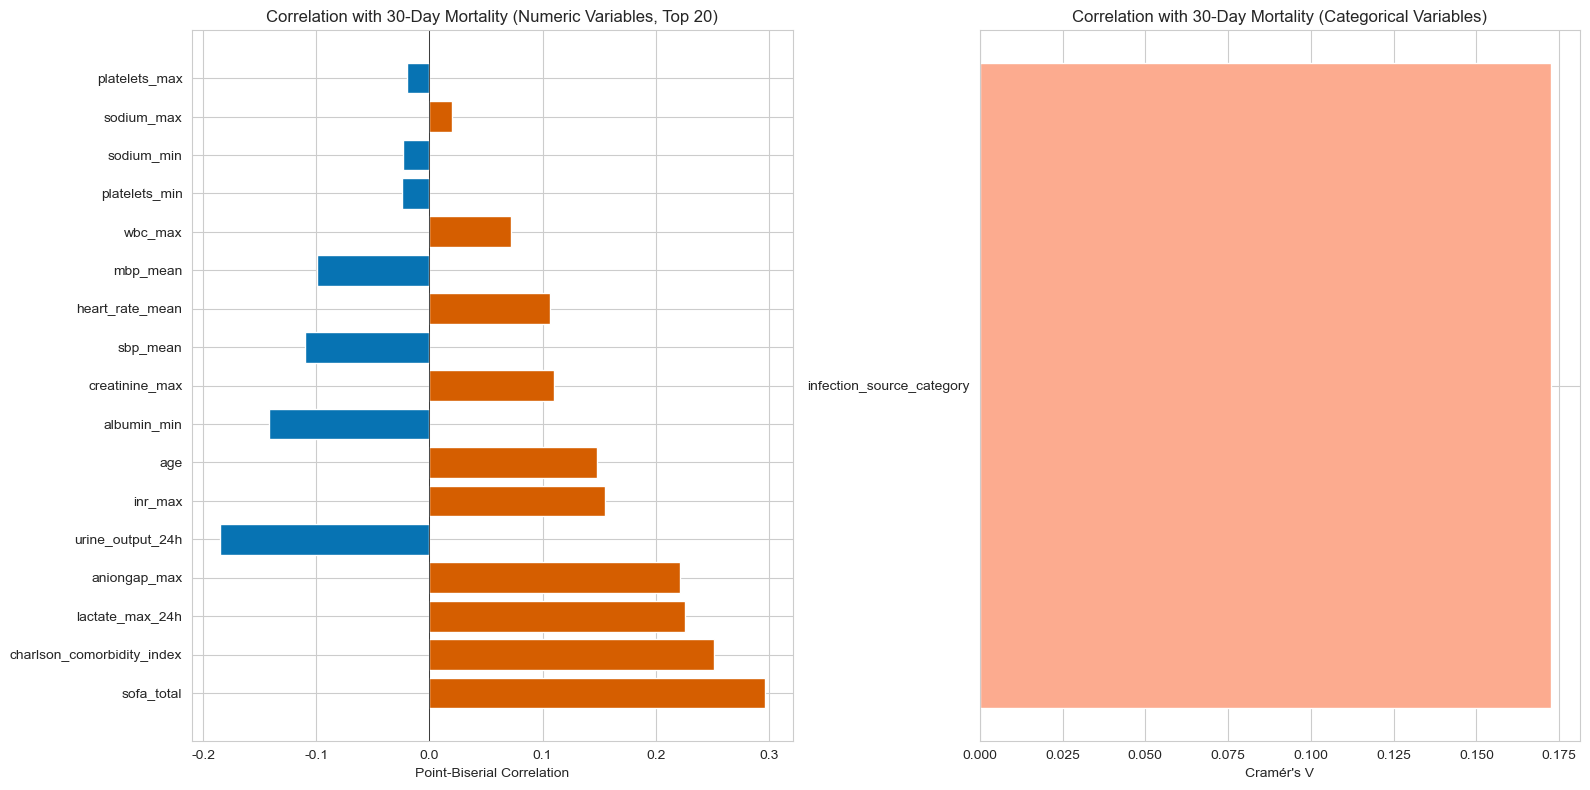


[Figure 7] Top correlations with 30-day mortality saved


In [129]:
# B4. Correlation Structure and Collinearity
print("\n--- B4. Correlation Structure and Collinearity ---")

# Spearman correlation + hierarchical clustering
numeric_for_corr = [v for v in continuous_vars if v in df_eda.columns]
df_corr = df_eda[numeric_for_corr].select_dtypes(include=[np.number])

# Calculate Spearman correlation
corr_matrix = df_corr.corr(method='spearman')

# Clustermap
clustergrid = sns.clustermap(corr_matrix, method='ward', cmap=COLOR_PALETTE['diverging_cmap'], center=0,
              annot=True, fmt='.2f', vmin=-1, vmax=1, figsize=(14, 12))
plt.savefig(fig_dir / "Figure6_HierarchicalClusteringCorrelationPlotSpearman.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot in notebook
print(f"\n[Figure 6] Hierarchical clustering correlation plot (Spearman) saved")

# High correlation pairs list (|r|>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append({
                'variable1': var1,
                'variable2': var2,
                'correlation': corr_val
            })

df_high_corr = pd.DataFrame(high_corr_pairs)
if len(df_high_corr) > 0:
    df_high_corr.to_csv(table_dir / "Table5_HighCorrelationPairsList.csv", index=False, encoding='utf-8-sig')
    print(f"[Table 5] High correlation pairs list (|r|>0.7) saved")
    
    # Display Table 5
    print("\n" + "="*80)
    print("Table 5: High Correlation Pairs List (|r|>0.7)")
    print("="*80)
    display(df_high_corr)

# VIF ranking (only for variables with sufficient non-missing values)
vif_data = df_corr.dropna()
if len(vif_data) > 0 and len(vif_data) > len(vif_data.columns):
    vif_results = []
    for i, col in enumerate(vif_data.columns):
        try:
            vif_value = variance_inflation_factor(vif_data.values, i)
            vif_results.append({
                'variable': col,
                'VIF': vif_value
            })
        except:
            pass
    
    if vif_results:
        df_vif = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)
        df_vif.to_csv(table_dir / "Table6_VIFRanking.csv", index=False, encoding='utf-8-sig')
        print(f"\n[Table 6] VIF ranking saved")
        
        # Display Table 6
        print("\n" + "="*80)
        print("Table 6: VIF Ranking")
        print("="*80)
        display(df_vif)

# Top correlations with 30-day mortality
if 'mortality_30d' in df_eda.columns:
    correlations_with_target = []
    
    # Numeric variables: point-biserial correlation
    for var in numeric_for_corr:
        if var != 'mortality_30d':
            data_subset = df_eda[[var, 'mortality_30d']].dropna()
            if len(data_subset) > 10:
                try:
                    corr, p_val = stats.pointbiserialr(data_subset['mortality_30d'], data_subset[var])
                    correlations_with_target.append({
                        'variable': var,
                        'type': 'numeric',
                        'correlation': corr,
                        'p_value': p_val,
                        'abs_corr': abs(corr)
                    })
                except:
                    pass
    
    # Categorical variables: Cramér's V
    for var in categorical_cols:
        if var in df_eda.columns:
            try:
                from scipy.stats import chi2_contingency
                contingency = pd.crosstab(df_eda[var], df_eda['mortality_30d'])
                chi2, p_val, dof, expected = chi2_contingency(contingency)
                n = contingency.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                correlations_with_target.append({
                    'variable': var,
                    'type': 'categorical',
                    'correlation': cramers_v,
                    'p_value': p_val,
                    'abs_corr': cramers_v
                })
            except:
                pass
    
    if correlations_with_target:
        df_corr_target = pd.DataFrame(correlations_with_target).sort_values('abs_corr', ascending=False)
        
        # FDR correction
        from statsmodels.stats.multitest import multipletests
        if len(df_corr_target) > 0:
            _, p_adj, _, _ = multipletests(df_corr_target['p_value'], method='fdr_bh')
            df_corr_target['p_adj'] = p_adj
        
        # Plot numeric and categorical separately
        numeric_corr = df_corr_target[df_corr_target['type'] == 'numeric'].head(20)
        categorical_corr = df_corr_target[df_corr_target['type'] == 'categorical']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Numeric variables
        if len(numeric_corr) > 0:
            colors_numeric = [COLOR_PALETTE['died'] if x > 0 else COLOR_PALETTE['survived'] 
                             for x in numeric_corr['correlation'].values]
            ax1.barh(range(len(numeric_corr)), numeric_corr['correlation'].values, 
                    color=colors_numeric)
            ax1.set_yticks(range(len(numeric_corr)))
            ax1.set_yticklabels(numeric_corr['variable'].values)
            ax1.set_xlabel('Point-Biserial Correlation')
            ax1.set_title('Correlation with 30-Day Mortality (Numeric Variables, Top 20)')
            ax1.axvline(0, color='black', linestyle='-', linewidth=0.5)
        
        # Categorical variables
        if len(categorical_corr) > 0:
            colors_cat = plt.cm.get_cmap(COLOR_PALETTE['sequential_cmap'])(
                np.linspace(0.3, 0.9, len(categorical_corr)))
            ax2.barh(range(len(categorical_corr)), categorical_corr['correlation'].values,
                    color=colors_cat)
            ax2.set_yticks(range(len(categorical_corr)))
            ax2.set_yticklabels(categorical_corr['variable'].values)
            ax2.set_xlabel("Cramér's V")
            ax2.set_title('Correlation with 30-Day Mortality (Categorical Variables)')
        
        plt.tight_layout()
        plt.savefig(fig_dir / "Figure7_TopCorrelationsWith30DayMortality.png", dpi=300, bbox_inches='tight')
        plt.show()  # Display the plot in notebook
        print(f"\n[Figure 7] Top correlations with 30-day mortality saved")

### B5. Group Differences (Survived vs Died)


--- B5. Group Differences (Survived vs. Died) ---


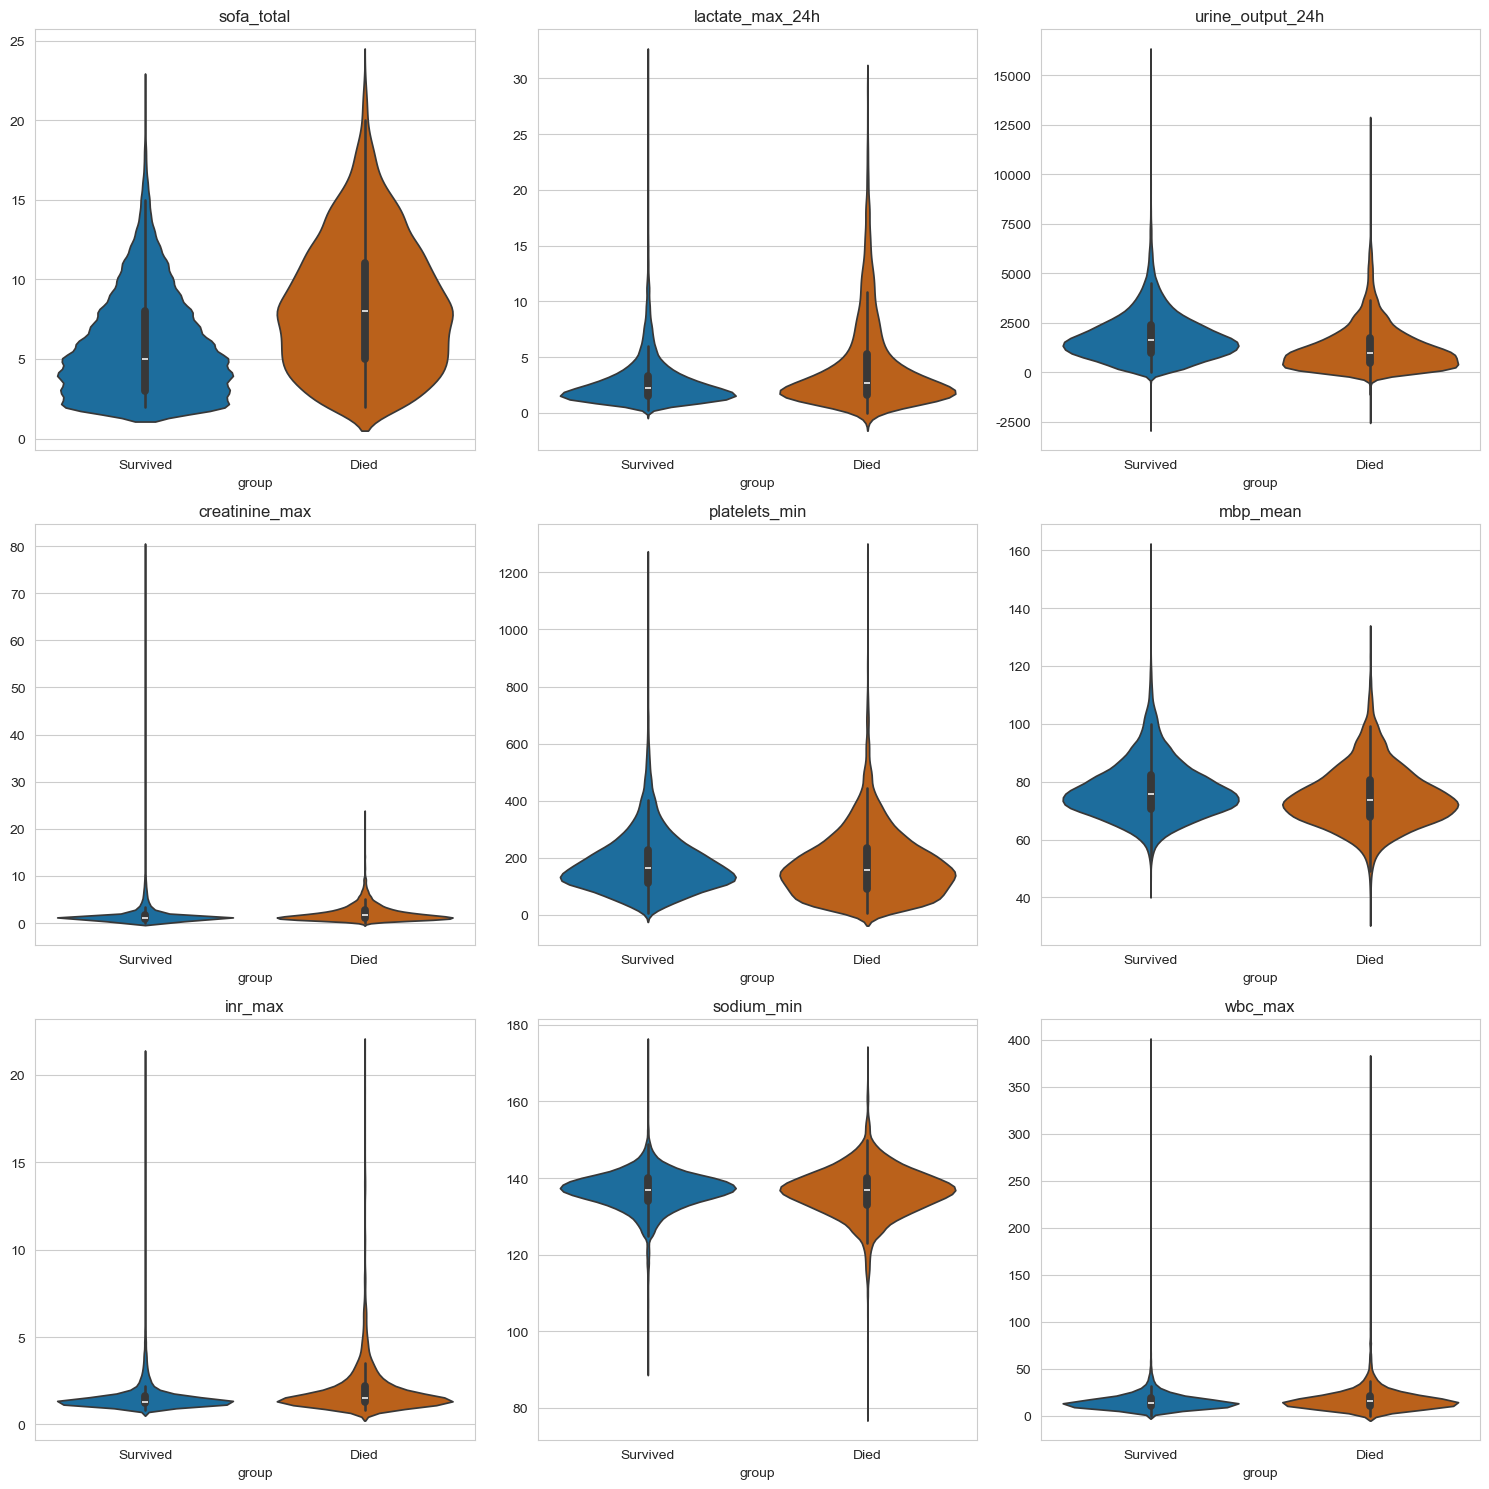


[Figure 8] Group differences panel plot saved
[Table 7] Group comparison (effect size + q-value) saved

Table 7: Group Comparison (Effect Size + Q-value)


variable   alive_mean    dead_mean  cohens_d        p_value  \
0        sofa_total     5.874745     8.405486  0.690046   0.000000e+00   
1   lactate_max_24h     2.810344     4.311517  0.453663   1.259921e-70   
2  urine_output_24h  1814.106823  1263.591363 -0.455792  1.409949e-240   
3    creatinine_max     1.691034     2.179519  0.268234  9.550137e-169   
4     platelets_min   181.583504   175.338521 -0.056012   9.866938e-10   
5          mbp_mean    77.220428    74.846681 -0.233700   9.418240e-50   
6           inr_max     1.609063     2.044316  0.328658  1.115568e-130   
7        sodium_min   136.808636   136.509374 -0.052788   2.592858e-04   
8           wbc_max    15.464205    17.512681  0.160115   1.044533e-25   

         q_value  
0   0.000000e+00  
1   2.267858e-70  
2  6.344769e-240  
3  2.865041e-168  
4   1.110031e-09  
5   1.412736e-49  
6  2.510028e-130  
7   2.592858e-04  
8   1.342971e-25

In [130]:
# B5. Group Differences (Survived vs. Died)
print("\n--- B5. Group Differences (Survived vs. Died) ---")

if 'mortality_30d' in df_eda.columns:
    key_vars_for_comparison = ['sofa_total', 'lactate_max_24h', 'urine_output_24h', 
                              'creatinine_max', 'platelets_min', 'mbp_mean', 
                              'inr_max', 'sodium_min', 'wbc_max']
    key_vars_for_comparison = [v for v in key_vars_for_comparison if v in df_eda.columns]
    
    n_cols = 3
    n_rows = (len(key_vars_for_comparison) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    comparison_results = []
    
    for idx, var in enumerate(key_vars_for_comparison):
        if idx < len(axes):
            data_alive = df_eda[df_eda['mortality_30d'] == 0][var].dropna()
            data_dead = df_eda[df_eda['mortality_30d'] == 1][var].dropna()
            
            if len(data_alive) > 0 and len(data_dead) > 0:
                # Violin plot
                data_to_plot = pd.DataFrame({
                    'value': pd.concat([data_alive, data_dead]),
                    'group': ['Survived'] * len(data_alive) + ['Died'] * len(data_dead)
                })
                sns.violinplot(data=data_to_plot, x='group', y='value', ax=axes[idx],
                             palette=[COLOR_PALETTE['survived'], COLOR_PALETTE['died']])
                axes[idx].set_title(var)
                axes[idx].set_ylabel('')
                
                # Mann-Whitney U test
                try:
                    u_stat, p_val = stats.mannwhitneyu(data_alive, data_dead, alternative='two-sided')
                    # Effect size (simplified Cohen's d)
                    pooled_std = np.sqrt((data_alive.std()**2 + data_dead.std()**2) / 2)
                    cohens_d = (data_dead.mean() - data_alive.mean()) / (pooled_std + 1e-10)
                    comparison_results.append({
                        'variable': var,
                        'alive_mean': data_alive.mean(),
                        'dead_mean': data_dead.mean(),
                        'cohens_d': cohens_d,
                        'p_value': p_val
                    })
                except:
                    pass
    
    # Hide extra subplots
    for idx in range(len(key_vars_for_comparison), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure8_GroupDifferencesPanelPlot.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    print(f"\n[Figure 8] Group differences panel plot saved")
    
    # FDR correction
    if comparison_results:
        df_comparison = pd.DataFrame(comparison_results)
        from statsmodels.stats.multitest import multipletests
        _, p_adj, _, _ = multipletests(df_comparison['p_value'], method='fdr_bh')
        df_comparison['q_value'] = p_adj
        df_comparison.to_csv(table_dir / "Table7_GroupComparisonEffectSizeQValue.csv", index=False)
        print(f"[Table 7] Group comparison (effect size + q-value) saved")
        
        # Display Table 7
        print("\n" + "="*80)
        print("Table 7: Group Comparison (Effect Size + Q-value)")
        print("="*80)
        display(df_comparison)

### B6. Top Univariate Predictors & Nonlinear/Interaction Effects


--- B6. Univariate Strong Signals & Nonlinearity/Interactions ---
[Table 8] Univariate OR (IQR) and AUC/PR-AUC saved

Table 8: Univariate OR (IQR) and AUC/PR-AUC


variable    OR_IQR  CI_lower  CI_upper       AUC  \
14                  sofa_total  2.551056  2.469272  2.635548  0.686219   
13  charlson_comorbidity_index  2.239370  2.167579  2.313540  0.667561   
11            urine_output_24h  0.506517  0.489816  0.523788  0.663568   
16                aniongap_max  1.719374  1.664190  1.776387  0.645606   
10              creatinine_max  1.168828  1.131333  1.207564  0.632779   
15                     inr_max  1.147115  1.109424  1.186086  0.619090   
0                          age  1.656865  1.603748  1.711741  0.602098   
5              lactate_max_24h  1.429116  1.376498  1.483746  0.598141   
12                 albumin_min  0.637995  0.610729  0.666479  0.590035   
2                     sbp_mean  0.706158  0.683507  0.729559  0.581582   
1                     mbp_mean  0.740894  0.717132  0.765443  0.571201   
3              heart_rate_mean  1.402058  1.357091  1.448515  0.570192   
4                      wbc_max  1.129600  1.093348  1.167054  0.550359   
8                platelets_min  0.935635  0.905605  0.966660  0.529364   
9                platelets_max  0.949297  0.918829  0.980776  0.525649   
6                   sodium_min  0.938756  0.908632  0.969879  0.517505   
7                   sodium_max  1.055946  1.022061  1.090954  0.506828   

      PR_AUC  
14  0.401487  
13  0.355982  
11  0.378531  
16  0.350231  
10  0.309122  
15  0.333936  
0   0.305168  
5   0.386822  
12  0.377049  
2   0.316420  
1   0.303476  
3   0.289499  
4   0.278949  
8   0.288388  
9   0.285565  
6   0.262741  
7   0.270032

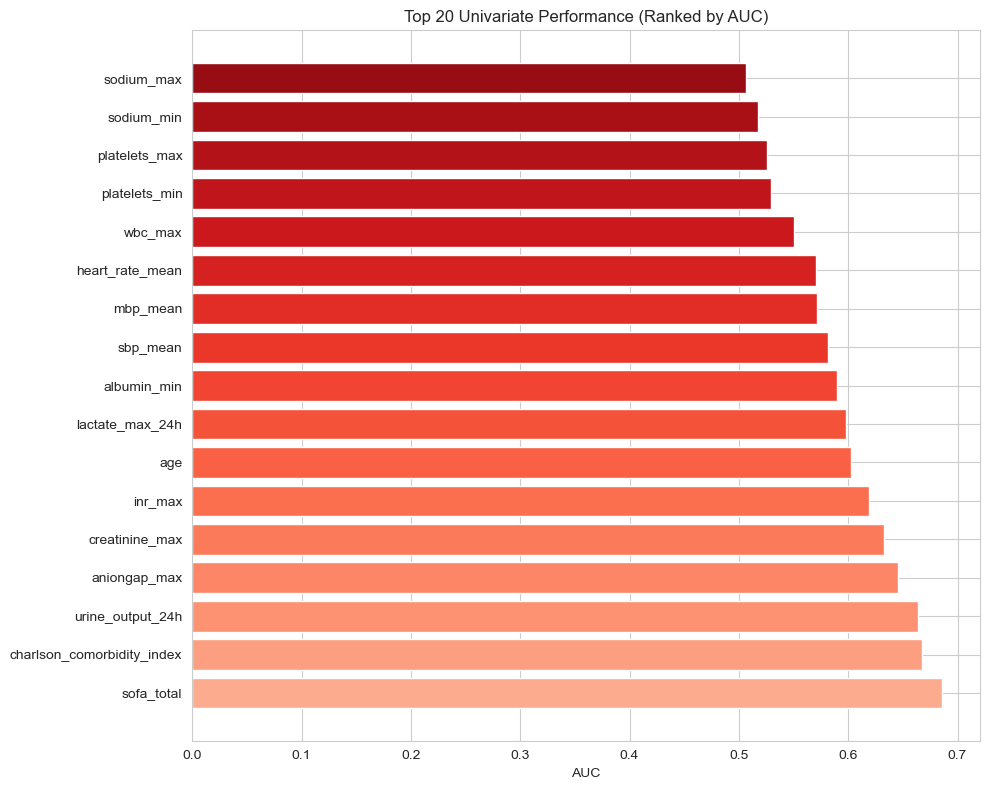


[Figure 9] Top 20 univariate performance (ranked by AUC) saved

Generating quantile-mortality curves...


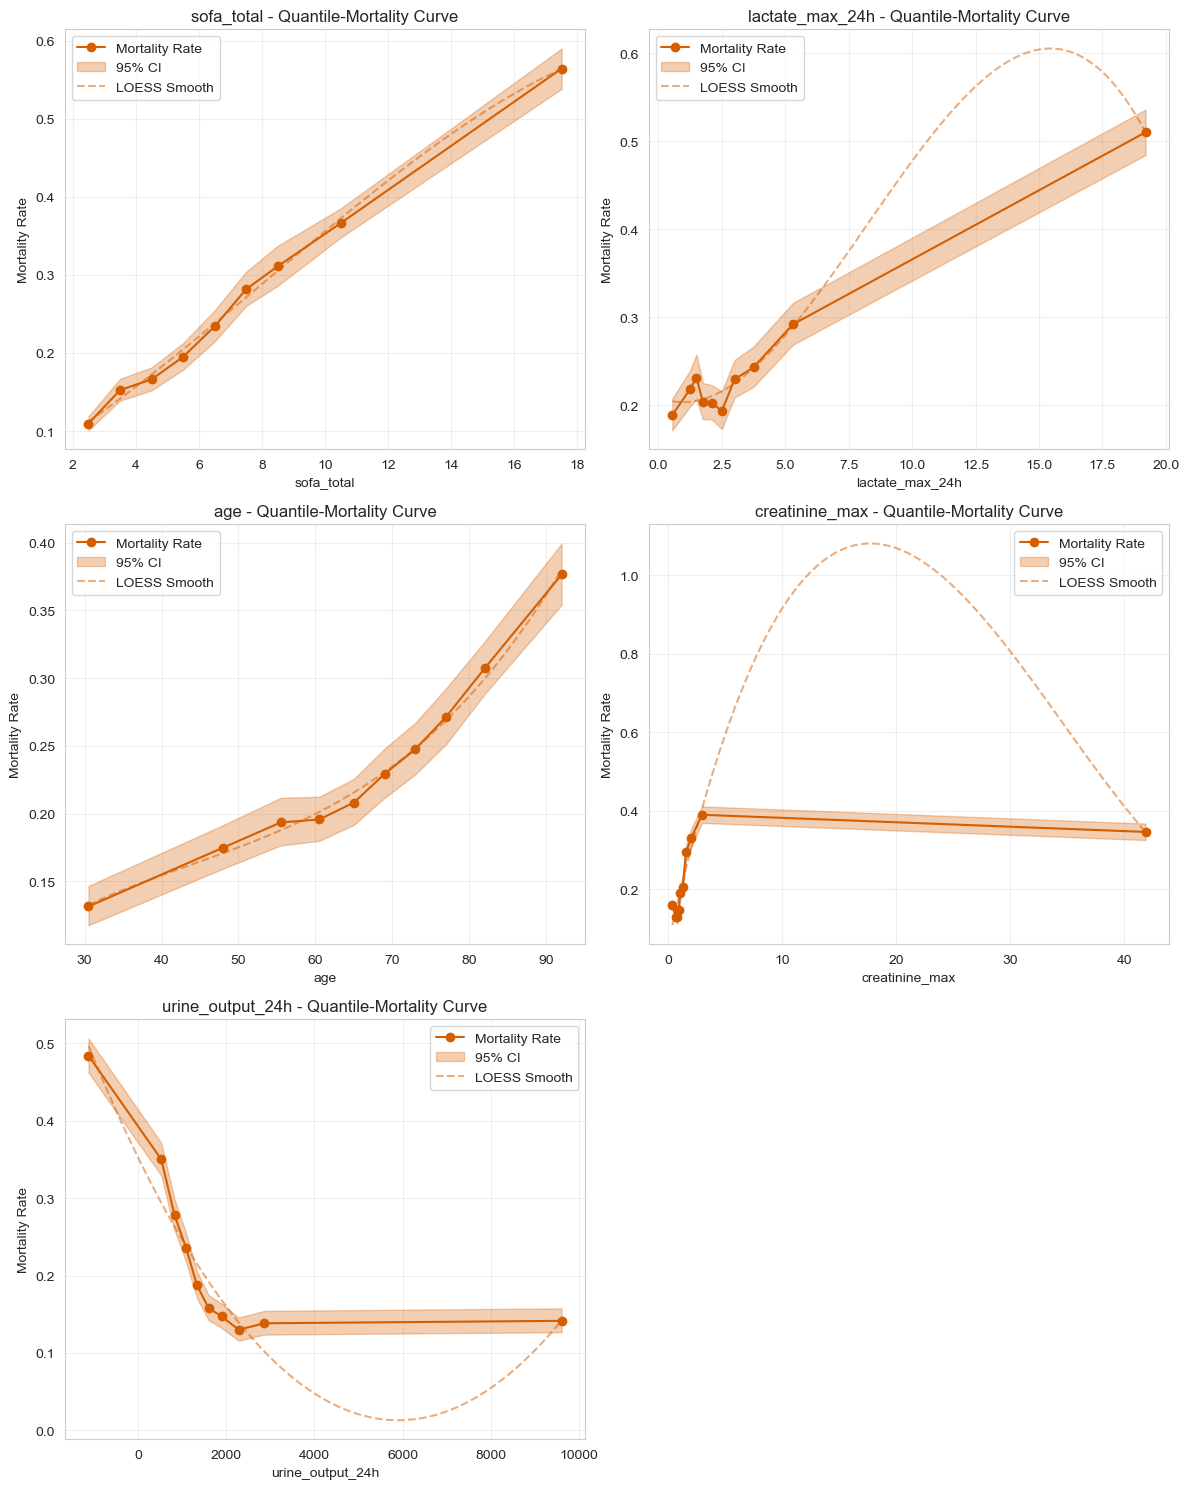


[Figure 10] Quantile-mortality curves (multi-panel) saved

Generating two-dimensional risk heatmap...


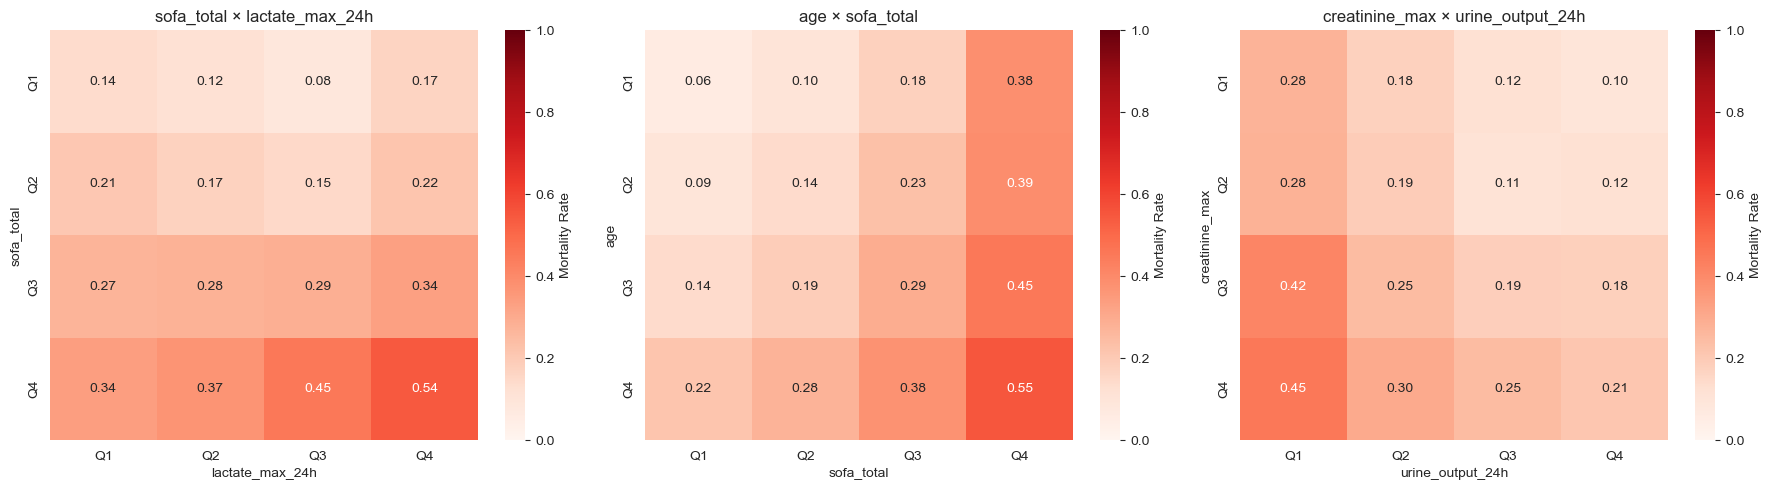


[Figure 11] Two-dimensional risk heatmap saved


In [131]:
# B6. Univariate Strong Signals & Nonlinearity/Interactions
print("\n--- B6. Univariate Strong Signals & Nonlinearity/Interactions ---")

if 'mortality_30d' in df_eda.columns:
    # Univariate Logit (IQR normalization)
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    univariate_results = []
    
    for var in numeric_for_corr:
        if var != 'mortality_30d':
            data_subset = df_eda[[var, 'mortality_30d']].dropna()
            if len(data_subset) > 50:
                X = data_subset[[var]].values
                y = data_subset['mortality_30d'].values
                
                # IQR normalization
                q25, q75 = np.percentile(X, [25, 75])
                iqr = q75 - q25
                if iqr > 0:
                    X_iqr = (X - q25) / iqr
                    
                    try:
                        lr = LogisticRegression(max_iter=1000)
                        lr.fit(X_iqr, y)
                        
                        # OR (IQR)
                        or_iqr = np.exp(lr.coef_[0][0])
                        # Simplified CI
                        se = np.sqrt(1/np.sum((y == 1)) + 1/np.sum((y == 0)) + 1e-10)
                        ci_lower = np.exp(np.log(or_iqr) - 1.96 * se)
                        ci_upper = np.exp(np.log(or_iqr) + 1.96 * se)
                        
                        # AUC
                        y_pred_proba = lr.predict_proba(X_iqr)[:, 1]
                        auc = roc_auc_score(y, y_pred_proba)
                        pr_auc = average_precision_score(y, y_pred_proba)
                        
                        univariate_results.append({
                            'variable': var,
                            'OR_IQR': or_iqr,
                            'CI_lower': ci_lower,
                            'CI_upper': ci_upper,
                            'AUC': auc,
                            'PR_AUC': pr_auc
                        })
                    except:
                        pass
    
    if univariate_results:
        df_univariate = pd.DataFrame(univariate_results).sort_values('AUC', ascending=False)
        df_univariate.to_csv(table_dir / "Table8_UnivariateORAndAUC.csv", index=False, encoding='utf-8-sig')
        print(f"[Table 8] Univariate OR (IQR) and AUC/PR-AUC saved")
        
        # Display Table 8
        print("\n" + "="*80)
        print("Table 8: Univariate OR (IQR) and AUC/PR-AUC")
        print("="*80)
        display(df_univariate)
        
        # Top 20 univariate performance plot
        top20 = df_univariate.head(20)
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top20)), top20['AUC'].values, 
                color=plt.cm.get_cmap(COLOR_PALETTE['sequential_cmap'])(
                    np.linspace(0.3, 0.9, len(top20))))
        plt.yticks(range(len(top20)), top20['variable'].values)
        plt.xlabel('AUC')
        plt.title('Top 20 Univariate Performance (Ranked by AUC)')
        plt.tight_layout()
        plt.savefig(fig_dir / "Figure9_Top20UnivariatePerformanceRankedByAUC.png", dpi=300, bbox_inches='tight')
        plt.show()  # Display the plot in notebook
        print(f"\n[Figure 9] Top 20 univariate performance (ranked by AUC) saved")

# Quantile-mortality curves
print("\nGenerating quantile-mortality curves...")
key_vars_for_quantile = ['sofa_total', 'lactate_max_24h', 'age', 'creatinine_max', 'urine_output_24h']
key_vars_for_quantile = [v for v in key_vars_for_quantile if v in df_eda.columns and v != 'mortality_30d']

if 'mortality_30d' in df_eda.columns and len(key_vars_for_quantile) > 0:
    n_cols = 2
    n_rows = (len(key_vars_for_quantile) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, var in enumerate(key_vars_for_quantile):
        if idx < len(axes):
            data_subset = df_eda[[var, 'mortality_30d']].dropna()
            if len(data_subset) > 10:
                # 10 quantiles
                data_subset['quantile'] = pd.qcut(data_subset[var], q=10, duplicates='drop')
                quantile_mortality = data_subset.groupby('quantile').agg({
                    'mortality_30d': ['mean', 'count']
                })
                
                quantile_mortality.columns = ['mortality_rate', 'n']
                quantile_mortality = quantile_mortality.reset_index()
                quantile_mortality['quantile_center'] = quantile_mortality['quantile'].apply(lambda x: x.mid)
                
                # Wilson 95% CI
                from statsmodels.stats.proportion import proportion_confint
                ci_lower_list = []
                ci_upper_list = []
                for _, row in quantile_mortality.iterrows():
                    n = int(row['n'])
                    k = int(row['mortality_rate'] * n)
                    if n > 0:
                        ci_lower, ci_upper = proportion_confint(k, n, alpha=0.05, method='wilson')
                        ci_lower_list.append(ci_lower)
                        ci_upper_list.append(ci_upper)
                    else:
                        ci_lower_list.append(0)
                        ci_upper_list.append(0)
                
                quantile_mortality['ci_lower'] = ci_lower_list
                quantile_mortality['ci_upper'] = ci_upper_list
                
                # Plot
                axes[idx].plot(quantile_mortality['quantile_center'], quantile_mortality['mortality_rate'], 
                              'o-', label='Mortality Rate', color=COLOR_PALETTE['died'])
                axes[idx].fill_between(quantile_mortality['quantile_center'], 
                                      quantile_mortality['ci_lower'], quantile_mortality['ci_upper'],
                                      alpha=0.3, label='95% CI', color=COLOR_PALETTE['died'])
                
                # LOESS smoothing (simplified)
                try:
                    from scipy.interpolate import UnivariateSpline
                    spl = UnivariateSpline(quantile_mortality['quantile_center'], 
                                         quantile_mortality['mortality_rate'], s=len(quantile_mortality)*2)
                    x_smooth = np.linspace(quantile_mortality['quantile_center'].min(),
                                         quantile_mortality['quantile_center'].max(), 100)
                    axes[idx].plot(x_smooth, spl(x_smooth), '--', alpha=0.5, label='LOESS Smooth', 
                                  color=COLOR_PALETTE['died'])
                except:
                    pass
                
                axes[idx].set_xlabel(var)
                axes[idx].set_ylabel('Mortality Rate')
                axes[idx].set_title(f'{var} - Quantile-Mortality Curve')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(key_vars_for_quantile), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure10_QuantileMortalityCurvesMultiPanel.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    print(f"\n[Figure 10] Quantile-mortality curves (multi-panel) saved")

# Two-dimensional risk heatmap
print("\nGenerating two-dimensional risk heatmap...")
if 'mortality_30d' in df_eda.columns:
    heatmap_pairs = [
        ('sofa_total', 'lactate_max_24h'),
        ('age', 'sofa_total'),
        ('creatinine_max', 'urine_output_24h')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (var1, var2) in enumerate(heatmap_pairs):
        if var1 in df_eda.columns and var2 in df_eda.columns:
            data_subset = df_eda[[var1, var2, 'mortality_30d']].dropna()
            if len(data_subset) > 10:
                # Quartiles
                data_subset['q1'] = pd.qcut(data_subset[var1], q=4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])
                data_subset['q2'] = pd.qcut(data_subset[var2], q=4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])
                
                heatmap_data = data_subset.groupby(['q1', 'q2']).agg({
                    'mortality_30d': ['mean', 'count']
                }).reset_index()
                heatmap_data.columns = ['q1', 'q2', 'mortality_rate', 'n']
                
                # Build heatmap matrix
                heatmap_matrix = heatmap_data.pivot(index='q1', columns='q2', values='mortality_rate')
                count_matrix = heatmap_data.pivot(index='q1', columns='q2', values='n')
                
                # Ensure data type is float and fill NaN
                heatmap_matrix = heatmap_matrix.astype(float)
                heatmap_matrix = heatmap_matrix.fillna(0)
                
                # Draw heatmap
                sns.heatmap(heatmap_matrix, annot=True, fmt='.2f', cmap=COLOR_PALETTE['sequential_cmap'], 
                           ax=axes[idx], cbar_kws={'label': 'Mortality Rate'}, vmin=0, vmax=1)
                axes[idx].set_title(f'{var1} × {var2}')
                axes[idx].set_xlabel(var2)
                axes[idx].set_ylabel(var1)
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure11_TwoDimensionalRiskHeatmap.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    print(f"\n[Figure 11] Two-dimensional risk heatmap saved")

## Step 2: Proper Data Cleaning (Data Processing & Feature Eng.)

### C0. Feature Removal (Collinearity Handling)

In [132]:
# Create processed data frame
df_processed = df_eda.copy()

# C0. Feature Deletion (Handle Collinearity)
print("\n--- C0. Feature Deletion (Handle Collinearity) ---")
# Delete highly collinear features: platelets_max and sodium_max, keep only corresponding min features
features_to_drop = ['platelets_max', 'sodium_max']
for feat in features_to_drop:
    if feat in df_processed.columns:
        df_processed = df_processed.drop(columns=[feat])
        print(f"  - Deleted feature: {feat} (collinearity handling)")

# Also remove these features from numeric_cols list
numeric_cols = [col for col in numeric_cols if col not in features_to_drop]
print(f"  - Remaining numeric features: {len(numeric_cols)}")


--- C0. Feature Deletion (Handle Collinearity) ---
  - Deleted feature: platelets_max (collinearity handling)
  - Deleted feature: sodium_max (collinearity handling)
  - Remaining numeric features: 15


### C1. Clinical Capping and Negative Value Handling

In [133]:
# C1. Clinical Capping and Negative Value Handling
print("\n--- C1. Clinical Capping and Negative Value Handling ---")

capping_log = []

# Clinical capping thresholds (based on clinical experience and percentiles)
# Note: lactate_max_24h is no longer capped, preserving high values as key risk signals
clinical_caps = {
    'inr_max': 10.0,
    'creatinine_max': 10.0,  # mg/dL
    'aniongap_max': 30.0,
    'wbc_max': 50.0,  # ×10^9/L
    'heart_rate_mean': 200,  # bpm
    'sbp_mean': 250,  # mmHg
    'mbp_mean': 150,  # mmHg
}

for var, cap_value in clinical_caps.items():
    if var in df_processed.columns:
        before_count = len(df_processed[df_processed[var] > cap_value].dropna())
        df_processed.loc[df_processed[var] > cap_value, var] = cap_value
        capping_log.append({
            'variable': var,
            'threshold': cap_value,
            'capped_count': before_count,
            'capped_pct': before_count / len(df_processed) * 100 if len(df_processed) > 0 else 0
        })

# Negative value handling
if 'urine_output_24h' in df_processed.columns:
    negative_count = len(df_processed[df_processed['urine_output_24h'] < 0].dropna())
    df_processed.loc[df_processed['urine_output_24h'] < 0, 'urine_output_24h'] = 0
    capping_log.append({
        'variable': 'urine_output_24h',
        'threshold': 0,
        'capped_count': negative_count,
        'capped_pct': negative_count / len(df_processed) * 100 if len(df_processed) > 0 else 0
    })

df_capping_log = pd.DataFrame(capping_log)
df_capping_log.to_csv(table_dir / "Table9_ClinicalCappingAndNegativeValueHandlingLog.csv", index=False, encoding='utf-8-sig')
print(f"[Table 9] Clinical capping and negative value handling log saved")

# Display Table 9
print("\n" + "="*80)
print("Table 9: Clinical Capping and Negative Value Handling Log")
print("="*80)
display(df_capping_log)


--- C1. Clinical Capping and Negative Value Handling ---
[Table 9] Clinical capping and negative value handling log saved

Table 9: Clinical Capping and Negative Value Handling Log


variable  threshold  capped_count  capped_pct
0           inr_max       10.0            51    0.250110
1    creatinine_max       10.0            32    0.156932
2      aniongap_max       30.0           325    1.593840
3           wbc_max       50.0           100    0.490412
4   heart_rate_mean      200.0             0    0.000000
5          sbp_mean      250.0             0    0.000000
6          mbp_mean      150.0             0    0.000000
7  urine_output_24h        0.0             1    0.004904

### C2. Missing Data Strategy (Indicators + Imputation)

In [134]:
# C2. Missingness Strategy (Indicators + Imputation)
print("\n--- C2. Missingness Strategy (Indicators + Imputation) ---")

# Create missing indicators for key variables (prioritize those with high MNAR likelihood)
# Note: inr_max and urine_output_24h also need missing indicators created, but keep NaN without imputation
missing_indicator_vars = ['albumin_min', 'lactate_max_24h', 'aniongap_max', 'inr_max', 'urine_output_24h']
missing_indicator_vars = [v for v in missing_indicator_vars if v in df_processed.columns]

for var in missing_indicator_vars:
    if df_processed[var].isna().sum() > 0:
        df_processed[f'{var}_missing'] = df_processed[var].isna().astype(int)

# ===== Special handling for lactate_max_24h, inr_max, urine_output_24h: No imputation, keep missing values as NaN =====
print("\n--- lactate_max_24h, inr_max, urine_output_24h: No imputation, keep missing values as NaN ---")

# Missing indicator variables for these have been created, but do not impute the variables themselves
no_imputation_vars = ['lactate_max_24h', 'inr_max', 'urine_output_24h']
for var in no_imputation_vars:
    if var in df_processed.columns:
        missing_count = df_processed[var].isna().sum()
        print(f"  - {var} missing count: {missing_count} ({missing_count/len(df_processed)*100:.2f}%)")
        print(f"  - Note: Keep missing values as NaN, no imputation")
        if f'{var}_missing' in df_processed.columns:
            print(f"  - Missing indicator variable: {var}_missing created")

# ===== Special handling for albumin_min: MICE multiple imputation =====
print("\n--- albumin_min: MICE Multiple Imputation (based on overall patient physiological status) ---")

albumin_mice_log = None
if 'albumin_min' in df_processed.columns:
    # Prepare features for MICE imputation (reference overall patient physiological status)
    albumin_imputation_features = [
        'sofa_total',           # SOFA score
        'heart_rate_mean',     # Heart rate
        'mbp_mean',            # Mean arterial pressure
        'sbp_mean',            # Systolic blood pressure
        'wbc_max',             # White blood cell count
        'age',                 # Age
        'creatinine_max',      # Creatinine
        'platelets_min',       # Platelets
        'urine_output_24h',    # Urine output
        'lactate_max_24h',     # Lactate (may contain missing values, but MICE can handle)
    ]
    
    # Only keep existing features
    albumin_imputation_features = [f for f in albumin_imputation_features 
                                   if f in df_processed.columns]
    
    # Prepare imputation data
    imputation_data = df_processed[albumin_imputation_features + ['albumin_min']].copy()
    
    # Separate samples with and without albumin values
    has_albumin = imputation_data['albumin_min'].notna()
    missing_albumin = imputation_data['albumin_min'].isna()
    
    if missing_albumin.sum() > 0 and has_albumin.sum() > 10:
        # Use IterativeImputer (MICE algorithm)
        albumin_imputer = IterativeImputer(
            random_state=42,
            max_iter=10,
            tol=1e-3,
            imputation_order='ascending'
        )
        
        # Train and impute
        imputation_data_values = imputation_data.values
        imputed_values = albumin_imputer.fit_transform(imputation_data_values)
        
        # Update missing values for albumin_min
        albumin_col_idx = len(albumin_imputation_features)
        imputed_albumin = imputed_values[missing_albumin, albumin_col_idx]
        
        # Ensure imputed values are positive (albumin values must be > 0)
        imputed_albumin = np.maximum(imputed_albumin, 0.1)
        
        df_processed.loc[missing_albumin, 'albumin_min'] = imputed_albumin
        
        print(f"  - MICE imputation completed: {missing_albumin.sum()} missing values")
        print(f"  - Imputation features: {', '.join(albumin_imputation_features)}")
        print(f"  - Albumin range after imputation: [{df_processed['albumin_min'].min():.2f}, {df_processed['albumin_min'].max():.2f}]")
        print(f"  - Note: Multivariable predictive imputation based on overall patient physiological status")
        
        # Record MICE imputation information
        albumin_mice_log = {
            'variable': 'albumin_min',
            'method': 'MICE',
            'imputed_count': missing_albumin.sum(),
            'imputed_pct': missing_albumin.sum() / len(df_processed) * 100,
            'features_used': ', '.join(albumin_imputation_features)
        }
    else:
        print(f"  - Warning: Insufficient samples for MICE imputation, using median imputation")
        missing_count = df_processed['albumin_min'].isna().sum()
        if missing_count > 0:
            median_value = df_processed['albumin_min'].median()
            df_processed['albumin_min'].fillna(median_value, inplace=True)
            albumin_mice_log = {
                'variable': 'albumin_min',
                'method': 'median (fallback)',
                'imputed_count': missing_count,
                'imputed_pct': missing_count / len(df_processed) * 100,
                'features_used': 'N/A'
            }
        else:
            albumin_mice_log = None

# Numeric variables imputed with median (robust to skewness, but lactate_max_24h, inr_max, urine_output_24h, and albumin_min have special handling)
imputation_log = []
if albumin_mice_log:
    imputation_log.append(albumin_mice_log)

# List of variables not to impute (keep NaN)
no_imputation_vars_list = ['lactate_max_24h', 'inr_max', 'urine_output_24h', 'albumin_min']

for var in numeric_cols:
    if var in df_processed.columns and var not in no_imputation_vars_list and df_processed[var].isna().sum() > 0:
        missing_count = df_processed[var].isna().sum()
        median_value = df_processed[var].median()
        df_processed[var].fillna(median_value, inplace=True)
        imputation_log.append({
            'variable': var,
            'method': 'median',
            'imputed_value': median_value,
            'imputed_count': missing_count,
            'imputed_pct': missing_count / len(df_processed) * 100 if len(df_processed) > 0 else 0
        })

df_imputation_log = pd.DataFrame(imputation_log)
# Create missing strategy table, including missing indicator variables and imputation information
missing_strategy_parts = []
# Missing indicator variables (including lactate_max_24h, inr_max, urine_output_24h, but no imputation)
no_imputation_vars_for_strategy = ['lactate_max_24h', 'inr_max', 'urine_output_24h']
for var in missing_indicator_vars:
    if f'{var}_missing' in df_processed.columns:
        if var in no_imputation_vars_for_strategy:
            # These variables only create missing indicators, no imputation
            missing_strategy_parts.append({
                'variable': var,
                'method': 'missing_indicator_only (no imputation)',
                'imputed_value': 'N/A (keep NaN)',
                'imputed_count': df_processed[f'{var}_missing'].sum(),
                'imputed_pct': df_processed[f'{var}_missing'].mean() * 100
            })
        else:
            missing_strategy_parts.append({
                'variable': var,
                'method': 'missing_indicator',
                'imputed_value': 'N/A',
                'imputed_count': df_processed[f'{var}_missing'].sum(),
                'imputed_pct': df_processed[f'{var}_missing'].mean() * 100
            })
# Add imputation information (MICE imputation for albumin_min and median imputation for other variables)
if len(imputation_log) > 0:
    missing_strategy_parts.extend(imputation_log)

missing_strategy = pd.DataFrame(missing_strategy_parts)
missing_strategy.to_csv(table_dir / "Table10_MissingIndicatorAndImputationStrategyOverview.csv", index=False, encoding='utf-8-sig')
print(f"[Table 10] Missing indicator and imputation strategy overview saved")

# Display Table 10
print("\n" + "="*80)
print("Table 10: Missing Indicator and Imputation Strategy Overview")
print("="*80)
display(missing_strategy)


--- C2. Missingness Strategy (Indicators + Imputation) ---

--- lactate_max_24h, inr_max, urine_output_24h: No imputation, keep missing values as NaN ---
  - lactate_max_24h missing count: 5818 (28.53%)
  - Note: Keep missing values as NaN, no imputation
  - Missing indicator variable: lactate_max_24h_missing created
  - inr_max missing count: 1118 (5.48%)
  - Note: Keep missing values as NaN, no imputation
  - Missing indicator variable: inr_max_missing created
  - urine_output_24h missing count: 810 (3.97%)
  - Note: Keep missing values as NaN, no imputation
  - Missing indicator variable: urine_output_24h_missing created

--- albumin_min: MICE Multiple Imputation (based on overall patient physiological status) ---
  - MICE imputation completed: 10768 missing values
  - Imputation features: sofa_total, heart_rate_mean, mbp_mean, sbp_mean, wbc_max, age, creatinine_max, platelets_min, urine_output_24h, lactate_max_24h
  - Albumin range after imputation: [0.30, 5.50]
  - Note: Multivar

variable                                  method   imputed_value  \
0        albumin_min                       missing_indicator             N/A   
1    lactate_max_24h  missing_indicator_only (no imputation)  N/A (keep NaN)   
2       aniongap_max                       missing_indicator             N/A   
3            inr_max  missing_indicator_only (no imputation)  N/A (keep NaN)   
4   urine_output_24h  missing_indicator_only (no imputation)  N/A (keep NaN)   
5        albumin_min                                    MICE             NaN   
6           mbp_mean                                  median       75.360556   
7           sbp_mean                                  median      112.678571   
8    heart_rate_mean                                  median       86.173913   
9            wbc_max                                  median            14.0   
10        sodium_min                                  median           137.0   
11     platelets_min                                  median           160.0   
12    creatinine_max                                  median             1.2   
13      aniongap_max                                  median            16.0   

    imputed_count  imputed_pct  \
0           10768    52.807611   
1            5818    28.532196   
2              65     0.318768   
3            1118     5.482811   
4             810     3.972341   
5           10768    52.807611   
6              27     0.132411   
7              32     0.156932   
8              27     0.132411   
9              35     0.171644   
10             41     0.201069   
11             36     0.176548   
12             24     0.117699   
13             65     0.318768   

                                        features_used  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
5   sofa_total, heart_rate_mean, mbp_mean, sbp_mea...  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
9                                                 NaN  
10                                                NaN  
11                                                NaN  
12                                                NaN  
13                                                NaN

### C3. Transformation and Standardization


--- C3. Transformation and Standardization ---
  - lactate_max_24h: log-transformed version created (lactate_max_24h_log1p)
    Original value range: [0.00, 32.00]
    Log-transformed range: [0.00, 3.50]
    Note: Raw values retained for interpretability; log version used for modeling.
  - urine_output_24h: Yeo-Johnson transformation applied (handles zero values)
    Original value range: [0.00, 15985.00]
    Transformed range: [0.0000, 176.1309]
    Skewness: 1.7918 -> 0.0011
[Table 11] Transformation effects (skewness/kurtosis before → after) saved

Table 11: Transformation Effects (Skewness/Kurtosis Before → After)


variable transformation  skewness_before  skewness_after  \
0   lactate_max_24h    after log1p         2.973929        0.992573   
1           wbc_max          log1p         1.432064       -0.653601   
2     platelets_min          log1p         1.627454       -0.883784   
3    creatinine_max          log1p         2.636927        1.319567   
4  urine_output_24h    yeo-johnson         1.791804        0.001074   
5           inr_max          log1p         4.277377        2.382589   

   kurtosis_before  kurtosis_after  
0        12.506575        0.885797  
1         3.053987        2.282179  
2         5.594269        1.881540  
3         7.921118        1.464842  
4         7.556875        0.543783  
5        24.016820        7.166142


Generating Figure 12: Before and after transformation comparison...
Number of transformations: 6
Number of variables to plot: 6


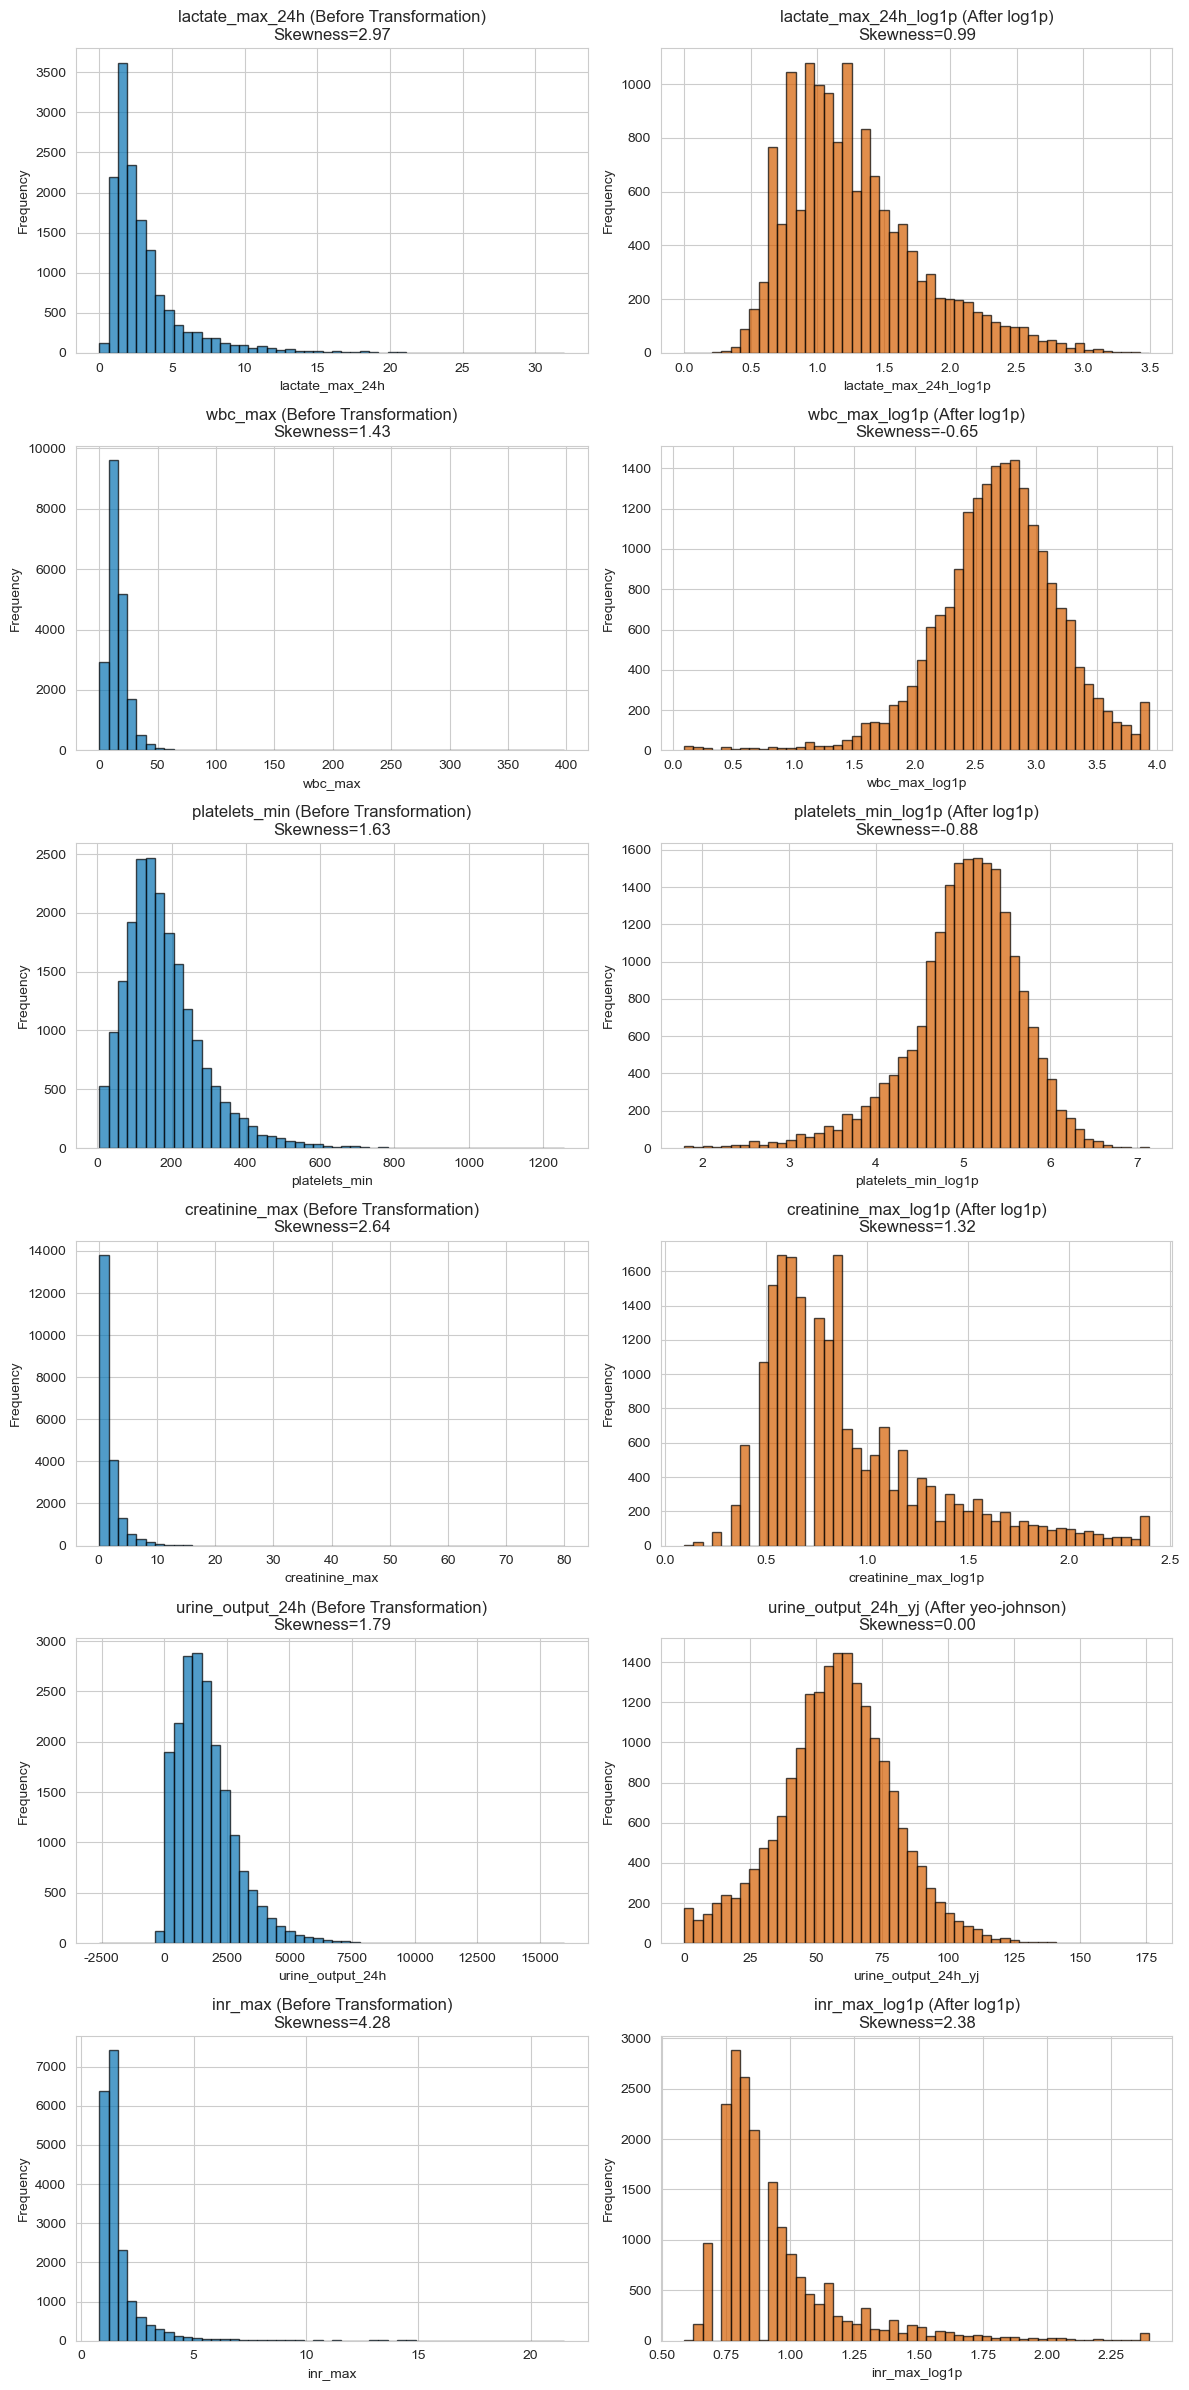


[Figure 12] Before and after transformation comparison saved


In [135]:
print("\n--- C3. Transformation and Standardization ---")

# Identify strongly skewed variables (based on Step 1 results)
skewed_vars = []
for var in continuous_vars:
    if var in df_processed.columns:
        data = df_processed[var].dropna()
        if len(data) > 0:
            var_skew = abs(skew(data))
            if var_skew > 1.0:  # |skewness| > 1 is considered strong skew
                skewed_vars.append(var)

transformation_log = []
transformers = {}

# ===== Special handling for lactate_max_24h: always create log-transformed version =====
# Create a log version for modeling stability regardless of skewness.
# Retain raw values for interpretability; use log version for statistical modeling.
if 'lactate_max_24h' in df_processed.columns:
    data_before = df_processed['lactate_max_24h'].dropna()
    if len(data_before) > 0 and data_before.min() >= 0:
        # Check if log version already exists
        if 'lactate_max_24h_log1p' not in df_processed.columns:
            skew_before = skew(data_before)
            kurt_before = kurtosis(data_before)
            
            # Log1p transformation
            df_processed['lactate_max_24h_log1p'] = np.log1p(df_processed['lactate_max_24h'])
            data_after = df_processed['lactate_max_24h_log1p'].dropna()
            skew_after = skew(data_after)
            kurt_after = kurtosis(data_after)
            
            transformation_log.append({
                'variable': 'lactate_max_24h',
                'transformation': 'after log1p',
                'skewness_before': skew_before,
                'skewness_after': skew_after,
                'kurtosis_before': kurt_before,
                'kurtosis_after': kurt_after
            })
            print(f"  - lactate_max_24h: log-transformed version created (lactate_max_24h_log1p)")
            print(f"    Original value range: [{data_before.min():.2f}, {data_before.max():.2f}]")
            print(f"    Log-transformed range: [{data_after.min():.2f}, {data_after.max():.2f}]")
            print(f"    Note: Raw values retained for interpretability; log version used for modeling.")

# Transform strongly skewed variables
# Use Yeo-Johnson for variables containing zero values (e.g., urine_output_24h)
# Use log1p for other skewed variables
for var in skewed_vars:
    if var in df_processed.columns:
        data_before = df_processed[var].dropna()
        if len(data_before) > 0:
            # Skip if log or yj transformation already exists
            if f'{var}_log' in df_processed.columns or f'{var}_log1p' in df_processed.columns:
                continue
            if f'{var}_yj' in df_processed.columns:
                continue
                
            skew_before = skew(data_before)
            kurt_before = kurtosis(data_before)
            
            # Use Yeo-Johnson transformation for urine_output_24h (handles zero and negative values)
            if var == 'urine_output_24h':
                yj_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
                data_before_array = df_processed[var].values.reshape(-1, 1)
                non_missing_mask = ~pd.isna(df_processed[var])
                if non_missing_mask.sum() > 0:
                    yj_transformer.fit(data_before_array[non_missing_mask])
                    df_processed[f'{var}_yj'] = np.nan
                    df_processed.loc[non_missing_mask, f'{var}_yj'] = yj_transformer.transform(data_before_array[non_missing_mask]).flatten()
                    
                    data_after = df_processed[f'{var}_yj'].dropna()
                    skew_after = skew(data_after)
                    kurt_after = kurtosis(data_after)
                    
                    transformation_log.append({
                        'variable': var,
                        'transformation': 'yeo-johnson',
                        'skewness_before': skew_before,
                        'skewness_after': skew_after,
                        'kurtosis_before': kurt_before,
                        'kurtosis_after': kurt_after
                    })
                    print(f"  - {var}: Yeo-Johnson transformation applied (handles zero values)")
                    print(f"    Original value range: [{data_before.min():.2f}, {data_before.max():.2f}]")
                    print(f"    Transformed range: [{data_after.min():.4f}, {data_after.max():.4f}]")
                    print(f"    Skewness: {skew_before:.4f} -> {skew_after:.4f}")
                    
                    # Save transformer
                    transformers[f'{var}_yeo_johnson'] = yj_transformer

            elif data_before.min() >= 0:
                # Use log1p transformation for non-negative values
                df_processed[f'{var}_log1p'] = np.log1p(df_processed[var])
                data_after = df_processed[f'{var}_log1p'].dropna()
                skew_after = skew(data_after)
                kurt_after = kurtosis(data_after)
                
                transformation_log.append({
                    'variable': var,
                    'transformation': 'log1p',
                    'skewness_before': skew_before,
                    'skewness_after': skew_after,
                    'kurtosis_before': kurt_before,
                    'kurtosis_after': kurt_after
                })

# Apply quantile transformation to remaining continuous variables
other_vars = [v for v in continuous_vars if v in df_processed.columns and v not in skewed_vars]
if len(other_vars) > 0:
    from sklearn.preprocessing import QuantileTransformer
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    data_to_transform = df_processed[other_vars].dropna()
    if len(data_to_transform) > 0:
        transformed_data = qt.fit_transform(data_to_transform)
        for idx, var in enumerate(other_vars):
            df_processed[f'{var}_qt'] = np.nan
            df_processed.loc[data_to_transform.index, f'{var}_qt'] = transformed_data[:, idx]
        transformers['quantile_transformer'] = qt

df_transformation_log = pd.DataFrame(transformation_log)
if len(df_transformation_log) > 0:
    df_transformation_log.to_csv(table_dir / "Table11_TransformationEffects.csv", index=False)
    print(f"[Table 11] Transformation effects (skewness/kurtosis before → after) saved")
else:
    df_transformation_log = pd.DataFrame(columns=['variable', 'transformation', 'skewness_before', 
                                                   'skewness_after', 'kurtosis_before', 'kurtosis_after'])
    df_transformation_log.to_csv(table_dir / "Table11_TransformationEffects.csv", index=False)
    print(f"[Table 11] Transformation effects (skewness/kurtosis before → after) saved (empty)")

print("\n" + "="*80)
print("Table 11: Transformation Effects (Skewness/Kurtosis Before → After)")
print("="*80)
if len(df_transformation_log) > 0:
    display(df_transformation_log)
else:
    print("No transformations were performed.")
    display(df_transformation_log)

# Before and after comparison plot
print(f"\nGenerating Figure 12: Before and after transformation comparison...")
print(f"Number of transformations: {len(transformation_log)}")
if len(transformation_log) > 0:
    df_transformation_log_for_plot = pd.DataFrame(transformation_log)
    n_vars = min(6, len(df_transformation_log_for_plot))
    print(f"Number of variables to plot: {n_vars}")
    fig, axes = plt.subplots(n_vars, 2, figsize=(12, 4*n_vars))
    if n_vars == 1:
        axes = axes.reshape(1, -1)
    
    for idx, row in enumerate(df_transformation_log_for_plot.head(n_vars).itertuples()):
        var = row.variable
        if var in df_eda.columns or var in df_processed.columns:
            data_before = df_eda[var].dropna() if var in df_eda.columns else df_processed[var].dropna()
            if len(data_before) > 0:
                axes[idx, 0].hist(data_before, bins=50, alpha=0.7, edgecolor='black',
                                color=COLOR_PALETTE['survived'])
                axes[idx, 0].set_title(f'{var} (Before Transformation)\nSkewness={row.skewness_before:.2f}')
                axes[idx, 0].set_xlabel(var)
                axes[idx, 0].set_ylabel('Frequency')
            
            transformed_col = None
            transformed_name = None
            transformation_type = row.transformation if hasattr(row, 'transformation') else None
            
            if transformation_type == 'yeo-johnson' and f'{var}_yj' in df_processed.columns:
                transformed_col = f'{var}_yj'
                transformed_name = f'{var}_yj'
            elif ("log1p" in str(transformation_type)) and f'{var}_log1p' in df_processed.columns:
                transformed_col = f'{var}_log1p'
                transformed_name = f'{var}_log1p'
            elif f'{var}_log1p' in df_processed.columns:
                transformed_col = f'{var}_log1p'
                transformed_name = f'{var}_log1p'
            elif f'{var}_log' in df_processed.columns:
                transformed_col = f'{var}_log'
                transformed_name = f'{var}_log'
            
            if transformed_col:
                data_after = df_processed[transformed_col].dropna()
                if len(data_after) > 0:
                    axes[idx, 1].hist(data_after, bins=50, alpha=0.7, edgecolor='black', 
                                     color=COLOR_PALETTE['died'])
                    display_type = "log1p" if "log1p" in str(transformation_type) else transformation_type
                    axes[idx, 1].set_title(f'{transformed_name} (After {display_type})\nSkewness={row.skewness_after:.2f}')
                    axes[idx, 1].set_xlabel(transformed_name)
                    axes[idx, 1].set_ylabel('Frequency')
                else:
                    axes[idx, 1].text(0.5, 0.5, f'No data for {transformed_name}', 
                                     ha='center', va='center', transform=axes[idx, 1].transAxes)
                    axes[idx, 1].set_title(f'{transformed_name} (After Transformation)\nNo data')
            else:
                axes[idx, 1].text(0.5, 0.5, f'Transformed column not found\nfor {var}', 
                                 ha='center', va='center', transform=axes[idx, 1].transAxes)
                axes[idx, 1].set_title(f'{var} (After Transformation)\nNot found')
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure12_BeforeAndAfterTransformationComparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n[Figure 12] Before and after transformation comparison saved")
else:
    print("No transformations to plot for Figure 12.")

### C4. Encoding and Derived/Interaction Features (Interpretability-Oriented)


--- C4. Encoding and Derived/Interaction Features (Interpretable) ---
[Table 12] Infection source distribution and mortality saved

Table 12: Infection Source Distribution and Mortality


infection_source  count  mortality_rate
0            blood   6372        0.326428
1            other  11036        0.166908
2      respiratory    564        0.310284
3            urine   2419        0.250517

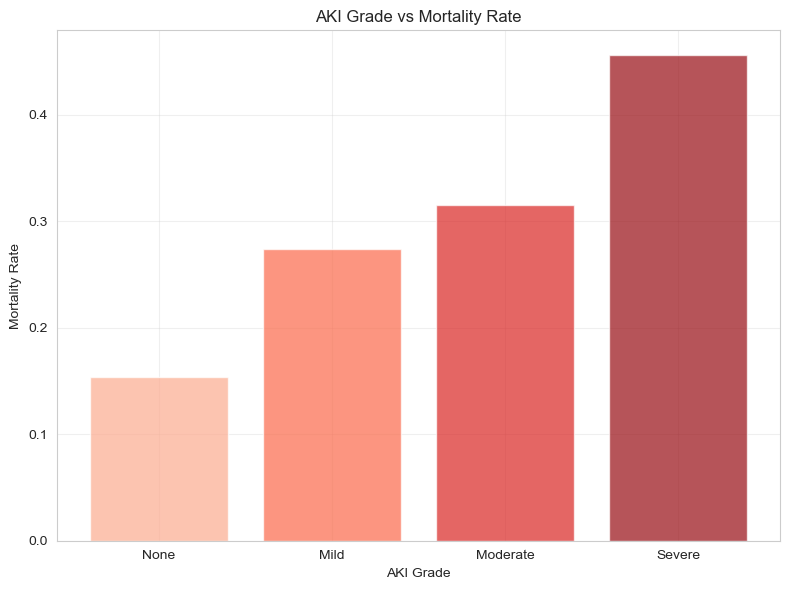


[Figure 13] AKI grade and mortality bar chart saved


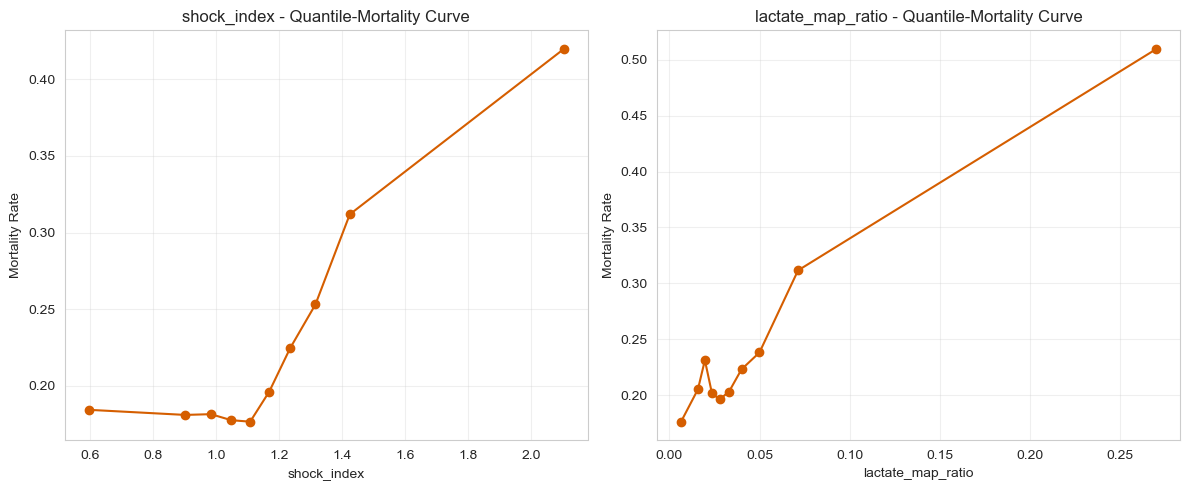


[Figure 14] Shock index/lactate-MAP ratio quantile-mortality curves saved


In [136]:
# C4. Encoding and Derived/Interaction Features (Interpretable)
print("\n--- C4. Encoding and Derived/Interaction Features (Interpretable) ---")

# Categorical encoding: infection_source_category → One-Hot
if 'infection_source_category' in df_processed.columns:
    infection_dummies = pd.get_dummies(df_processed['infection_source_category'], 
                                      prefix='infection_source', drop_first=False)
    df_processed = pd.concat([df_processed, infection_dummies], axis=1)
    
    # Infection source distribution and mortality
    if 'mortality_30d' in df_processed.columns:
        infection_mortality = df_processed.groupby('infection_source_category')['mortality_30d'].agg(['count', 'mean']).reset_index()
        infection_mortality.columns = ['infection_source', 'count', 'mortality_rate']
        infection_mortality.to_csv(table_dir / "Table12_InfectionSourceDistributionAndMortality.csv", index=False, encoding='utf-8-sig')
        print(f"[Table 12] Infection source distribution and mortality saved")
        
        # Display Table 12
        print("\n" + "="*80)
        print("Table 12: Infection Source Distribution and Mortality")
        print("="*80)
        display(infection_mortality)

# Interaction features
if 'sofa_total' in df_processed.columns and 'lactate_max_24h' in df_processed.columns:
    df_processed['sofa_lactate_interaction'] = df_processed['sofa_total'] * df_processed['lactate_max_24h']

if 'sofa_total' in df_processed.columns and 'age' in df_processed.columns:
    df_processed['sofa_age_interaction'] = df_processed['sofa_total'] * df_processed['age']

# Derived features
# AKI crude grading (approximated by creatinine_max + urine_output_24h)
if 'creatinine_max' in df_processed.columns and 'urine_output_24h' in df_processed.columns:
    # Simplified AKI grading (based on creatinine and urine output)
    df_processed['aki_grade'] = 0
    df_processed.loc[(df_processed['creatinine_max'] >= 1.5) & 
                     (df_processed['creatinine_max'] < 3.0), 'aki_grade'] = 1
    df_processed.loc[(df_processed['creatinine_max'] >= 3.0), 'aki_grade'] = 2
    df_processed.loc[(df_processed['urine_output_24h'] < 500), 'aki_grade'] = 3  # Severe oliguria
    
    # AKI grade and mortality
    if 'mortality_30d' in df_processed.columns:
        aki_mortality = df_processed.groupby('aki_grade')['mortality_30d'].agg(['count', 'mean']).reset_index()
        aki_mortality.columns = ['aki_grade', 'count', 'mortality_rate']
        
        plt.figure(figsize=(8, 6))
        colors_aki = plt.cm.get_cmap(COLOR_PALETTE['sequential_cmap'])(
            np.linspace(0.3, 0.9, len(aki_mortality)))
        plt.bar(aki_mortality['aki_grade'], aki_mortality['mortality_rate'], 
               alpha=0.7, color=colors_aki)
        plt.xlabel('AKI Grade')
        plt.ylabel('Mortality Rate')
        plt.title('AKI Grade vs Mortality Rate')
        plt.xticks(aki_mortality['aki_grade'], ['None', 'Mild', 'Moderate', 'Severe'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(fig_dir / "Figure13_AKIGradeAndMortalityBarChart.png", dpi=300, bbox_inches='tight')
        plt.show()  # Display the plot in notebook
        print(f"\n[Figure 13] AKI grade and mortality bar chart saved")

# Shock index: HR/MBP
if 'heart_rate_mean' in df_processed.columns and 'mbp_mean' in df_processed.columns:
    df_processed['shock_index'] = df_processed['heart_rate_mean'] / (df_processed['mbp_mean'] + 1e-10)

# Lactate/MAP ratio
if 'lactate_max_24h' in df_processed.columns and 'mbp_mean' in df_processed.columns:
    df_processed['lactate_map_ratio'] = df_processed['lactate_max_24h'] / (df_processed['mbp_mean'] + 1e-10)

# Quantile-mortality curves for shock index and lactate-MAP ratio
if 'mortality_30d' in df_processed.columns:
    derived_vars = []
    if 'shock_index' in df_processed.columns:
        derived_vars.append('shock_index')
    if 'lactate_map_ratio' in df_processed.columns:
        derived_vars.append('lactate_map_ratio')
    
    if len(derived_vars) > 0:
        fig, axes = plt.subplots(1, len(derived_vars), figsize=(6*len(derived_vars), 5))
        if len(derived_vars) == 1:
            axes = [axes]
        
        for idx, var in enumerate(derived_vars):
            data_subset = df_processed[[var, 'mortality_30d']].dropna()
            if len(data_subset) > 10:
                data_subset['quantile'] = pd.qcut(data_subset[var], q=10, duplicates='drop')
                quantile_mortality = data_subset.groupby('quantile')['mortality_30d'].mean().reset_index()
                quantile_mortality['quantile_center'] = quantile_mortality['quantile'].apply(lambda x: x.mid)
                
                axes[idx].plot(quantile_mortality['quantile_center'], quantile_mortality['mortality_30d'], 
                             'o-', color=COLOR_PALETTE['died'])
                axes[idx].set_xlabel(var)
                axes[idx].set_ylabel('Mortality Rate')
                axes[idx].set_title(f'{var} - Quantile-Mortality Curve')
                axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(fig_dir / "Figure14_ShockIndexLactateMAPRatioQuantileMortalityCurves.png", dpi=300, bbox_inches='tight')
        plt.show()  # Display the plot in notebook
        print(f"\n[Figure 14] Shock index/lactate-MAP ratio quantile-mortality curves saved")




## Step 3: Post-Cleaning Review (Validation and Consistency Check)


Generating key variable distributions after cleaning...


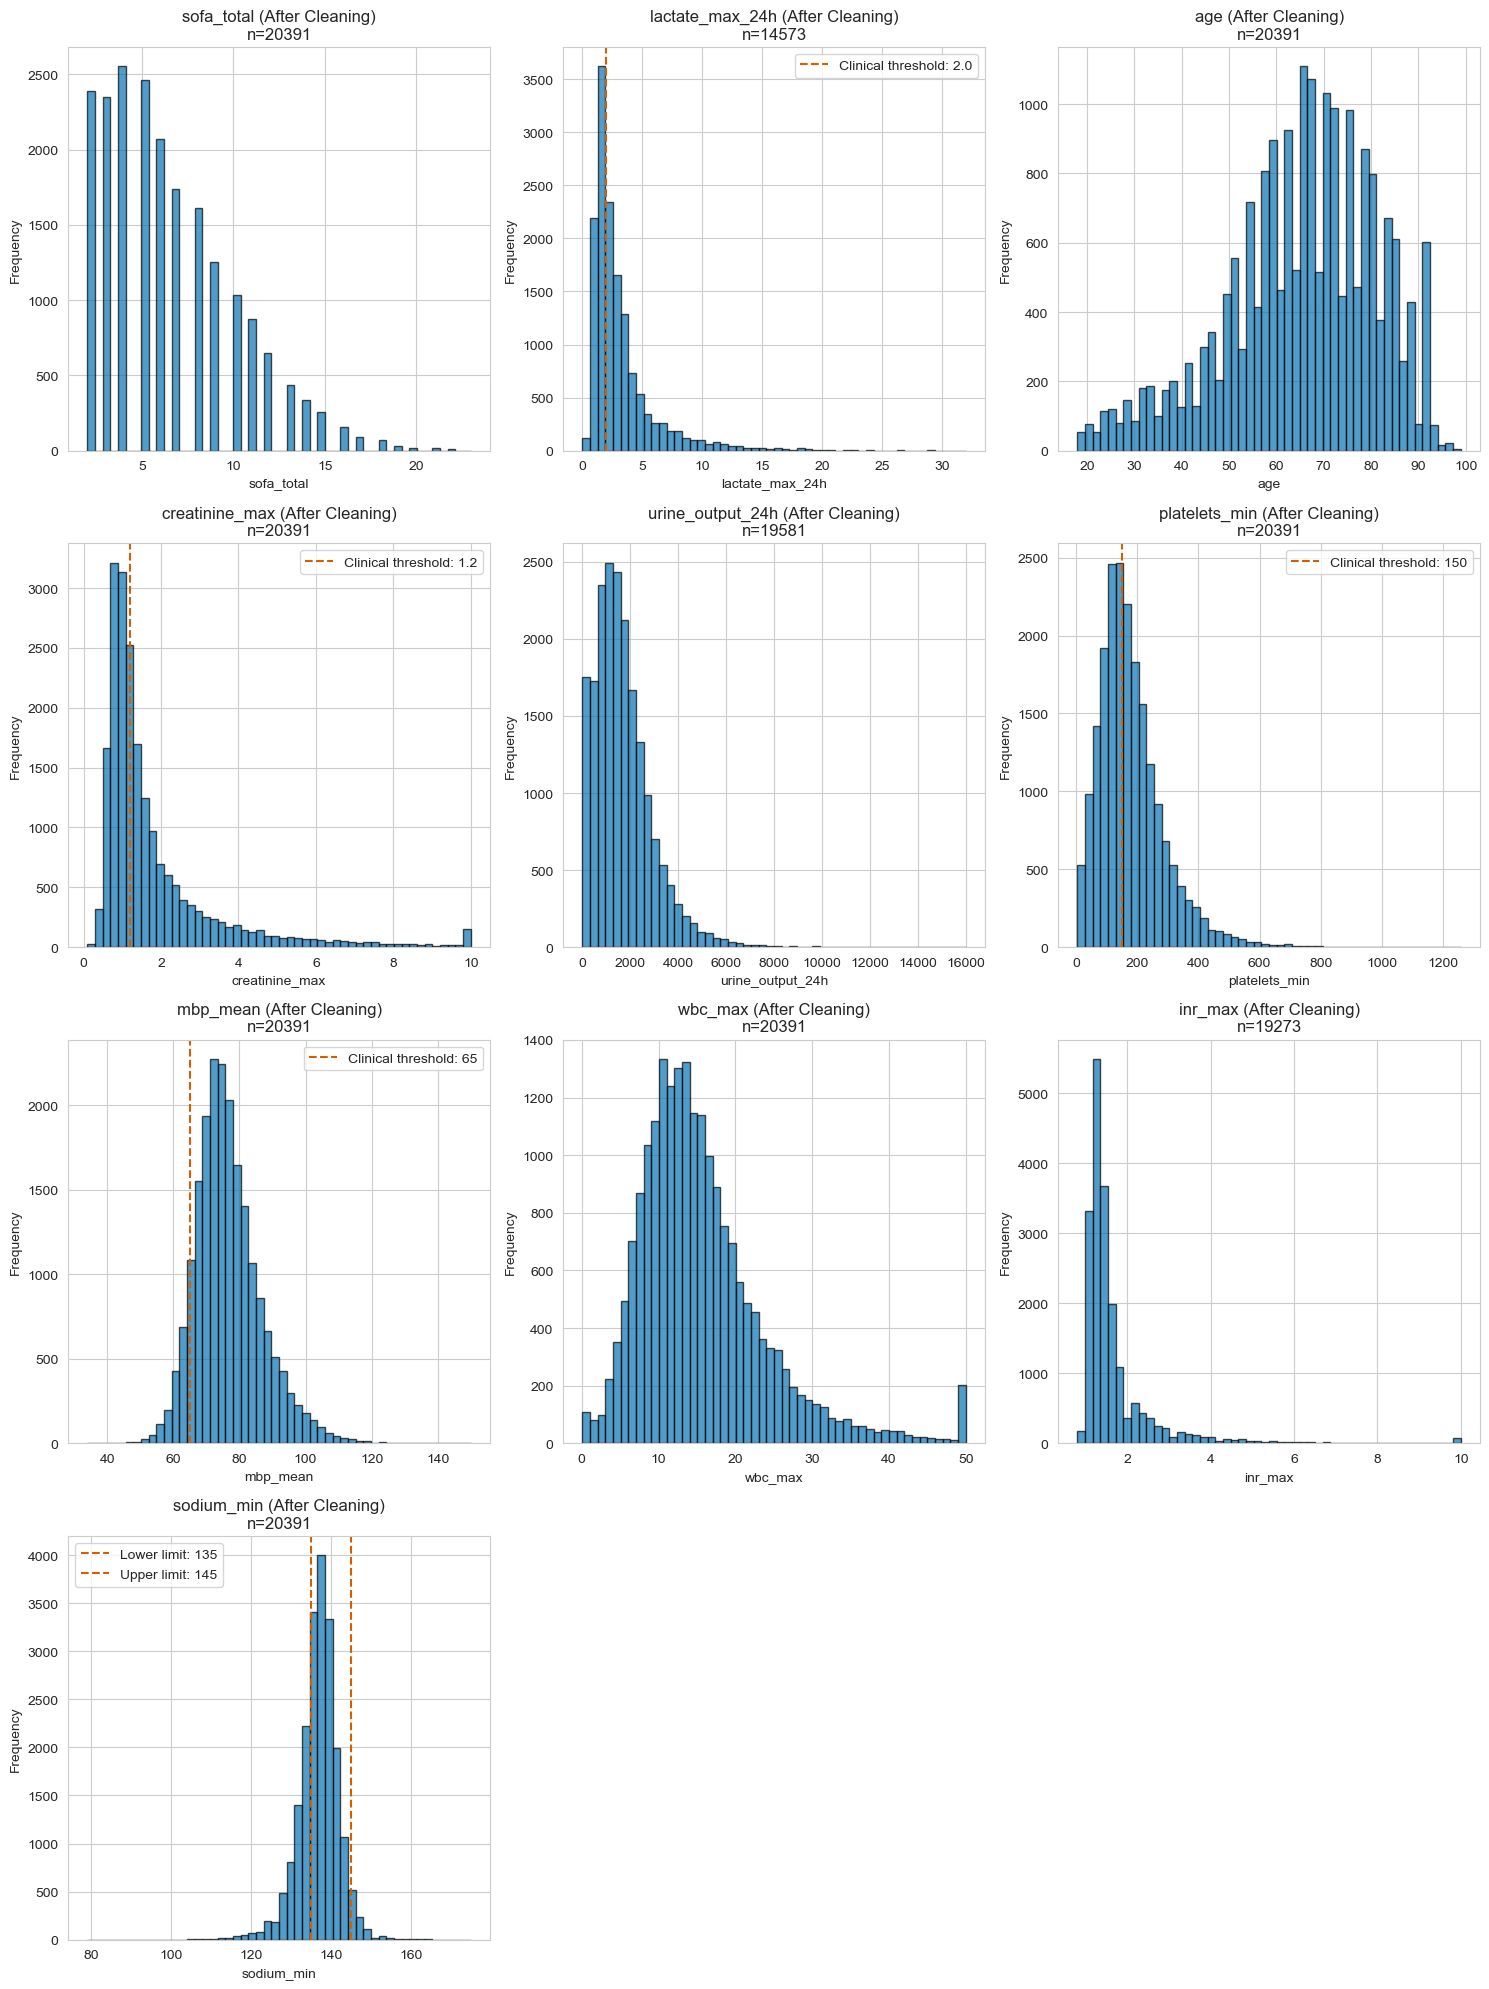


[Figure 15] Key variable distributions after cleaning saved


In [137]:
# Plot distributions again (check long-tail convergence, anomaly disappearance)
# Note: Reasons for distribution differences after cleaning:
# 1. Missing value imputation: All missing values imputed with median, sample size increased
# 2. Capping operation: Values exceeding clinical upper limits truncated to upper limit (e.g., lactate_max_24h upper limit 20)
# 3. Distribution shape changes: Imputation increased median values, tails truncated, distribution more concentrated
print("\nGenerating key variable distributions after cleaning...")
# Keep consistent with Figure 2, but exclude deleted platelets_max and sodium_max
key_vars_cleaned = ['sofa_total', 'lactate_max_24h', 'age', 'creatinine_max', 
                    'urine_output_24h', 'platelets_min', 'mbp_mean', 'wbc_max', 
                    'inr_max', 'sodium_min']

key_vars_cleaned = [v for v in key_vars_cleaned if v in df_processed.columns]

n_cols = 3
n_rows = (len(key_vars_cleaned) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Clinical thresholds (consistent with Figure 2)
clinical_thresholds = {
    'lactate_max_24h': 2.0,  # mmol/L
    'platelets_min': 150,  # ×10^9/L
    'sodium_min': (135, 145),  # mmol/L (range)
    'creatinine_max': 1.2,  # mg/dL (male reference value)
    'mbp_mean': 65,  # mmHg
}

for idx, var in enumerate(key_vars_cleaned):
    if idx < len(axes):
        data = df_processed[var].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=50, alpha=0.7, edgecolor='black',
                          color=COLOR_PALETTE['survived'])
            axes[idx].set_title(f'{var} (After Cleaning)\nn={len(data)}')
            axes[idx].set_xlabel(var)
            axes[idx].set_ylabel('Frequency')
            
            # Add clinical thresholds (consistent with Figure 2)
            if var in clinical_thresholds:
                threshold = clinical_thresholds[var]
                if isinstance(threshold, tuple):
                    axes[idx].axvline(threshold[0], color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Lower limit: {threshold[0]}')
                    axes[idx].axvline(threshold[1], color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Upper limit: {threshold[1]}')
                    axes[idx].legend()
                else:
                    axes[idx].axvline(threshold, color=COLOR_PALETTE['died'], linestyle='--', 
                                     label=f'Clinical threshold: {threshold}')
                    axes[idx].legend()

for idx in range(len(key_vars_cleaned), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(fig_dir / "Figure15_KeyVariableDistributionsAfterCleaning.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot in notebook
print(f"\n[Figure 15] Key variable distributions after cleaning saved")

### Re-generate Key Quantile–Mortality Curves


Generating quantile-mortality curves after cleaning...


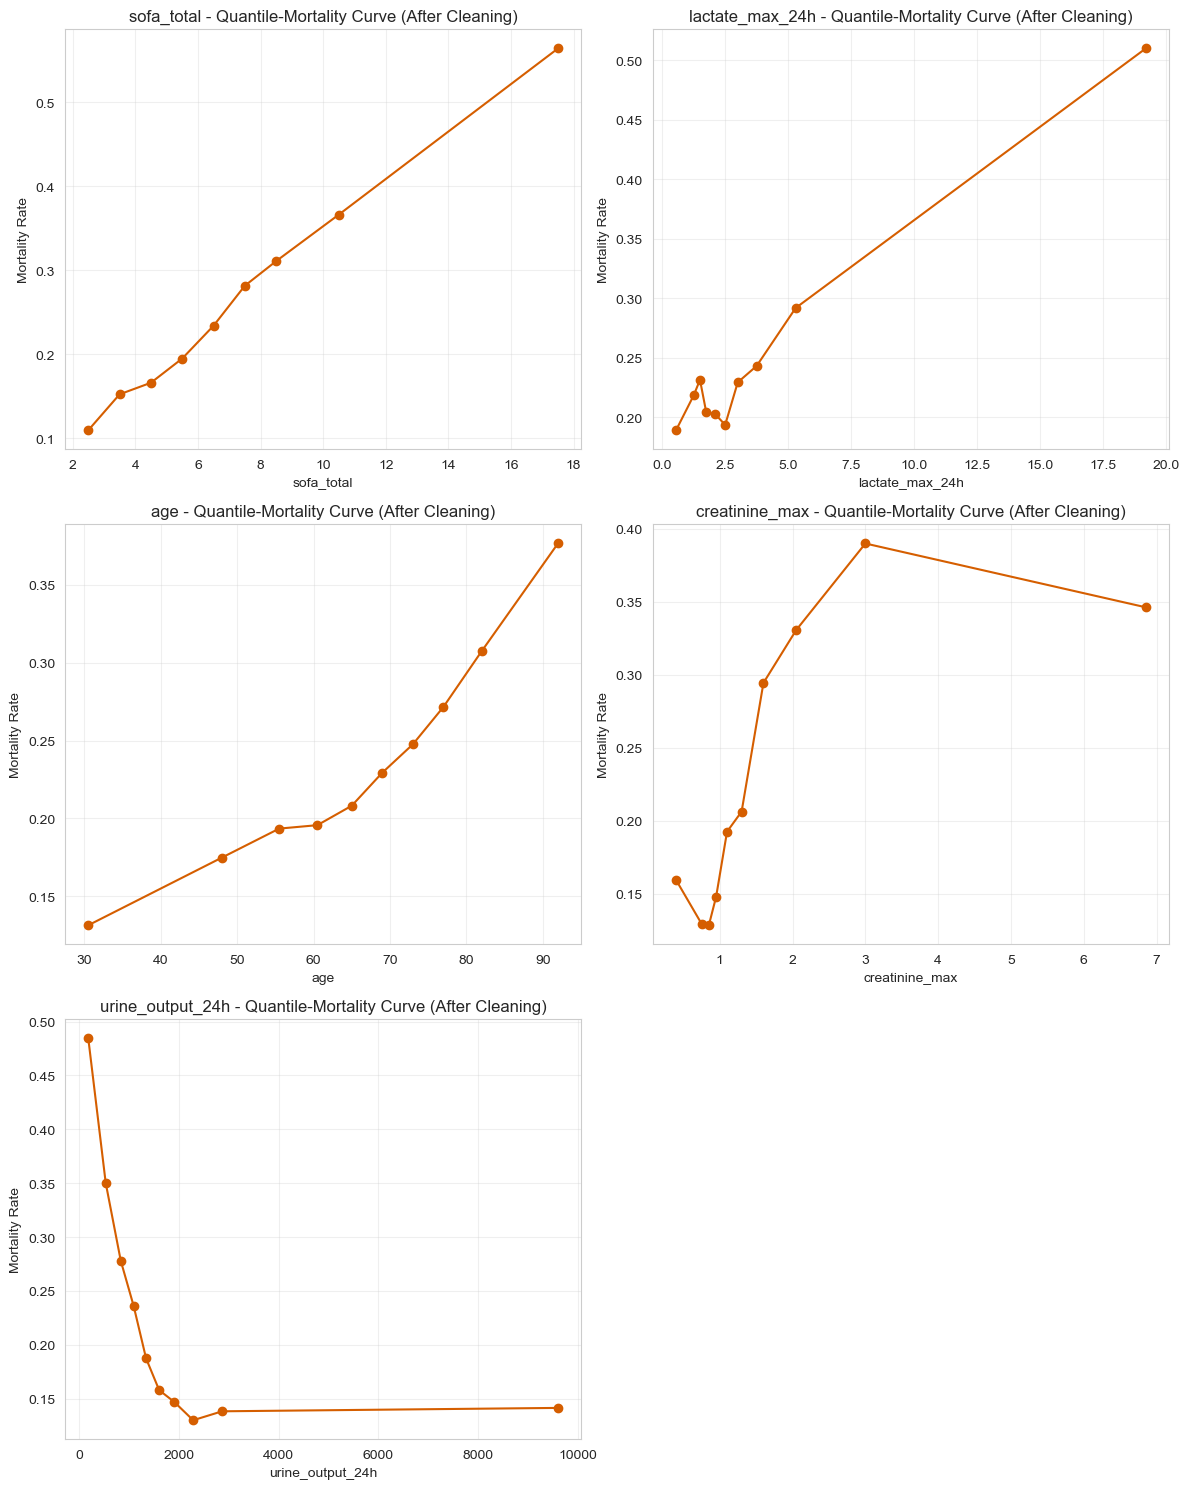


[Figure 16] Quantile-mortality curves (after cleaning) saved


In [138]:
# Generate quantile-mortality curves after cleaning
print("\nGenerating quantile-mortality curves after cleaning...")
if 'mortality_30d' in df_processed.columns:
    key_vars_for_quantile_cleaned = ['sofa_total', 'lactate_max_24h', 'age', 'creatinine_max', 'urine_output_24h']
    key_vars_for_quantile_cleaned = [v for v in key_vars_for_quantile_cleaned if v in df_processed.columns]
    
    n_cols = 2
    n_rows = (len(key_vars_for_quantile_cleaned) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, var in enumerate(key_vars_for_quantile_cleaned):
        if idx < len(axes):
            data_subset = df_processed[[var, 'mortality_30d']].dropna()
            if len(data_subset) > 10:
                data_subset['quantile'] = pd.qcut(data_subset[var], q=10, duplicates='drop')
                quantile_mortality = data_subset.groupby('quantile')['mortality_30d'].mean().reset_index()
                quantile_mortality['quantile_center'] = quantile_mortality['quantile'].apply(lambda x: x.mid)
                
                axes[idx].plot(quantile_mortality['quantile_center'], quantile_mortality['mortality_30d'], 
                             'o-', color=COLOR_PALETTE['died'])
                axes[idx].set_xlabel(var)
                axes[idx].set_ylabel('Mortality Rate')
                axes[idx].set_title(f'{var} - Quantile-Mortality Curve (After Cleaning)')
                axes[idx].grid(True, alpha=0.3)
    
    for idx in range(len(key_vars_for_quantile_cleaned), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(fig_dir / "Figure16_QuantileMortalityCurvesAfterCleaning.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in notebook
    print(f"\n[Figure 16] Quantile-mortality curves (after cleaning) saved")

### Comparison of Univariate Performance Before and After Data Cleaning

In [139]:
# Univariate performance comparison before and after cleaning
print("\nUnivariate performance comparison before and after cleaning...")
if 'mortality_30d' in df_eda.columns and 'mortality_30d' in df_processed.columns:
    comparison_vars = ['sofa_total', 'lactate_max_24h', 'age', 'creatinine_max', 'urine_output_24h']
    comparison_vars = [v for v in comparison_vars if v in df_eda.columns and v in df_processed.columns]
    
    performance_comparison = []
    
    for var in comparison_vars:
        # Before cleaning
        data_before = df_eda[[var, 'mortality_30d']].dropna()
        if len(data_before) > 50:
            try:
                from sklearn.linear_model import LogisticRegression
                from sklearn.metrics import roc_auc_score, average_precision_score
                X_before = data_before[[var]].values
                y_before = data_before['mortality_30d'].values
                q25, q75 = np.percentile(X_before, [25, 75])
                iqr = q75 - q25
                if iqr > 0:
                    X_before_iqr = (X_before - q25) / iqr
                    lr_before = LogisticRegression(max_iter=1000)
                    lr_before.fit(X_before_iqr, y_before)
                    y_pred_proba_before = lr_before.predict_proba(X_before_iqr)[:, 1]
                    auc_before = roc_auc_score(y_before, y_pred_proba_before)
                    pr_auc_before = average_precision_score(y_before, y_pred_proba_before)
                else:
                    auc_before, pr_auc_before = 0, 0
            except:
                auc_before, pr_auc_before = 0, 0
        else:
            auc_before, pr_auc_before = 0, 0
        
        # After cleaning
        data_after = df_processed[[var, 'mortality_30d']].dropna()
        if len(data_after) > 50:
            try:
                X_after = data_after[[var]].values
                y_after = data_after['mortality_30d'].values
                q25, q75 = np.percentile(X_after, [25, 75])
                iqr = q75 - q25
                if iqr > 0:
                    X_after_iqr = (X_after - q25) / iqr
                    lr_after = LogisticRegression(max_iter=1000)
                    lr_after.fit(X_after_iqr, y_after)
                    y_pred_proba_after = lr_after.predict_proba(X_after_iqr)[:, 1]
                    auc_after = roc_auc_score(y_after, y_pred_proba_after)
                    pr_auc_after = average_precision_score(y_after, y_pred_proba_after)
                else:
                    auc_after, pr_auc_after = 0, 0
            except:
                auc_after, pr_auc_after = 0, 0
        else:
            auc_after, pr_auc_after = 0, 0
        
        performance_comparison.append({
            'variable': var,
            'AUC_before': auc_before,
            'AUC_after': auc_after,
            'delta_AUC': auc_after - auc_before,
            'PR_AUC_before': pr_auc_before,
            'PR_AUC_after': pr_auc_after,
            'delta_PR_AUC': pr_auc_after - pr_auc_before
        })
    
    if performance_comparison:
        df_performance = pd.DataFrame(performance_comparison)
        df_performance.to_csv(table_dir / "Table15_UnivariatePerformanceComparisonBeforeAndAfterCleaning.csv", index=False, encoding='utf-8-sig')
        print(f"[Table 15] Univariate performance comparison before and after cleaning (ΔAUC/ΔPR-AUC) saved")
        
        # Display Table 15
        print("\n" + "="*80)
        print("Table 15: Univariate Performance Comparison Before and After Cleaning (ΔAUC/ΔPR-AUC)")
        print("="*80)
        display(df_performance)


Univariate performance comparison before and after cleaning...
[Table 15] Univariate performance comparison before and after cleaning (ΔAUC/ΔPR-AUC) saved

Table 15: Univariate Performance Comparison Before and After Cleaning (ΔAUC/ΔPR-AUC)


variable  AUC_before  AUC_after     delta_AUC  PR_AUC_before  \
0        sofa_total    0.686219   0.686219  0.000000e+00       0.401487   
1   lactate_max_24h    0.598141   0.598141  0.000000e+00       0.386822   
2               age    0.602098   0.602098  0.000000e+00       0.305168   
3    creatinine_max    0.632779   0.632716 -6.265421e-05       0.309122   
4  urine_output_24h    0.663568   0.663568 -3.885534e-07       0.378531   

   PR_AUC_after  delta_PR_AUC  
0      0.401487      0.000000  
1      0.386822      0.000000  
2      0.305168      0.000000  
3      0.309004     -0.000118  
4      0.378514     -0.000017

## Step E: Model Preparation (Methodology Transparency)

In [140]:
# Patient-stratified Train/Val/Test split
print("\nData splitting...")
from sklearn.model_selection import train_test_split

# Ensure each patient is only in one set (based on subject_id)
if 'subject_id' in df_processed.columns:
    unique_subjects = df_processed['subject_id'].unique()
    
    # First group by subject_id, then stratified split
    subject_outcomes = df_processed.groupby('subject_id')['mortality_30d'].first()
    
    # First split: train + temp (80/20)
    train_subjects, temp_subjects = train_test_split(
        unique_subjects, 
        test_size=0.2, 
        stratify=subject_outcomes.loc[unique_subjects],
        random_state=42
    )
    
    # Second split: temp -> val + test (50/50)
    temp_outcomes = subject_outcomes.loc[temp_subjects]
    val_subjects, test_subjects = train_test_split(
        temp_subjects,
        test_size=0.5,
        stratify=temp_outcomes,
        random_state=42
    )
    
    # Create split identifier
    df_processed['split'] = 'train'
    df_processed.loc[df_processed['subject_id'].isin(val_subjects), 'split'] = 'val'
    df_processed.loc[df_processed['subject_id'].isin(test_subjects), 'split'] = 'test'
    
    # Verify stratification
    split_summary = df_processed.groupby('split')['mortality_30d'].agg(['count', 'mean'])
    print("\nData split results:")
    print(split_summary)
    
    # Data split and processing consistency diagram (text description)
    split_text = f"""
Data Split and Processing Consistency Diagram:
- Training set: {len(train_subjects)} patients ({len(df_processed[df_processed['split']=='train'])} records)
- Validation set: {len(val_subjects)} patients ({len(df_processed[df_processed['split']=='val'])} records)
- Test set: {len(test_subjects)} patients ({len(df_processed[df_processed['split']=='test'])} records)

Processing workflow:
1. All transformations/imputations/selectors fit only on training set
2. Only transform validation and test sets
3. Maintain data leakage prevention
"""
    with open(fig_dir / "Figure17_DataSplitAndProcessingConsistencyDiagram.txt", 'w', encoding='utf-8') as f:
        f.write(split_text)
    print(f"[Figure 17] Data split and processing consistency diagram saved")

# Data validation before exporting cleaned data
print("\n--- Data Validation ---")
# 1. Verify deleted features are not in output
deleted_features_check = ['platelets_max', 'sodium_max']
for feat in deleted_features_check:
    if feat in df_processed.columns:
        print(f" Warning: {feat} still in data, will be deleted")
        df_processed = df_processed.drop(columns=[feat])
    else:
        print(f"{feat} successfully deleted")

# 2. Verify lactate_max_24h, inr_max, urine_output_24h missing values remain as NaN
no_imputation_check_vars = ['lactate_max_24h', 'inr_max', 'urine_output_24h']
for var in no_imputation_check_vars:
    if var in df_processed.columns:
        var_missing = df_processed[var].isna().sum()
        var_total = len(df_processed)
        print(f"{var} missing count: {var_missing} ({var_missing/var_total*100:.2f}%) - kept as NaN")

# 3. Verify albumin_min has been imputed via MICE
if 'albumin_min' in df_processed.columns:
    albumin_missing = df_processed['albumin_min'].isna().sum()
    if albumin_missing == 0:
        print(f"  albumin_min imputed via MICE, no missing values")
    else:
        print(f"  Warning: albumin_min still has {albumin_missing} missing values")

print("\nExporting data...")
df_processed.to_csv(CLEANED_DATA_FILE, index=False)
print(f"Cleaned data saved: {CLEANED_DATA_FILE}")

# Export artifacts list
artifacts_list = {
    'cleaned_data': 'cleaned_data.csv',
    'feature_list': 'feature_list.json',
    'data_dictionary': 'Table1_VariableTypeUnitTimeWindowList.csv',
    'transformers': {
        'quantile_transformer': 'quantile_transformer.pkl' if 'quantile_transformer' in transformers else None
    },
    'version': '1.0',
    'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save scaler/transformer (if available)
import pickle
if 'quantile_transformer' in transformers:
    with open(output_dir / 'quantile_transformer.pkl', 'wb') as f:
        pickle.dump(transformers['quantile_transformer'], f)

with open(output_dir / 'artifacts_list.json', 'w', encoding='utf-8') as f:
    json.dump(artifacts_list, f, indent=2, ensure_ascii=False)

# Create artifacts table
artifacts_table_data = []
for k, v in artifacts_list.items():
    if k not in ['version', 'date']:
        if isinstance(v, dict):
            # Handle nested dictionaries (like transformers)
            for sub_k, sub_v in v.items():
                if sub_v is not None:
                    artifacts_table_data.append({
                        'artifact': f'{k}.{sub_k}',
                        'file': sub_v,
                        'description': 'Data/Model Artifact'
                    })
        else:
            artifacts_table_data.append({
                'artifact': k,
                'file': v,
                'description': 'Data/Model Artifact'
            })

# Add version and date as separate rows
artifacts_table_data.append({
    'artifact': 'version',
    'file': artifacts_list.get('version', 'N/A'),
    'description': 'Version Information'
})
artifacts_table_data.append({
    'artifact': 'date',
    'file': artifacts_list.get('date', 'N/A'),
    'description': 'Export Date'
})

df_artifacts = pd.DataFrame(artifacts_table_data)
df_artifacts.to_csv(table_dir / "Table16_ExportedArtifactsAndVersionList.csv", index=False)
print(f"[Table 16] Exported artifacts and version list saved")

# Display Table 16
print("\n" + "="*80)
print("Table 16: Exported Artifacts and Version List")
print("="*80)
display(df_artifacts)


Data splitting...

Data split results:
       count      mean
split                 
test    2055   0.23309
train  16300  0.229755
val     2036  0.235265
[Figure 17] Data split and processing consistency diagram saved

--- Data Validation ---
platelets_max successfully deleted
sodium_max successfully deleted
lactate_max_24h missing count: 5818 (28.53%) - kept as NaN
inr_max missing count: 1118 (5.48%) - kept as NaN
urine_output_24h missing count: 810 (3.97%) - kept as NaN
  albumin_min imputed via MICE, no missing values

Exporting data...
Cleaned data saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/cleaned_data.csv
[Table 16] Exported artifacts and version list saved

Table 16: Exported Artifacts and Version List


artifact  \
0                       cleaned_data   
1                       feature_list   
2                    data_dictionary   
3  transformers.quantile_transformer   
4                            version   
5                               date   

                                        file          description  
0                           cleaned_data.csv  Data/Model Artifact  
1                          feature_list.json  Data/Model Artifact  
2  Table1_VariableTypeUnitTimeWindowList.csv  Data/Model Artifact  
3                   quantile_transformer.pkl  Data/Model Artifact  
4                                        1.0  Version Information  
5                        2025-11-08 15:17:22          Export Date

# Complete modeling pipeline for Sepsis-3 30-day mortality prediction

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, 
    recall_score, precision_score, f1_score, fbeta_score,
    brier_score_loss, roc_curve, precision_recall_curve,
    confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.special import expit
import xgboost as xgb
import lightgbm as lgb
import shap
import joblib

# Use path management from Cell 2 (Path Management)
# All path variables (RAW_DATA_FILE, CLEANED_DATA_FILE, OUTPUT_DIR, etc.) 
# and get_output_paths() function are already defined in Cell 2
OUTPUT_PATHS = get_output_paths('original')

warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

# Clinical risk theme color palette (consistent with EDA script)
COLOR_PALETTE = {
    # Binary classification color scheme (Binary: Survived vs. Died)
    'survived': '#0773B3',  # Clinical Blue
    'died': '#D55E00',       # Warning Red
    'binary_palette': {0: '#0773B3', 1: '#D55E00'},
    
    # Sequential variable color scheme (Sequential: Risk/Severity)
    'sequential_cmap': 'Reds',  # or 'YlOrRd'
    
    # Diverging/correlation color scheme (Diverging: Correlation)
    'diverging_cmap': 'vlag',  # or 'RdBu_r'
    
    # Categorical subgroup color scheme (Categorical: Infection source, etc.)
    'categorical_palette': 'Dark2',  # or 'muted'
}

## Step 1: Data Preparation

In [142]:
print("\n[Step 1] Data Preparation")
print("-" * 80)

# Load cleaned data from output directory
from path_config import CLEANED_DATA_FILE
data_path = CLEANED_DATA_FILE
if not data_path.exists():
    raise FileNotFoundError(f"Cleaned data file not found: {data_path}\nPlease run 1-data_cleaning_eda.py to generate cleaned data")
df = pd.read_csv(data_path)

print(f"Loaded data: {df.shape[0]} rows * {df.shape[1]} columns")

# Remove ID columns and split column if exists
id_cols = ['subject_id', 'hadm_id', 'stay_id', 'split']
id_cols_present = [col for col in id_cols if col in df.columns]
if id_cols_present:
    df = df.drop(columns=id_cols_present)
    print(f"Removed ID/split columns: {id_cols_present}")

# Handle missing values according to requirements:
# 1. lactate_max_24h, inr_max, urine_output_24h: Keep NaN (do not impute)
# 2. albumin_min: Use MICE (IterativeImputer) for multiple imputation
# 3. Other variables: Fill with median for models that can't handle NaN
target_col = 'mortality_30d'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col not in numeric_cols:
    numeric_cols.append(target_col)

# Keep only numeric columns (drop string columns like infection_source_category)
# Note: infection_source should already be one-hot encoded if present
df = df[numeric_cols]
print(f"Kept only numeric columns: {len(numeric_cols)-1} features")

# Check missing values before imputation
missing_before = df.isna().sum()
print(f"\nMissing values before imputation:")
print(missing_before[missing_before > 0])

# Store albumin distribution before imputation
if 'albumin_min' in df.columns:
    albumin_before = df['albumin_min'].copy()
    albumin_missing_before = df['albumin_min'].isna().sum()
    print(f"\nAlbumin_min before imputation:")
    print(f"  Missing count: {albumin_missing_before}")
    print(f"  Missing %: {albumin_missing_before/len(df)*100:.2f}%")
    if albumin_missing_before < len(df):
        print(f"  Mean: {albumin_before.mean():.4f}")
        print(f"  Median: {albumin_before.median():.4f}")
        print(f"  Std: {albumin_before.std():.4f}")

# Check variables that should keep NaN (lactate_max_24h, inr_max, urine_output_24h)
no_imputation_vars = ['lactate_max_24h', 'inr_max', 'urine_output_24h']
for var in no_imputation_vars:
    if var in df.columns:
        var_missing = df[var].isna().sum()
        print(f"\n{var} missing values (will be preserved): {var_missing} ({var_missing/len(df)*100:.2f}%)")


[Step 1] Data Preparation
--------------------------------------------------------------------------------
Loaded data: 20391 rows * 53 columns
Removed ID/split columns: ['subject_id', 'hadm_id', 'stay_id', 'split']
Kept only numeric columns: 42 features

Missing values before imputation:
lactate_max_24h             5818
urine_output_24h             810
inr_max                     1118
lactate_max_24h_log1p       5818
urine_output_24h_yj          810
inr_max_log1p               1118
sofa_lactate_interaction    5818
lactate_map_ratio           5818
dtype: int64

Albumin_min before imputation:
  Missing count: 0
  Missing %: 0.00%
  Mean: 3.0235
  Median: 3.0512
  Std: 0.5092

lactate_max_24h missing values (will be preserved): 5818 (28.53%)

inr_max missing values (will be preserved): 1118 (5.48%)

urine_output_24h missing values (will be preserved): 810 (3.97%)


### 1. MICE imputation for albumin_min

In [143]:
if 'albumin_min' in df.columns and df['albumin_min'].isna().sum() > 0:
    print("\n--- MICE Imputation for albumin_min ---")
    # Prepare features for MICE imputation (based on patient physiology)
    albumin_imputation_features = [
        'sofa_total',
        'heart_rate_mean',
        'mbp_mean',
        'sbp_mean',
        'wbc_max',
        'age',
        'creatinine_max',
        'platelets_min',
        'urine_output_24h',
    ]
    
    # Only use features that exist in the dataframe
    albumin_imputation_features = [f for f in albumin_imputation_features if f in df.columns]
    
    # Prepare imputation data
    imputation_data = df[albumin_imputation_features + ['albumin_min']].copy()
    has_albumin = imputation_data['albumin_min'].notna()
    missing_albumin = imputation_data['albumin_min'].isna()
    
    if missing_albumin.sum() > 0 and has_albumin.sum() > 10:
        # Use IterativeImputer (MICE algorithm)
        albumin_imputer = IterativeImputer(
            random_state=42,
            max_iter=10,
            tol=1e-3,
            imputation_order='ascending'
        )
        
        # Fit and transform
        imputation_data_values = imputation_data.values
        imputed_values = albumin_imputer.fit_transform(imputation_data_values)
        
        # Update albumin_min missing values
        albumin_col_idx = len(albumin_imputation_features)
        imputed_albumin = imputed_values[missing_albumin, albumin_col_idx]
        
        # Ensure imputed values are positive (albumin must be > 0)
        imputed_albumin = np.maximum(imputed_albumin, 0.1)
        
        df.loc[missing_albumin, 'albumin_min'] = imputed_albumin
        
        print(f"  MICE imputation completed: {missing_albumin.sum()} missing values imputed")
        print(f"  Features used: {', '.join(albumin_imputation_features)}")
        print(f"  Imputed albumin range: [{imputed_albumin.min():.2f}, {imputed_albumin.max():.2f}]")
    else:
        print(f"  Warning: Insufficient samples for MICE, using median imputation")
        df['albumin_min'].fillna(df['albumin_min'].median(), inplace=True)

### 2. Fill other missing values with median (except lactate_max_24h, inr_max, urine_output_24h)

In [ ]:
# XGBoost and LightGBM can handle NaN, but Logistic Regression cannot
# So we'll fill other variables but keep these variables' NaN
no_imputation_vars_list = ['lactate_max_24h', 'inr_max', 'urine_output_24h', 'albumin_min']
for col in df.columns:
    if col != target_col and col not in no_imputation_vars_list and df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

print(f"\nMissing values after imputation:")
missing_after = df.isna().sum()
print(missing_after[missing_after > 0])

# Verify albumin after imputation
albumin_after = None
if 'albumin_min' in df.columns:
    albumin_after = df['albumin_min']
    print(f"\nAlbumin_min after MICE imputation:")
    print(f"  Missing count: {albumin_after.isna().sum()} (should be 0)")
    print(f"  Mean: {albumin_after.mean():.4f}")
    print(f"  Median: {albumin_after.median():.4f}")
    print(f"  Std: {albumin_after.std():.4f}")

# Verify variables that should keep NaN
no_imputation_verify_vars = ['lactate_max_24h', 'inr_max', 'urine_output_24h']
for var in no_imputation_verify_vars:
    if var in df.columns:
        var_missing_after = df[var].isna().sum()
        print(f"\n{var} after processing:")
        print(f"  Missing count: {var_missing_after} (preserved as NaN)")
        if var_missing_after > 0:
            print(f"  {var} NaN values preserved correctly")

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\n{'='*80}")
print(f"Feature List:")
print(f"{'='*80}")
print(f"Total features: {X.shape[1]}")
print(f"\nFeature names:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:3d}. {col}")

# Save feature list
feature_list_df = pd.DataFrame({
    'feature_index': range(1, len(X.columns) + 1),
    'feature_name': X.columns.tolist()
})
feature_list_df.to_csv(OUTPUT_PATHS['metrics'] / 'feature_list.csv', index=False)
print(f"\n[OK] Saved feature list to: {OUTPUT_PATHS['metrics'] / 'feature_list.csv'}")

# Create albumin distribution plot
if 'albumin_min' in df.columns and albumin_after is not None:
    if albumin_missing_before > 0:
        # If there were missing values, show before/after comparison
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Before imputation
        axes[0].hist(albumin_before.dropna(), bins=50, alpha=0.7, edgecolor='black', color='skyblue')
        axes[0].set_title(f'Albumin_min Before MICE Imputation\n(n={albumin_before.notna().sum()}, missing={albumin_missing_before})')
        axes[0].set_xlabel('Albumin (g/dL)')
        axes[0].set_ylabel('Frequency')
        axes[0].axvline(albumin_before.mean(), color='red', linestyle='--', label=f'Mean={albumin_before.mean():.2f}')
        axes[0].axvline(albumin_before.median(), color='green', linestyle='--', label=f'Median={albumin_before.median():.2f}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # After imputation
        axes[1].hist(albumin_after, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
        axes[1].set_title(f'Albumin_min After MICE Imputation\n(n={len(albumin_after)}, missing=0)')
        axes[1].set_xlabel('Albumin (g/dL)')
        axes[1].set_ylabel('Frequency')
        axes[1].axvline(albumin_after.mean(), color='red', linestyle='--', label=f'Mean={albumin_after.mean():.2f}')
        axes[1].axvline(albumin_after.median(), color='green', linestyle='--', label=f'Median={albumin_after.median():.2f}')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_PATHS['visualizations'] / 'albumin_imputation_comparison.png', dpi=300, bbox_inches='tight')
        print(f"[OK] Saved albumin imputation comparison plot")
        plt.close()
    else:
        # If no missing values (already imputed in cleaned_data.csv), show current distribution
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.hist(albumin_after, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
        ax.set_title(f'Albumin_min Distribution (Already Imputed in cleaned_data.csv)\n(n={len(albumin_after)}, missing=0)')
        ax.set_xlabel('Albumin (g/dL)')
        ax.set_ylabel('Frequency')
        ax.axvline(albumin_after.mean(), color='red', linestyle='--', label=f'Mean={albumin_after.mean():.2f}')
        ax.axvline(albumin_after.median(), color='green', linestyle='--', label=f'Median={albumin_after.median():.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_PATHS['visualizations'] / 'albumin_imputation_comparison.png', dpi=300, bbox_inches='tight')
        print(f"[OK] Saved albumin distribution plot (already imputed in input data)")
        plt.close()

print(f"\nFeatures: {X.shape[1]} variables")
print(f"Target distribution:")
print(f"  Survived (0): {(y == 0).sum()} ({(y == 0).mean()*100:.2f}%)")
print(f"  Died (1): {(y == 1).sum()} ({(y == 1).mean()*100:.2f}%)")

# Stratified train/validation/test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp  # 0.1765 ≈ 15/85
)

print(f"\nData split:")
print(f"  Train: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")


Missing values after imputation:
lactate_max_24h     5818
urine_output_24h     810
inr_max             1118
dtype: int64

Albumin_min after MICE imputation:
  Missing count: 0 (should be 0)
  Mean: 3.0235
  Median: 3.0512
  Std: 0.5092

lactate_max_24h after processing:
  Missing count: 5818 (preserved as NaN)
  ✓ lactate_max_24h NaN values preserved correctly

inr_max after processing:
  Missing count: 1118 (preserved as NaN)
  ✓ inr_max NaN values preserved correctly

urine_output_24h after processing:
  Missing count: 810 (preserved as NaN)
  ✓ urine_output_24h NaN values preserved correctly

Feature List:
Total features: 42

Feature names:
    1. age
    2. mbp_mean
    3. sbp_mean
    4. heart_rate_mean
    5. wbc_max
    6. lactate_max_24h
    7. sodium_min
    8. platelets_min
    9. creatinine_max
   10. urine_output_24h
   11. pressor_used_24h
   12. rrt_present
   13. albumin_min
   14. charlson_comorbidity_index
   15. sofa_total
   16. inr_max
   17. aniongap_max
   18. al

## Step 2: Baseline Model (Logistic Regression)

In [145]:
print("\n[Step 2] Baseline Model (Logistic Regression)")
print("-" * 80)

# Logistic Regression with L2 regularization
# Note: LR cannot handle NaN, so we need to fill lactate NaN for LR
# We'll use median imputation for LR specifically (XGBoost and LightGBM can handle NaN)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create a pipeline for LR that handles NaN
lr_imputer = SimpleImputer(strategy='median')
X_train_lr = lr_imputer.fit_transform(X_train)
X_val_lr = lr_imputer.transform(X_val)
X_test_lr = lr_imputer.transform(X_test)

lr_scaler = StandardScaler()
X_train_lr = lr_scaler.fit_transform(X_train_lr)
X_val_lr = lr_scaler.transform(X_val_lr)
X_test_lr = lr_scaler.transform(X_test_lr)

lr_model = LogisticRegression(
    class_weight='balanced',
    C=0.5,
    penalty='l2',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_lr, y_train)

# Predictions (using processed data for LR)
y_train_pred_lr = lr_model.predict(X_train_lr)
y_val_pred_lr = lr_model.predict(X_val_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)
y_train_proba_lr = lr_model.predict_proba(X_train_lr)[:, 1]
y_val_proba_lr = lr_model.predict_proba(X_val_lr)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

# Evaluation metrics
def evaluate_model(y_true, y_pred, y_proba, set_name=""):
    """Calculate comprehensive evaluation metrics"""
    auc = roc_auc_score(y_true, y_proba)
    auprc = average_precision_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    brier = brier_score_loss(y_true, y_proba)
    
    results = {
        'Set': set_name,
        'AUC': auc,
        'AUPRC': auprc,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1': f1,
        'F2': f2,
        'Brier': brier
    }
    return results

def evaluate_at_threshold(y_true, y_proba, threshold=0.5):
    """Calculate metrics at a specific threshold"""
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Specificity = TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # NPV = TN / (TN + FN)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    
    # Alert/Alarm Rate = mean(proba >= threshold)
    alert_rate = (y_proba >= threshold).mean()
    
    return {
        'Threshold': threshold,
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Specificity': specificity,
        'NPV': npv,
        'Alert_Rate': alert_rate
    }

def plot_confusion_matrix(y_true, y_pred, model_name, threshold, output_path):
    """Plot confusion matrix for a model"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix (Threshold={threshold})', 
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def calculate_dca_net_benefit(y_true, y_proba, threshold):
    """Calculate Net Benefit for Decision Curve Analysis"""
    n = len(y_true)
    y_pred = (y_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Net Benefit = (TP/N) - (FP/N) * (pt/(1-pt))
    # where pt is the threshold probability
    net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold)) if threshold < 1.0 else 0.0
    
    return net_benefit

def plot_dca_curve(models_dict, y_test, output_path, threshold_range=None):
    """Plot Decision Curve Analysis (DCA) for all models"""
    if threshold_range is None:
        threshold_range = np.arange(0.01, 0.99, 0.01)
    
    plt.figure(figsize=(12, 8))
    
    # Plot Treat All line: Net Benefit = prevalence - (1 - prevalence) * (pt/(1-pt))
    prevalence = y_test.mean()
    treat_all_benefit = [prevalence - (1 - prevalence) * (pt / (1 - pt)) if pt < 1.0 else 0.0 
                         for pt in threshold_range]
    plt.plot(threshold_range, treat_all_benefit, 'k--', 
             label='Treat All', linewidth=2, alpha=0.7)
    
    # Plot Treat None line: Net Benefit = 0
    plt.plot(threshold_range, [0] * len(threshold_range), 'k:', 
             label='Treat None', linewidth=2, alpha=0.7)
    
    # Plot each model
    colors = {
        'Logistic Regression': COLOR_PALETTE['survived'],
        'XGBoost': COLOR_PALETTE['died'],
        'LightGBM': '#009E73',
        'Random Forest': '#F0E442',
        'Stacking Ensemble': '#CC79A7'
    }
    
    for model_name, model_info in models_dict.items():
        y_proba = model_info['proba']
        net_benefits = [calculate_dca_net_benefit(y_test, y_proba, pt) 
                       for pt in threshold_range]
        plt.plot(threshold_range, net_benefits, 
                label=model_name, linewidth=2, 
                color=colors.get(model_name, '#000000'))
    
    plt.xlabel('Threshold Probability', fontsize=12)
    plt.ylabel('Net Benefit', fontsize=12)
    plt.title('Decision Curve Analysis (DCA)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0.01, 0.99])
    plt.ylim(-0.1, 0.1)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_single_model_dca(y_test, y_proba, model_name, output_path, highlight_thresholds=None, threshold_range=None):
    """Plot DCA curve for a single model with optional threshold highlights"""
    if threshold_range is None:
        threshold_range = np.arange(0.01, 0.99, 0.01)
    
    plt.figure(figsize=(10, 8))
    
    # Plot Treat All line
    prevalence = y_test.mean()
    treat_all_benefit = [prevalence - (1 - prevalence) * (pt / (1 - pt)) if pt < 1.0 else 0.0 
                         for pt in threshold_range]
    plt.plot(threshold_range, treat_all_benefit, 'k--', 
             label='Treat All', linewidth=2, alpha=0.7)
    
    # Plot Treat None line
    plt.plot(threshold_range, [0] * len(threshold_range), 'k:', 
             label='Treat None', linewidth=2, alpha=0.7)
    
    # Plot model curve
    colors = {
        'Logistic Regression': COLOR_PALETTE['survived'],
        'XGBoost': COLOR_PALETTE['died'],
        'LightGBM': '#009E73',
        'Random Forest': '#F0E442',
        'Stacking Ensemble': '#CC79A7'
    }
    model_color = colors.get(model_name, '#000000')
    
    net_benefits = [calculate_dca_net_benefit(y_test, y_proba, pt) 
                   for pt in threshold_range]
    plt.plot(threshold_range, net_benefits, 
            label=model_name, linewidth=2.5, 
            color=model_color)
    
    # Highlight specific thresholds if provided
    if highlight_thresholds:
        for idx, thresh in enumerate(highlight_thresholds):
            if 0.01 <= thresh <= 0.99:
                net_benefit = calculate_dca_net_benefit(y_test, y_proba, thresh)
                plt.scatter([thresh], [net_benefit], 
                           s=150, color=model_color, 
                           marker='o', edgecolors='black', 
                           linewidths=2, zorder=5,
                           label=f'Threshold={thresh:.2f}' if idx == 0 else '')
                plt.axvline(x=thresh, color=model_color, linestyle=':', 
                           alpha=0.5, linewidth=1.5)
    
    plt.xlabel('Threshold Probability', fontsize=12)
    plt.ylabel('Net Benefit', fontsize=12)
    plt.title(f'{model_name} - Decision Curve Analysis (DCA)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0.01, 0.99])
    plt.ylim(-0.1, 0.1)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

lr_train_metrics = evaluate_model(y_train, y_train_pred_lr, y_train_proba_lr, "Train")
lr_val_metrics = evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Validation")
lr_test_metrics = evaluate_model(y_test, y_test_pred_lr, y_test_proba_lr, "Test")

print("Logistic Regression Performance:")
print(f"  Train - AUC: {lr_train_metrics['AUC']:.4f}, AUPRC: {lr_train_metrics['AUPRC']:.4f}, Brier: {lr_train_metrics['Brier']:.4f}")
print(f"  Val   - AUC: {lr_val_metrics['AUC']:.4f}, AUPRC: {lr_val_metrics['AUPRC']:.4f}, Brier: {lr_val_metrics['Brier']:.4f}")
print(f"  Test  - AUC: {lr_test_metrics['AUC']:.4f}, AUPRC: {lr_test_metrics['AUPRC']:.4f}, Brier: {lr_test_metrics['Brier']:.4f}")

# Feature coefficients (log-odds)
# Note: Use original feature names (before imputation/scaling)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Positive Coefficients (↑ Risk):")
print(coefficients.head(10).to_string(index=False))
print("\nTop 10 Negative Coefficients (↓ Risk):")
print(coefficients.tail(10).sort_values('Coefficient').to_string(index=False))

coefficients.to_csv(OUTPUT_PATHS['metrics'] / 'lr_coefficients.csv', index=False)
print(f"[OK] Saved: {OUTPUT_PATHS['metrics'] / 'lr_coefficients.csv'}")

# ROC and PR curves for baseline
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_test_proba_lr)


[Step 2] Baseline Model (Logistic Regression)
--------------------------------------------------------------------------------
Logistic Regression Performance:
  Train - AUC: 0.7870, AUPRC: 0.5367, Brier: 0.1881
  Val   - AUC: 0.7742, AUPRC: 0.5214, Brier: 0.1913
  Test  - AUC: 0.7878, AUPRC: 0.5443, Brier: 0.1852

Top 10 Positive Coefficients (↑ Risk):
                   Feature  Coefficient  Abs_Coefficient
                sofa_total     0.864583         0.864583
               shock_index     0.766492         0.766492
           lactate_max_24h     0.739307         0.739307
        heart_rate_mean_qt    -0.728657         0.728657
       urine_output_24h_yj    -0.620393         0.620393
charlson_comorbidity_index     0.598069         0.598069
                  mbp_mean     0.573022         0.573022
          urine_output_24h     0.412107         0.412107
               sbp_mean_qt    -0.409001         0.409001
              aniongap_max     0.397554         0.397554

Top 10 Negative

## Step 3: Advanced Models (XGBoost, LightGBM, RandomForest)


[Step 3] Advanced Models (XGBoost, LightGBM, RandomForest)
--------------------------------------------------------------------------------
XGBoost Performance:
  Test - AUC: 0.7850, AUPRC: 0.5489, Brier: 0.1664
LightGBM Performance:
  Test - AUC: 0.7885, AUPRC: 0.5517, Brier: 0.1681
Random Forest Performance:
  Test - AUC: 0.7957, AUPRC: 0.5550, Brier: 0.1613

5-fold Cross-Validation:


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

  XGBoost CV AUC: 0.7894 (±0.0034)
  XGBoost CV AUPRC: 0.5392 (±0.0130)
  LightGBM CV AUC: 0.7866 (±0.0041)
  LightGBM CV AUPRC: 0.5436 (±0.0175)

Top 15 XGBoost Feature Importance:
                      Feature  Importance
         sofa_age_interaction    0.073362
   charlson_comorbidity_index    0.057628
          albumin_min_missing    0.047264
charlson_comorbidity_index_qt    0.042307
                   sofa_total    0.039333
             urine_output_24h    0.027979
                 aniongap_max    0.027449
                sodium_min_qt    0.024331
                  albumin_min    0.023217
          urine_output_24h_yj    0.023170
      lactate_max_24h_missing    0.023023
                sofa_total_qt    0.022513
                      inr_max    0.022389
     sofa_lactate_interaction    0.022237
              aniongap_max_qt    0.022092
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/xgb_feature_importance.png


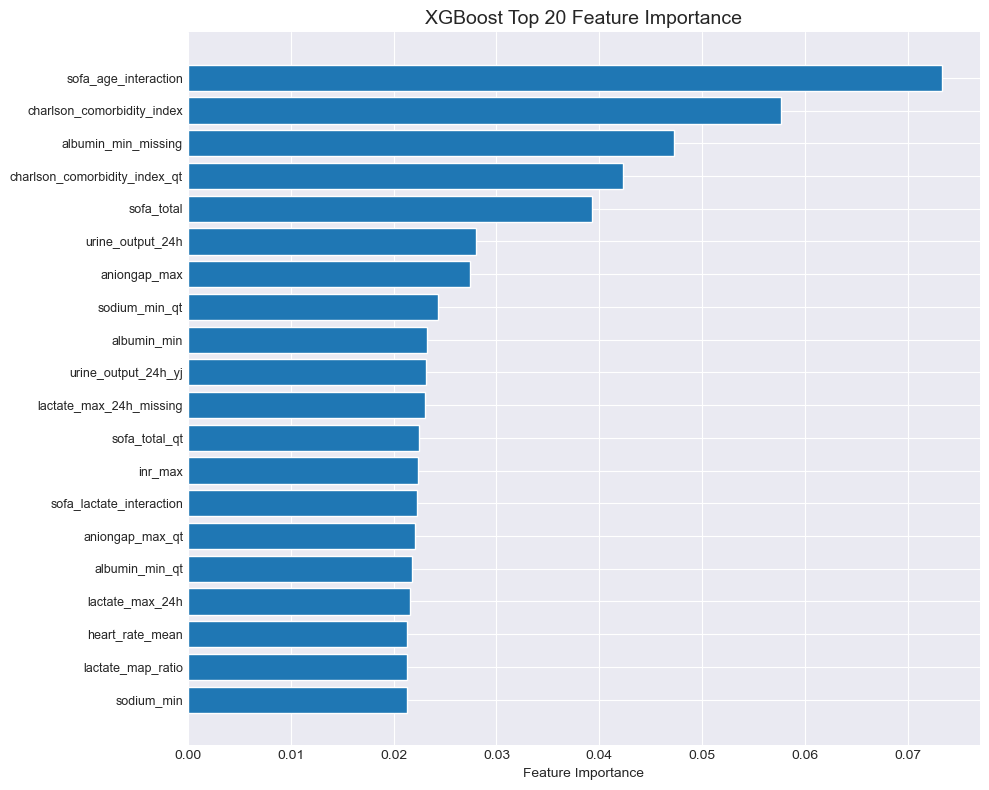

In [176]:
print("\n[Step 3] Advanced Models (XGBoost, LightGBM, RandomForest)")
print("-" * 80)

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,
    force_col_wise=True
)

lgb_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate XGBoost
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb, "Test")

# Evaluate LightGBM
y_test_pred_lgb = lgb_model.predict(X_test)
y_test_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
lgb_test_metrics = evaluate_model(y_test, y_test_pred_lgb, y_test_proba_lgb, "Test")

# Evaluate Random Forest
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf, "Test")

print("XGBoost Performance:")
print(f"  Test - AUC: {xgb_test_metrics['AUC']:.4f}, AUPRC: {xgb_test_metrics['AUPRC']:.4f}, Brier: {xgb_test_metrics['Brier']:.4f}")
print("LightGBM Performance:")
print(f"  Test - AUC: {lgb_test_metrics['AUC']:.4f}, AUPRC: {lgb_test_metrics['AUPRC']:.4f}, Brier: {lgb_test_metrics['Brier']:.4f}")
print("Random Forest Performance:")
print(f"  Test - AUC: {rf_test_metrics['AUC']:.4f}, AUPRC: {rf_test_metrics['AUPRC']:.4f}, Brier: {rf_test_metrics['Brier']:.4f}")

# 5-fold Cross-Validation
print("\n5-fold Cross-Validation:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_cv_auc = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_cv_auprc = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)

lgb_cv_auc = cross_val_score(lgb_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
lgb_cv_auprc = cross_val_score(lgb_model, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)

print(f"  XGBoost CV AUC: {xgb_cv_auc.mean():.4f} (±{xgb_cv_auc.std():.4f})")
print(f"  XGBoost CV AUPRC: {xgb_cv_auprc.mean():.4f} (±{xgb_cv_auprc.std():.4f})")
print(f"  LightGBM CV AUC: {lgb_cv_auc.mean():.4f} (±{lgb_cv_auc.std():.4f})")
print(f"  LightGBM CV AUPRC: {lgb_cv_auprc.mean():.4f} (±{lgb_cv_auprc.std():.4f})")

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 XGBoost Feature Importance:")
print(xgb_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = xgb_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'].values[::-1])
plt.yticks(range(len(top_features)), top_features['Feature'].values[::-1], fontsize=9)
plt.xlabel('Feature Importance')
plt.title('XGBoost Top 20 Feature Importance', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATHS['visualizations'] / 'xgb_feature_importance.png', dpi=300, bbox_inches='tight')
print(f"[OK] Saved: {OUTPUT_PATHS['visualizations'] / 'xgb_feature_importance.png'}")
plt.show()
plt.close()

# ROC and PR curves for advanced models
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_test_proba_lgb)
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_test_proba_lgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)

## Step 4: Model Ensemble (Stacking)

In [147]:
print("\n[Step 4] Model Ensemble (Stacking)")
print("-" * 80)

# Stacking ensemble (LR, XGBoost, LightGBM)
# Note: LR needs a pipeline to handle NaN (lactate), while XGBoost and LightGBM can handle NaN natively
from sklearn.pipeline import Pipeline

lr_pipeline_for_stacking = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', C=0.5, max_iter=1000, random_state=42))
])

base_estimators = [
    ('lr', lr_pipeline_for_stacking),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.05, max_depth=5, 
                              n_estimators=300, random_state=42, eval_metric='logloss', use_label_encoder=False)),
    ('lgb', lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.05, max_depth=5,
                               n_estimators=300, random_state=42, verbosity=-1, force_col_wise=True))
]

# Final estimator also needs to handle NaN from meta features
final_estimator_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('lr', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator_pipeline,
    cv=5
)

stacking_model.fit(X_train, y_train)

y_test_pred_stack = stacking_model.predict(X_test)
y_test_proba_stack = stacking_model.predict_proba(X_test)[:, 1]
stack_test_metrics = evaluate_model(y_test, y_test_pred_stack, y_test_proba_stack, "Test")

print("Stacking Ensemble Performance:")
print(f"  Test - AUC: {stack_test_metrics['AUC']:.4f}, AUPRC: {stack_test_metrics['AUPRC']:.4f}, Brier: {stack_test_metrics['Brier']:.4f}")

fpr_stack, tpr_stack, _ = roc_curve(y_test, y_test_proba_stack)
precision_stack, recall_stack, _ = precision_recall_curve(y_test, y_test_proba_stack)


[Step 4] Model Ensemble (Stacking)
--------------------------------------------------------------------------------
Stacking Ensemble Performance:
  Test - AUC: 0.7998, AUPRC: 0.5728, Brier: 0.1838


## Step 5: Model Calibration


[Step 5] Model Calibration
--------------------------------------------------------------------------------

Logistic Regression Calibration:
  Original Brier Score: 0.1852
  Platt Scaling Brier: 0.1415
  Isotonic Brier: 0.1423

XGBoost Calibration:
  Original Brier Score: 0.1664
  Platt Scaling Brier: 0.1432
  Isotonic Brier: 0.1427

LightGBM Calibration:
  Original Brier Score: 0.1681
  Platt Scaling Brier: 0.1421
  Isotonic Brier: 0.1416

Random Forest Calibration:
  Original Brier Score: 0.1613
  Platt Scaling Brier: 0.1401
  Isotonic Brier: 0.1410

Stacking Ensemble Calibration:
  Original Brier Score: 0.1838
  Platt Scaling Brier: 0.1382
  Isotonic Brier: 0.1387

[OK] Saved panel: /Users/zixuanhe/Desktop/ML4H/Final_code/output/calibration/calibration_panel_3x3.png


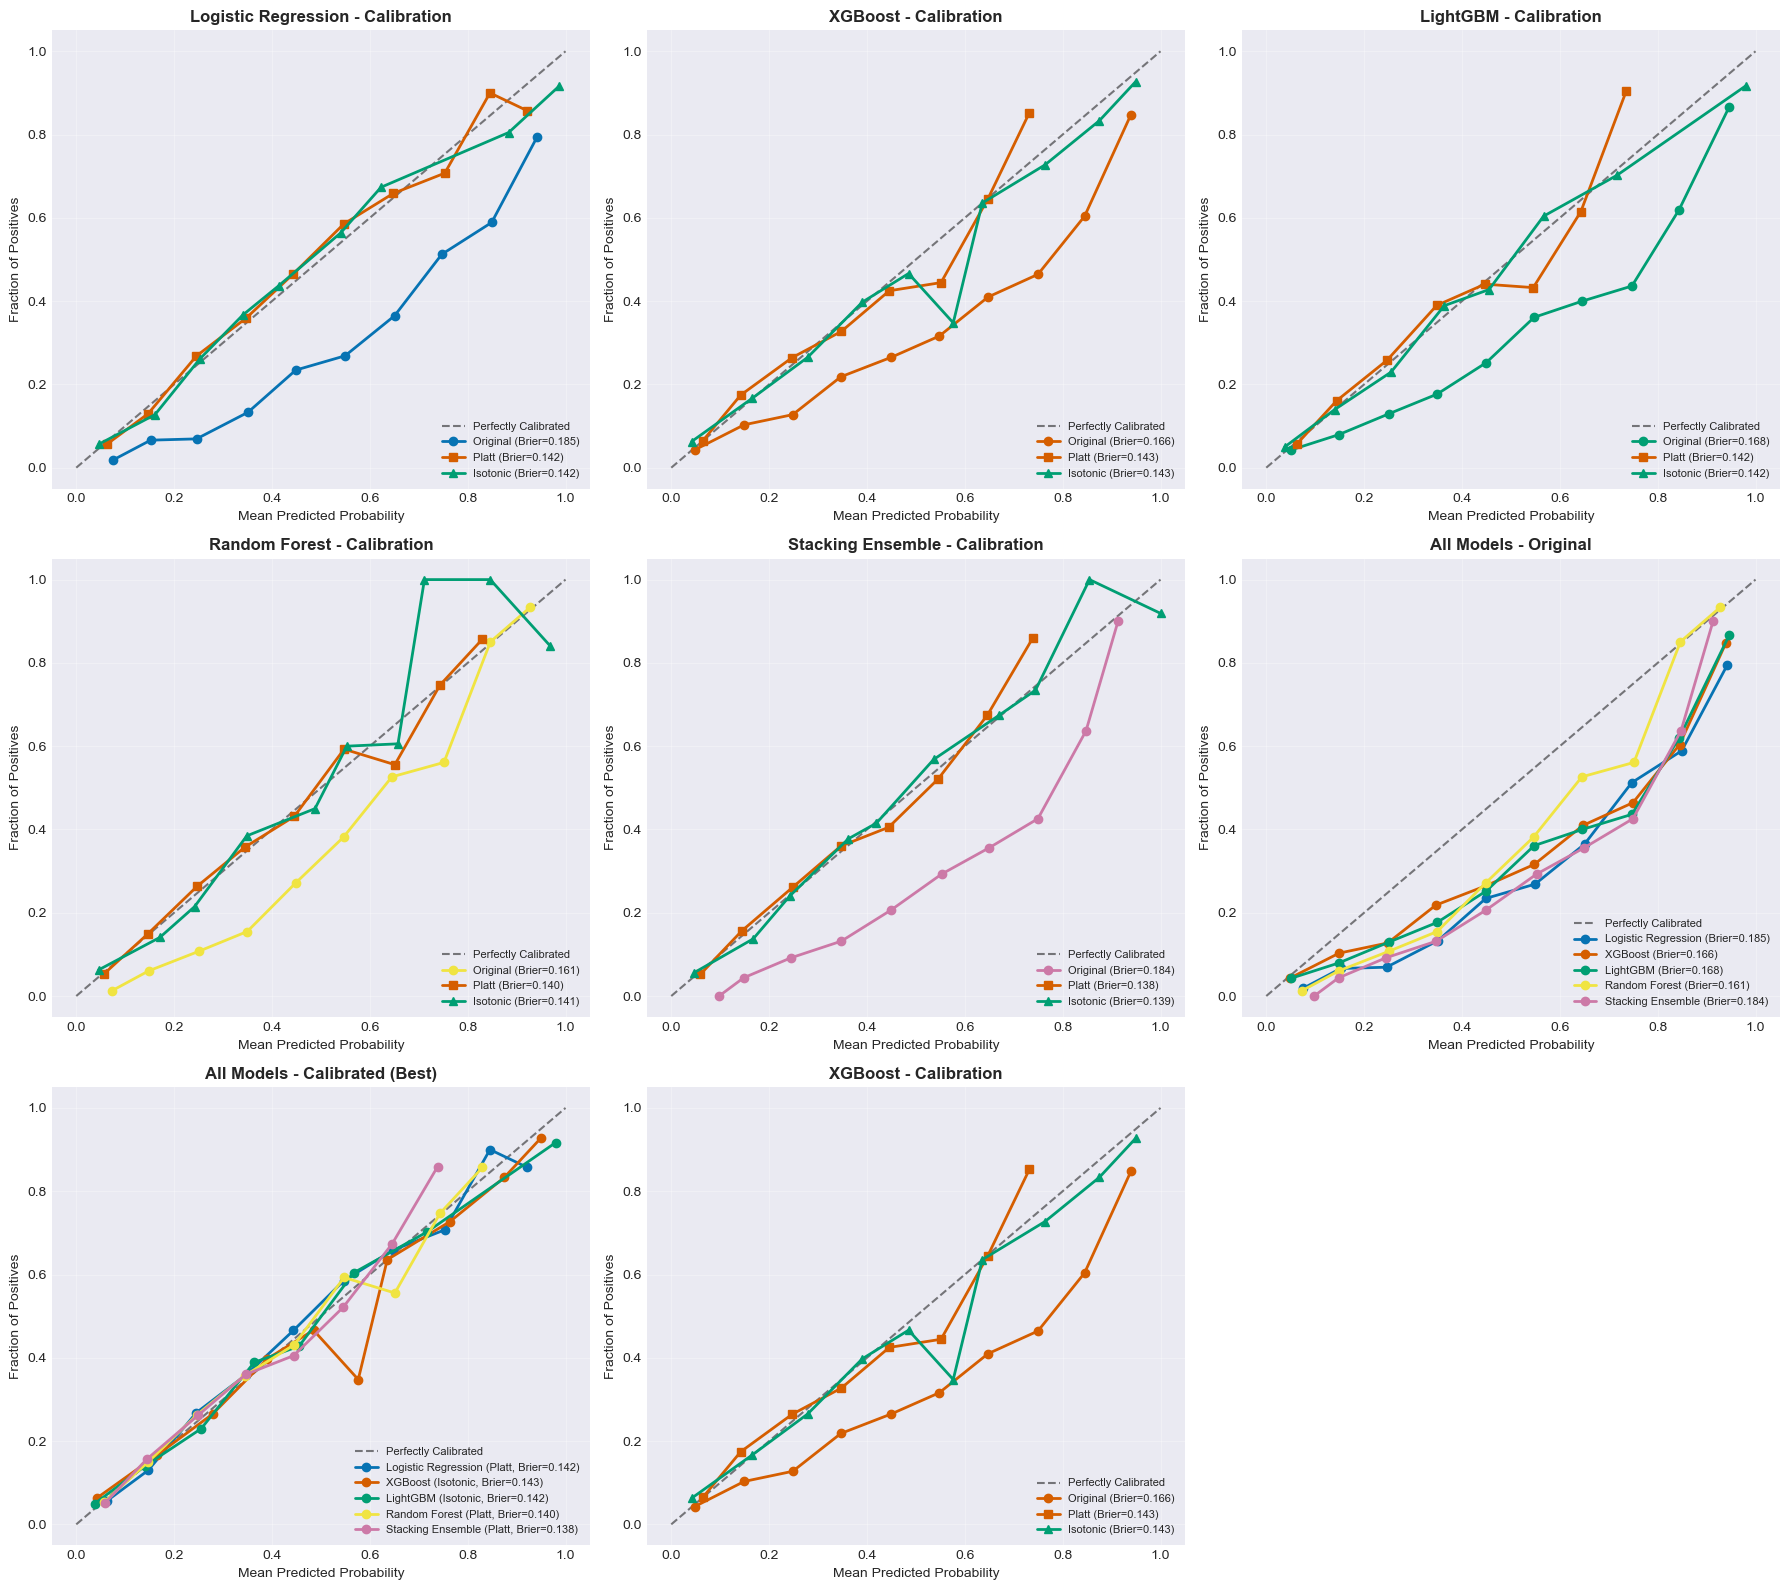

In [177]:
# --- Step 5: Model Calibration (render & save ONE 3x3 panel) ---

import os
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

print("\n[Step 5] Model Calibration")
print("-" * 80)

# Ensure output directory exists
os.makedirs(OUTPUT_PATHS['calibration'], exist_ok=True)

# Define all models and their prediction probabilities
models_dict = {
    'Logistic Regression': {
        'model': lr_model,
        'proba': y_test_proba_lr,
        'X_train': X_train_lr,
        'X_val': X_val_lr,
        'X_test': X_test_lr,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'needs_pipeline': True
    },
    'XGBoost': {
        'model': xgb_model,
        'proba': y_test_proba_xgb,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'needs_pipeline': False
    },
    'LightGBM': {
        'model': lgb_model,
        'proba': y_test_proba_lgb,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'needs_pipeline': False
    },
    'Random Forest': {
        'model': rf_model,
        'proba': y_test_proba_rf,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'needs_pipeline': False
    },
    'Stacking Ensemble': {
        'model': stacking_model,
        'proba': y_test_proba_stack,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'needs_pipeline': False
    }
}

# Color palette for plots
colors = {
    'Logistic Regression': COLOR_PALETTE.get('survived', '#1f77b4'),
    'XGBoost': COLOR_PALETTE.get('died', '#d62728'),
    'LightGBM': '#009E73',
    'Random Forest': '#F0E442',
    'Stacking Ensemble': '#CC79A7'
}

# Prepare a single 3x3 panel
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes_flat = axes.ravel()

# Generate calibration plots for all models (draw per-model in first 5 cells)
calibration_results = {}
best_model = None
best_proba = None
best_brier = float('inf')
calibration_method = None

model_names = list(models_dict.keys())

for i, (model_name, model_info) in enumerate(models_dict.items()):
    ax = axes_flat[i]
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Perfectly Calibrated')

    print(f"\n{model_name} Calibration:")

    # Get original prediction probabilities
    y_proba_orig = model_info['proba']
    brier_orig = brier_score_loss(model_info['y_test'], y_proba_orig)

    try:
        # Platt Scaling
        calibrated_platt = CalibratedClassifierCV(model_info['model'], method='sigmoid', cv='prefit')
        calibrated_platt.fit(model_info['X_val'], model_info['y_val'])
        y_proba_platt = calibrated_platt.predict_proba(model_info['X_test'])[:, 1]
        brier_platt = brier_score_loss(model_info['y_test'], y_proba_platt)

        # Isotonic Regression
        calibrated_isotonic = CalibratedClassifierCV(model_info['model'], method='isotonic', cv='prefit')
        calibrated_isotonic.fit(model_info['X_val'], model_info['y_val'])
        y_proba_isotonic = calibrated_isotonic.predict_proba(model_info['X_test'])[:, 1]
        brier_isotonic = brier_score_loss(model_info['y_test'], y_proba_isotonic)

        print(f"  Original Brier Score: {brier_orig:.4f}")
        print(f"  Platt Scaling Brier: {brier_platt:.4f}")
        print(f"  Isotonic Brier: {brier_isotonic:.4f}")

        # Curves
        frac_pos_orig, mean_pred_orig = calibration_curve(model_info['y_test'], y_proba_orig, n_bins=10)
        frac_pos_platt, mean_pred_platt = calibration_curve(model_info['y_test'], y_proba_platt, n_bins=10)
        frac_pos_isotonic, mean_pred_isotonic = calibration_curve(model_info['y_test'], y_proba_isotonic, n_bins=10)

        # Draw on the panel subplot
        ax.plot(mean_pred_orig, frac_pos_orig, 'o-', linewidth=2, markersize=6,
                label=f'Original (Brier={brier_orig:.3f})',
                color=colors.get(model_name, '#000000'))
        ax.plot(mean_pred_platt, frac_pos_platt, 's-', linewidth=2, markersize=6,
                label=f'Platt (Brier={brier_platt:.3f})',
                color='#d55e00')
        ax.plot(mean_pred_isotonic, frac_pos_isotonic, '^-', linewidth=2, markersize=6,
                label=f'Isotonic (Brier={brier_isotonic:.3f})',
                color='#009E73')

        # Save results for later combined plots
        calibration_results[model_name] = {
            'original': (frac_pos_orig, mean_pred_orig, brier_orig),
            'platt': (frac_pos_platt, mean_pred_platt, brier_platt),
            'isotonic': (frac_pos_isotonic, mean_pred_isotonic, brier_isotonic),
            'calibrated_platt': calibrated_platt,
            'calibrated_isotonic': calibrated_isotonic,
            'y_proba_platt': y_proba_platt,
            'y_proba_isotonic': y_proba_isotonic
        }

        # Update best model tracker
        if brier_isotonic < best_brier:
            best_brier = brier_isotonic
            best_model = calibrated_isotonic
            best_proba = y_proba_isotonic
            calibration_method = f"{model_name} - Isotonic"
        if brier_platt < best_brier:
            best_brier = brier_platt
            best_model = calibrated_platt
            best_proba = y_proba_platt
            calibration_method = f"{model_name} - Platt"

    except Exception as e:
        print(f"  Warning: Calibration failed for {model_name}: {e}")
        # At least draw original
        frac_pos_orig, mean_pred_orig = calibration_curve(model_info['y_test'], y_proba_orig, n_bins=10)
        ax.plot(mean_pred_orig, frac_pos_orig, 'o-', linewidth=2, markersize=6,
                label=f'Original (Brier={brier_orig:.3f})',
                color=colors.get(model_name, '#000000'))

    ax.set_xlabel('Mean Predicted Probability', fontsize=10)
    ax.set_ylabel('Fraction of Positives', fontsize=10)
    ax.set_title(f'{model_name} - Calibration', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='lower right')

# Cell 6: All Models - Original
ax_all_orig = axes_flat[5]
ax_all_orig.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Perfectly Calibrated')
for model_name, model_info in models_dict.items():
    y_proba = model_info['proba']
    brier = brier_score_loss(model_info['y_test'], y_proba)
    frac_pos, mean_pred = calibration_curve(model_info['y_test'], y_proba, n_bins=10)
    ax_all_orig.plot(mean_pred, frac_pos, 'o-', linewidth=2, markersize=6,
                     label=f'{model_name} (Brier={brier:.3f})',
                     color=colors.get(model_name, '#000000'))
ax_all_orig.set_xlabel('Mean Predicted Probability', fontsize=10)
ax_all_orig.set_ylabel('Fraction of Positives', fontsize=10)
ax_all_orig.set_title('All Models - Original', fontsize=12, fontweight='bold')
ax_all_orig.grid(True, alpha=0.3)
ax_all_orig.legend(fontsize=8, loc='lower right')

# Cell 7: All Models - Best of (Isotonic vs Platt)
ax_all_cal = axes_flat[6]
ax_all_cal.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Perfectly Calibrated')
for model_name, result in calibration_results.items():
    if result['isotonic'][2] <= result['platt'][2]:
        frac_pos, mean_pred, brier = result['isotonic']
        method = 'Isotonic'
    else:
        frac_pos, mean_pred, brier = result['platt']
        method = 'Platt'
    ax_all_cal.plot(mean_pred, frac_pos, 'o-', linewidth=2, markersize=6,
                    label=f'{model_name} ({method}, Brier={brier:.3f})',
                    color=colors.get(model_name, '#000000'))
ax_all_cal.set_xlabel('Mean Predicted Probability', fontsize=10)
ax_all_cal.set_ylabel('Fraction of Positives', fontsize=10)
ax_all_cal.set_title('All Models - Calibrated (Best)', fontsize=12, fontweight='bold')
ax_all_cal.grid(True, alpha=0.3)
ax_all_cal.legend(fontsize=8, loc='lower right')

# Cell 8: XGBoost standalone (back-compat)
ax_xgb = axes_flat[7]
ax_xgb.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Perfectly Calibrated')
if 'XGBoost' in calibration_results:
    r = calibration_results['XGBoost']
    # unpack for safer f-string usage
    fpo, mpo, bo = r['original']
    fpp, mpp, bp = r['platt']
    fpi, mpi, bi = r['isotonic']
    ax_xgb.plot(mpo, fpo, 'o-', linewidth=2, markersize=6,
                label=f'Original (Brier={bo:.3f})', color=colors.get('XGBoost', '#000000'))
    ax_xgb.plot(mpp, fpp, 's-', linewidth=2, markersize=6,
                label=f'Platt (Brier={bp:.3f})', color='#d55e00')
    ax_xgb.plot(mpi, fpi, '^-', linewidth=2, markersize=6,
                label=f'Isotonic (Brier={bi:.3f})', color='#009E73')
    ax_xgb.set_title('XGBoost - Calibration', fontsize=12, fontweight='bold')
else:
    ax_xgb.text(0.5, 0.5, 'XGBoost results unavailable', ha='center', va='center')
    ax_xgb.set_title('XGBoost - Calibration', fontsize=12, fontweight='bold')
ax_xgb.set_xlabel('Mean Predicted Probability', fontsize=10)
ax_xgb.set_ylabel('Fraction of Positives', fontsize=10)
ax_xgb.grid(True, alpha=0.3)
ax_xgb.legend(fontsize=8, loc='lower right')

# Cell 9: empty / hidden
axes_flat[8].axis('off')

plt.tight_layout()
panel_path = OUTPUT_PATHS['calibration'] / 'calibration_panel_3x3.png'
plt.savefig(panel_path, dpi=300, bbox_inches='tight')
print(f"\n[OK] Saved panel: {panel_path}")
plt.show()
plt.close()

## Step 6: SHAP Interpretability Analysis


[Step 6] SHAP Interpretability Analysis
--------------------------------------------------------------------------------
Computing SHAP values (this may take a few minutes)...


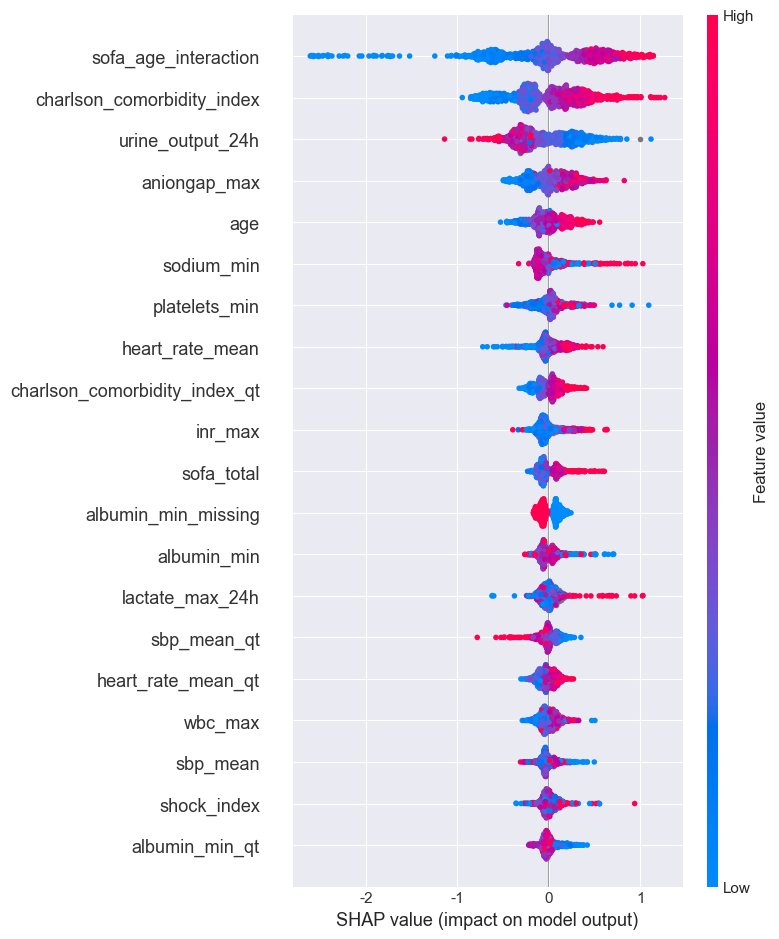

[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/interpretability/shap_summary_plot.png

Top 20 SHAP Feature Importance:


Feature  SHAP_Importance
38           sofa_age_interaction         0.476470
13     charlson_comorbidity_index         0.326169
9                urine_output_24h         0.276577
16                   aniongap_max         0.171236
0                             age         0.133838
6                      sodium_min         0.111079
7                   platelets_min         0.107111
3                 heart_rate_mean         0.105935
34  charlson_comorbidity_index_qt         0.101842
15                        inr_max         0.098853
14                     sofa_total         0.094340
17            albumin_min_missing         0.090571
12                    albumin_min         0.079572
5                 lactate_max_24h         0.075773
30                    sbp_mean_qt         0.072272
31             heart_rate_mean_qt         0.070319
4                         wbc_max         0.069958
2                        sbp_mean         0.064945
40                    shock_index         0.063304
33                 albumin_min_qt         0.061273

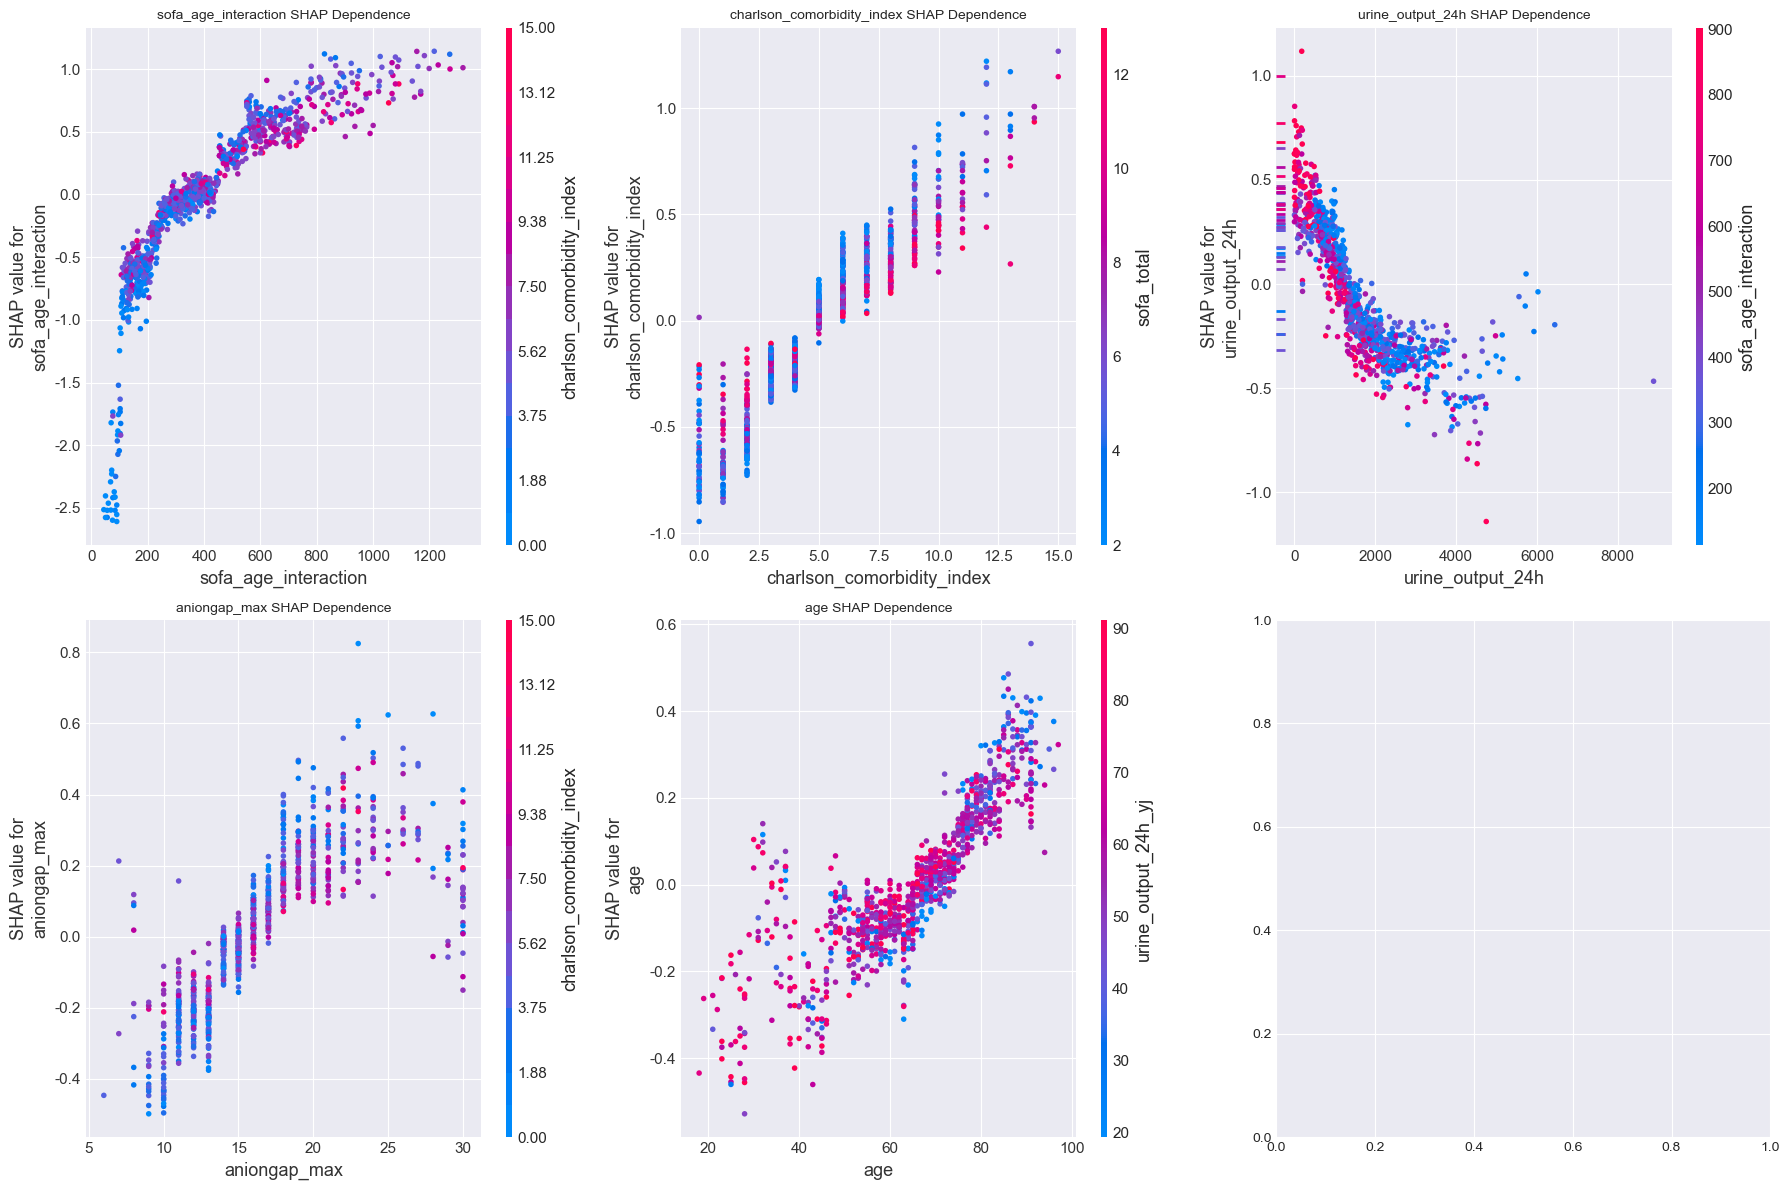

[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/interpretability/shap_dependence_plots.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/interpretability/shap_feature_importance.csv


In [151]:
print("\n[Step 6] SHAP Interpretability Analysis")
print("-" * 80)

print("Computing SHAP values (this may take a few minutes)...")

# Choose best tree-based model for SHAP explainability
best_tree_model = xgb_model if xgb_test_metrics['AUC'] >= lgb_test_metrics['AUC'] else lgb_model
explainer = shap.TreeExplainer(best_tree_model)
shap_values = explainer.shap_values(X_test[:1000])  # sample to reduce compute

# --- SHAP Summary Plot ---
shap.summary_plot(shap_values, X_test.iloc[:1000], show=False, max_display=20)
plt.tight_layout()
plt.savefig(OUTPUT_PATHS['interpretability'] / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()        # <-- render in notebook
plt.close()
print(f"[OK] Saved: {OUTPUT_PATHS['interpretability'] / 'shap_summary_plot.png'}")

# --- SHAP Feature Importance Table ---
shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance': np.abs(shap_values).mean(0)
}).sort_values('SHAP_Importance', ascending=False)

print("\nTop 20 SHAP Feature Importance:")
display(shap_importance.head(20))

# --- SHAP Dependence Plots for Top Features ---
top_shap_features = shap_importance.head(5)['Feature'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_shap_features[:6]):
    shap.dependence_plot(
        feature, shap_values, X_test.iloc[:1000], 
        ax=axes[idx], show=False
    )
    axes[idx].set_title(f'{feature} SHAP Dependence', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_PATHS['interpretability'] / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()        # <-- render in notebook
plt.close()
print(f"[OK] Saved: {OUTPUT_PATHS['interpretability'] / 'shap_dependence_plots.png'}")

# --- Save Importance Table ---
shap_importance.to_csv(OUTPUT_PATHS['interpretability'] / 'shap_feature_importance.csv', index=False)
print(f"[OK] Saved: {OUTPUT_PATHS['interpretability'] / 'shap_feature_importance.csv'}")

## Step 7: Subgroup Analysis

In [152]:
print("\n[Step 7] Subgroup Analysis")
print("-" * 80)

# Reconstruct original infection source for subgroup analysis
# Check if infection_source columns exist
infection_cols = [col for col in X.columns if 'infection_source' in col]
if infection_cols:
    # Create infection_source variable
    X_test_with_source = X_test.copy()
    source_mapping = {}
    for col in infection_cols:
        source_name = col.replace('infection_source_', '')
        source_mapping[col] = source_name
    
    # Determine primary infection source
    X_test_with_source['infection_source'] = X_test_with_source[infection_cols].idxmax(axis=1)
    X_test_with_source['infection_source'] = X_test_with_source['infection_source'].map(source_mapping)
else:
    X_test_with_source = X_test.copy()
    X_test_with_source['infection_source'] = 'unknown'

# Age subgroup
X_test_with_source['age_group'] = X_test_with_source['age'].apply(
    lambda x: '≥65' if x >= 65 else '<65'
)

subgroup_results = []

# Age subgroups
for age_group in ['≥65', '<65']:
    mask = X_test_with_source['age_group'] == age_group
    if mask.sum() > 0:
        y_subgroup = y_test[mask]
        proba_subgroup = best_proba[mask]
        pred_subgroup = (proba_subgroup >= 0.5).astype(int)
        
        auc = roc_auc_score(y_subgroup, proba_subgroup)
        recall = recall_score(y_subgroup, pred_subgroup)
        auprc = average_precision_score(y_subgroup, proba_subgroup)
        
        subgroup_results.append({
            'Subgroup': f'Age {age_group}',
            'N': int(mask.sum()),
            'Events': int(y_subgroup.sum()),
            'AUC': f"{auc:.4f}",
            'AUPRC': f"{auprc:.4f}",
            'Recall': f"{recall:.4f}"
        })

# Infection source subgroups
unique_sources = X_test_with_source['infection_source'].unique()
for source in unique_sources:
    if pd.notna(source) and source != 'unknown':
        mask = X_test_with_source['infection_source'] == source
        if mask.sum() > 10:  # Minimum sample size
            y_subgroup = y_test[mask]
            proba_subgroup = best_proba[mask]
            pred_subgroup = (proba_subgroup >= 0.5).astype(int)
            
            auc = roc_auc_score(y_subgroup, proba_subgroup)
            recall = recall_score(y_subgroup, pred_subgroup)
            auprc = average_precision_score(y_subgroup, proba_subgroup)
            
            subgroup_results.append({
                'Subgroup': f'Infection: {source}',
                'N': int(mask.sum()),
                'Events': int(y_subgroup.sum()),
                'AUC': f"{auc:.4f}",
                'AUPRC': f"{auprc:.4f}",
                'Recall': f"{recall:.4f}"
            })

subgroup_df = pd.DataFrame(subgroup_results)
print("\nSubgroup Performance:")
print(subgroup_df.to_string(index=False))
subgroup_df.to_csv(OUTPUT_PATHS['metrics'] / 'subgroup_performance_table.csv', index=False)
print(f"[OK] Saved: {OUTPUT_PATHS['metrics'] / 'subgroup_performance_table.csv'}")


[Step 7] Subgroup Analysis
--------------------------------------------------------------------------------

Subgroup Performance:
Subgroup    N  Events    AUC  AUPRC Recall
 Age ≥65 1680     450 0.7765 0.5860 0.3689
 Age <65 1379     256 0.8189 0.5508 0.3125
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/logs/modeling/subgroup_performance_table.csv


## Step 8: Final Results and Export

--------------------------------------------------------------------------------

Model Performance Summary:


Set     AUC   AUPRC Accuracy  Recall Precision      F1      F2   Brier  \
0  Test  0.7878  0.5443   0.7189  0.6997    0.4326  0.5346  0.6228  0.1852   
1  Test  0.7850  0.5489   0.7460  0.6161    0.4623  0.5282  0.5777  0.1664   
2  Test  0.7885  0.5517   0.7480  0.6459    0.4667  0.5419  0.5998  0.1681   
3  Test  0.7957  0.5550   0.7666  0.5850    0.4952  0.5364  0.5645  0.1613   
4  Test  0.7998  0.5728   0.7234  0.7422    0.4411  0.5533  0.6530  0.1838   

                 Model  
0  Logistic Regression  
1              XGBoost  
2             LightGBM  
3        Random Forest  
4    Stacking Ensemble

[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/logs/modeling/model_performance_summary.csv
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/roc_pr_curves.png


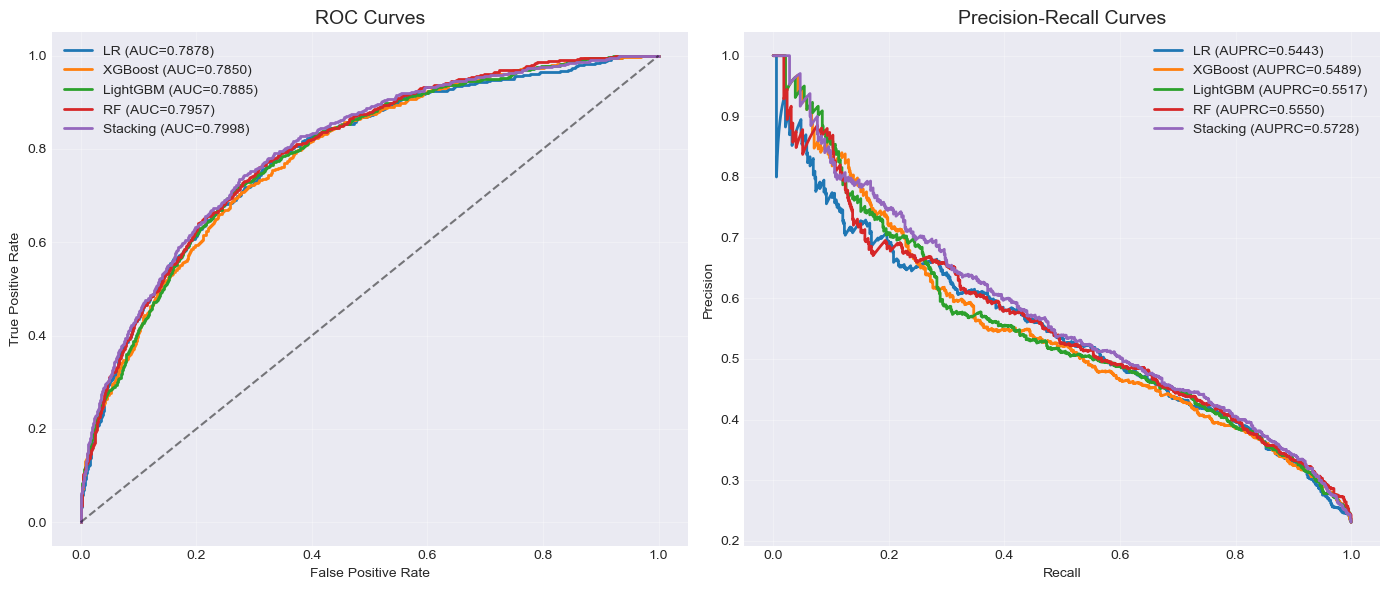

[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/models/best_sepsis_model.pkl


In [155]:
print("-" * 80)

# Compile all model performance (convert metrics to formatted strings for display)
performance_summary = pd.DataFrame([
    {**{k: f"{v:.4f}" if isinstance(v, (int, float)) else v for k, v in lr_test_metrics.items()}, 'Model': 'Logistic Regression'},
    {**{k: f"{v:.4f}" if isinstance(v, (int, float)) else v for k, v in xgb_test_metrics.items()}, 'Model': 'XGBoost'},
    {**{k: f"{v:.4f}" if isinstance(v, (int, float)) else v for k, v in lgb_test_metrics.items()}, 'Model': 'LightGBM'},
    {**{k: f"{v:.4f}" if isinstance(v, (int, float)) else v for k, v in rf_test_metrics.items()}, 'Model': 'Random Forest'},
    {**{k: f"{v:.4f}" if isinstance(v, (int, float)) else v for k, v in stack_test_metrics.items()}, 'Model': 'Stacking Ensemble'}
])

print("\nModel Performance Summary:")
display(performance_summary)
performance_summary.to_csv(OUTPUT_PATHS['metrics'] / 'model_performance_summary.csv', index=False)
print(f"[OK] Saved: {OUTPUT_PATHS['metrics'] / 'model_performance_summary.csv'}")

# ROC and PR Curves
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_test_metrics["AUC"]:.4f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_test_metrics["AUC"]:.4f})', linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={lgb_test_metrics["AUC"]:.4f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_test_metrics["AUC"]:.4f})', linewidth=2)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC={stack_test_metrics["AUC"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, label=f'LR (AUPRC={lr_test_metrics["AUPRC"]:.4f})', linewidth=2)
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUPRC={xgb_test_metrics["AUPRC"]:.4f})', linewidth=2)
plt.plot(recall_lgb, precision_lgb, label=f'LightGBM (AUPRC={lgb_test_metrics["AUPRC"]:.4f})', linewidth=2)
plt.plot(recall_rf, precision_rf, label=f'RF (AUPRC={rf_test_metrics["AUPRC"]:.4f})', linewidth=2)
plt.plot(recall_stack, precision_stack, label=f'Stacking (AUPRC={stack_test_metrics["AUPRC"]:.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATHS['visualizations'] / 'roc_pr_curves.png', dpi=300, bbox_inches='tight')
print(f"[OK] Saved: {OUTPUT_PATHS['visualizations'] / 'roc_pr_curves.png'}")
plt.show()     # <-- RENDER IN NOTEBOOK
plt.close()

# Save best model
joblib.dump(best_model, OUTPUT_PATHS['models'] / 'best_sepsis_model.pkl')
print(f"[OK] Saved: {OUTPUT_PATHS['models'] / 'best_sepsis_model.pkl'}")

## Step 9: Threshold-based Evaluation, Confusion Matrices, and DCA

In [156]:
print("\n[Step 9] Threshold-based Evaluation, Confusion Matrices, and DCA")
print("-" * 80)

# Configuration: thresholds for evaluation and default threshold for confusion matrix
EVALUATION_THRESHOLDS = np.arange(0.2, 0.51, 0.01).tolist()  # 0.2 to 0.5 with step 0.01
DEFAULT_THRESHOLD = 0.35  # Default threshold for confusion matrix (middle of range)

print(f"\nEvaluating all models at thresholds: {len(EVALUATION_THRESHOLDS)} thresholds from {EVALUATION_THRESHOLDS[0]:.2f} to {EVALUATION_THRESHOLDS[-1]:.2f} (step=0.01)")
print(f"Threshold range: [{EVALUATION_THRESHOLDS[0]:.2f}, {EVALUATION_THRESHOLDS[-1]:.2f}]")
print("=" * 80)

# Prepare models for evaluation (using test set predictions from models_dict)
models_for_evaluation = {}
for model_name, model_info in models_dict.items():
    models_for_evaluation[model_name] = {
        'y_proba': model_info['proba'],
        'y_test': model_info['y_test']
    }


[Step 9] Threshold-based Evaluation, Confusion Matrices, and DCA
--------------------------------------------------------------------------------

Evaluating all models at thresholds: 31 thresholds from 0.20 to 0.50 (step=0.01)
Threshold range: [0.20, 0.50]


### 1. Calculate and print metrics at multiple thresholds

In [157]:
threshold_metrics_results = []
for model_name, model_data in models_for_evaluation.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    print(f"  Computing metrics for {len(EVALUATION_THRESHOLDS)} thresholds...")
    
    # Calculate metrics for all thresholds and store for this model
    model_metrics_list = []
    for threshold in EVALUATION_THRESHOLDS:
        metrics = evaluate_at_threshold(
            model_data['y_test'], 
            model_data['y_proba'], 
            threshold=threshold
        )
        metrics['Model'] = model_name
        model_metrics_list.append(metrics)
        threshold_metrics_results.append(metrics)
    
    # Print summary for key thresholds (0.2, 0.3, 0.35, 0.4, 0.5)
    key_thresholds = [0.2, 0.3, 0.35, 0.4, 0.5]
    print(f"  Summary for key thresholds:")
    for key_thresh in key_thresholds:
        # Find the closest threshold index (handle floating point precision)
        closest_idx = min(range(len(EVALUATION_THRESHOLDS)), 
                         key=lambda i: abs(EVALUATION_THRESHOLDS[i] - key_thresh))
        if abs(EVALUATION_THRESHOLDS[closest_idx] - key_thresh) < 0.001:
            if closest_idx < len(model_metrics_list):
                metrics = model_metrics_list[closest_idx]
                print(f"    Threshold={EVALUATION_THRESHOLDS[closest_idx]:.2f}: "
                      f"Spec={metrics['Specificity']:.3f}, "
                      f"NPV={metrics['NPV']:.3f}, "
                      f"Alert={metrics['Alert_Rate']:.3f}, "
                      f"PPV={metrics['Precision']:.3f}, "
                      f"Recall={metrics['Recall']:.3f}, "
                      f"F1={metrics['F1']:.3f}")
    
    print(f"  [All {len(EVALUATION_THRESHOLDS)} threshold results saved to CSV]")

# Save threshold metrics to CSV
threshold_metrics_df = pd.DataFrame(threshold_metrics_results)
threshold_metrics_df = threshold_metrics_df[['Model', 'Threshold', 'TP', 'TN', 'FP', 'FN', 
                                             'Accuracy', 'Precision', 'Recall', 'F1', 
                                             'Specificity', 'NPV', 'Alert_Rate']]
threshold_metrics_df.to_csv(OUTPUT_PATHS['metrics'] / 'threshold_metrics.csv', index=False)
print(f"\n[OK] Saved: {OUTPUT_PATHS['metrics'] / 'threshold_metrics.csv'}")


Logistic Regression:
--------------------------------------------------------------------------------
  Computing metrics for 31 thresholds...
  Summary for key thresholds:
    Threshold=0.20: Spec=0.261, NPV=0.946, Alert=0.788, PPV=0.279, Recall=0.950, F1=0.431
    Threshold=0.30: Spec=0.450, NPV=0.940, Alert=0.632, PPV=0.330, Recall=0.904, F1=0.484
    Threshold=0.35: Spec=0.521, NPV=0.928, Alert=0.568, PPV=0.352, Recall=0.865, F1=0.500
    Threshold=0.40: Spec=0.600, NPV=0.920, Alert=0.499, PPV=0.383, Recall=0.827, F1=0.523
    Threshold=0.50: Spec=0.725, NPV=0.889, Alert=0.373, PPV=0.433, Recall=0.700, F1=0.535
  [All 31 threshold results saved to CSV]

XGBoost:
--------------------------------------------------------------------------------
  Computing metrics for 31 thresholds...
  Summary for key thresholds:
    Threshold=0.20: Spec=0.451, NPV=0.934, Alert=0.628, PPV=0.328, Recall=0.894, F1=0.480
    Threshold=0.30: Spec=0.585, NPV=0.919, Alert=0.510, PPV=0.375, Recall=0.829, F

### 2. Plot confusion matrices for each model at default threshold


Creating 2×3 confusion matrix panel...


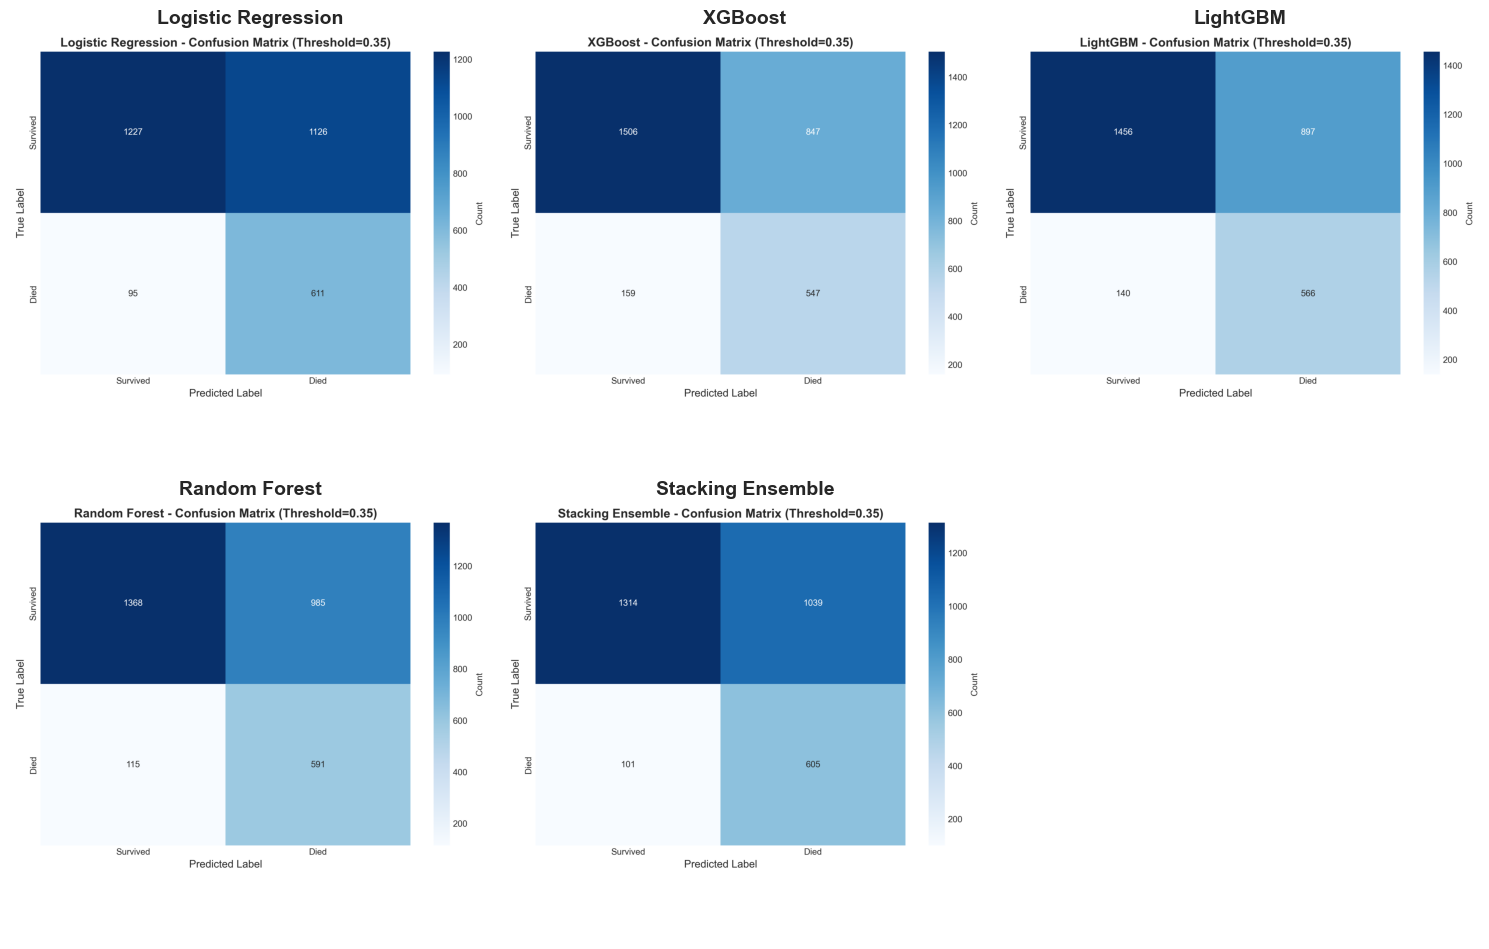

[OK] Saved panel: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/confusion_matrix_panel.png


In [167]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("\nCreating 2×3 confusion matrix panel...")

panel_images = []
panel_titles = []

for model_name, model_data in models_for_evaluation.items():
    safe_name = model_name.lower().replace(' ', '_')
    img_path = OUTPUT_PATHS['visualizations'] / f'confusion_matrix_{safe_name}.png'
    panel_images.append(img_path)
    panel_titles.append(model_name)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, img_path, title in zip(axes.flatten(), panel_images, panel_titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

if len(panel_images) < 6:
    for ax in axes.flatten()[len(panel_images):]:
        ax.axis('off')

plt.tight_layout()
panel_output = OUTPUT_PATHS['visualizations'] / "confusion_matrix_panel.png"
plt.savefig(panel_output, dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Saved panel: {panel_output}")

### 3. Plot DCA (Decision Curve Analysis)


Generating Decision Curve Analysis (DCA)...


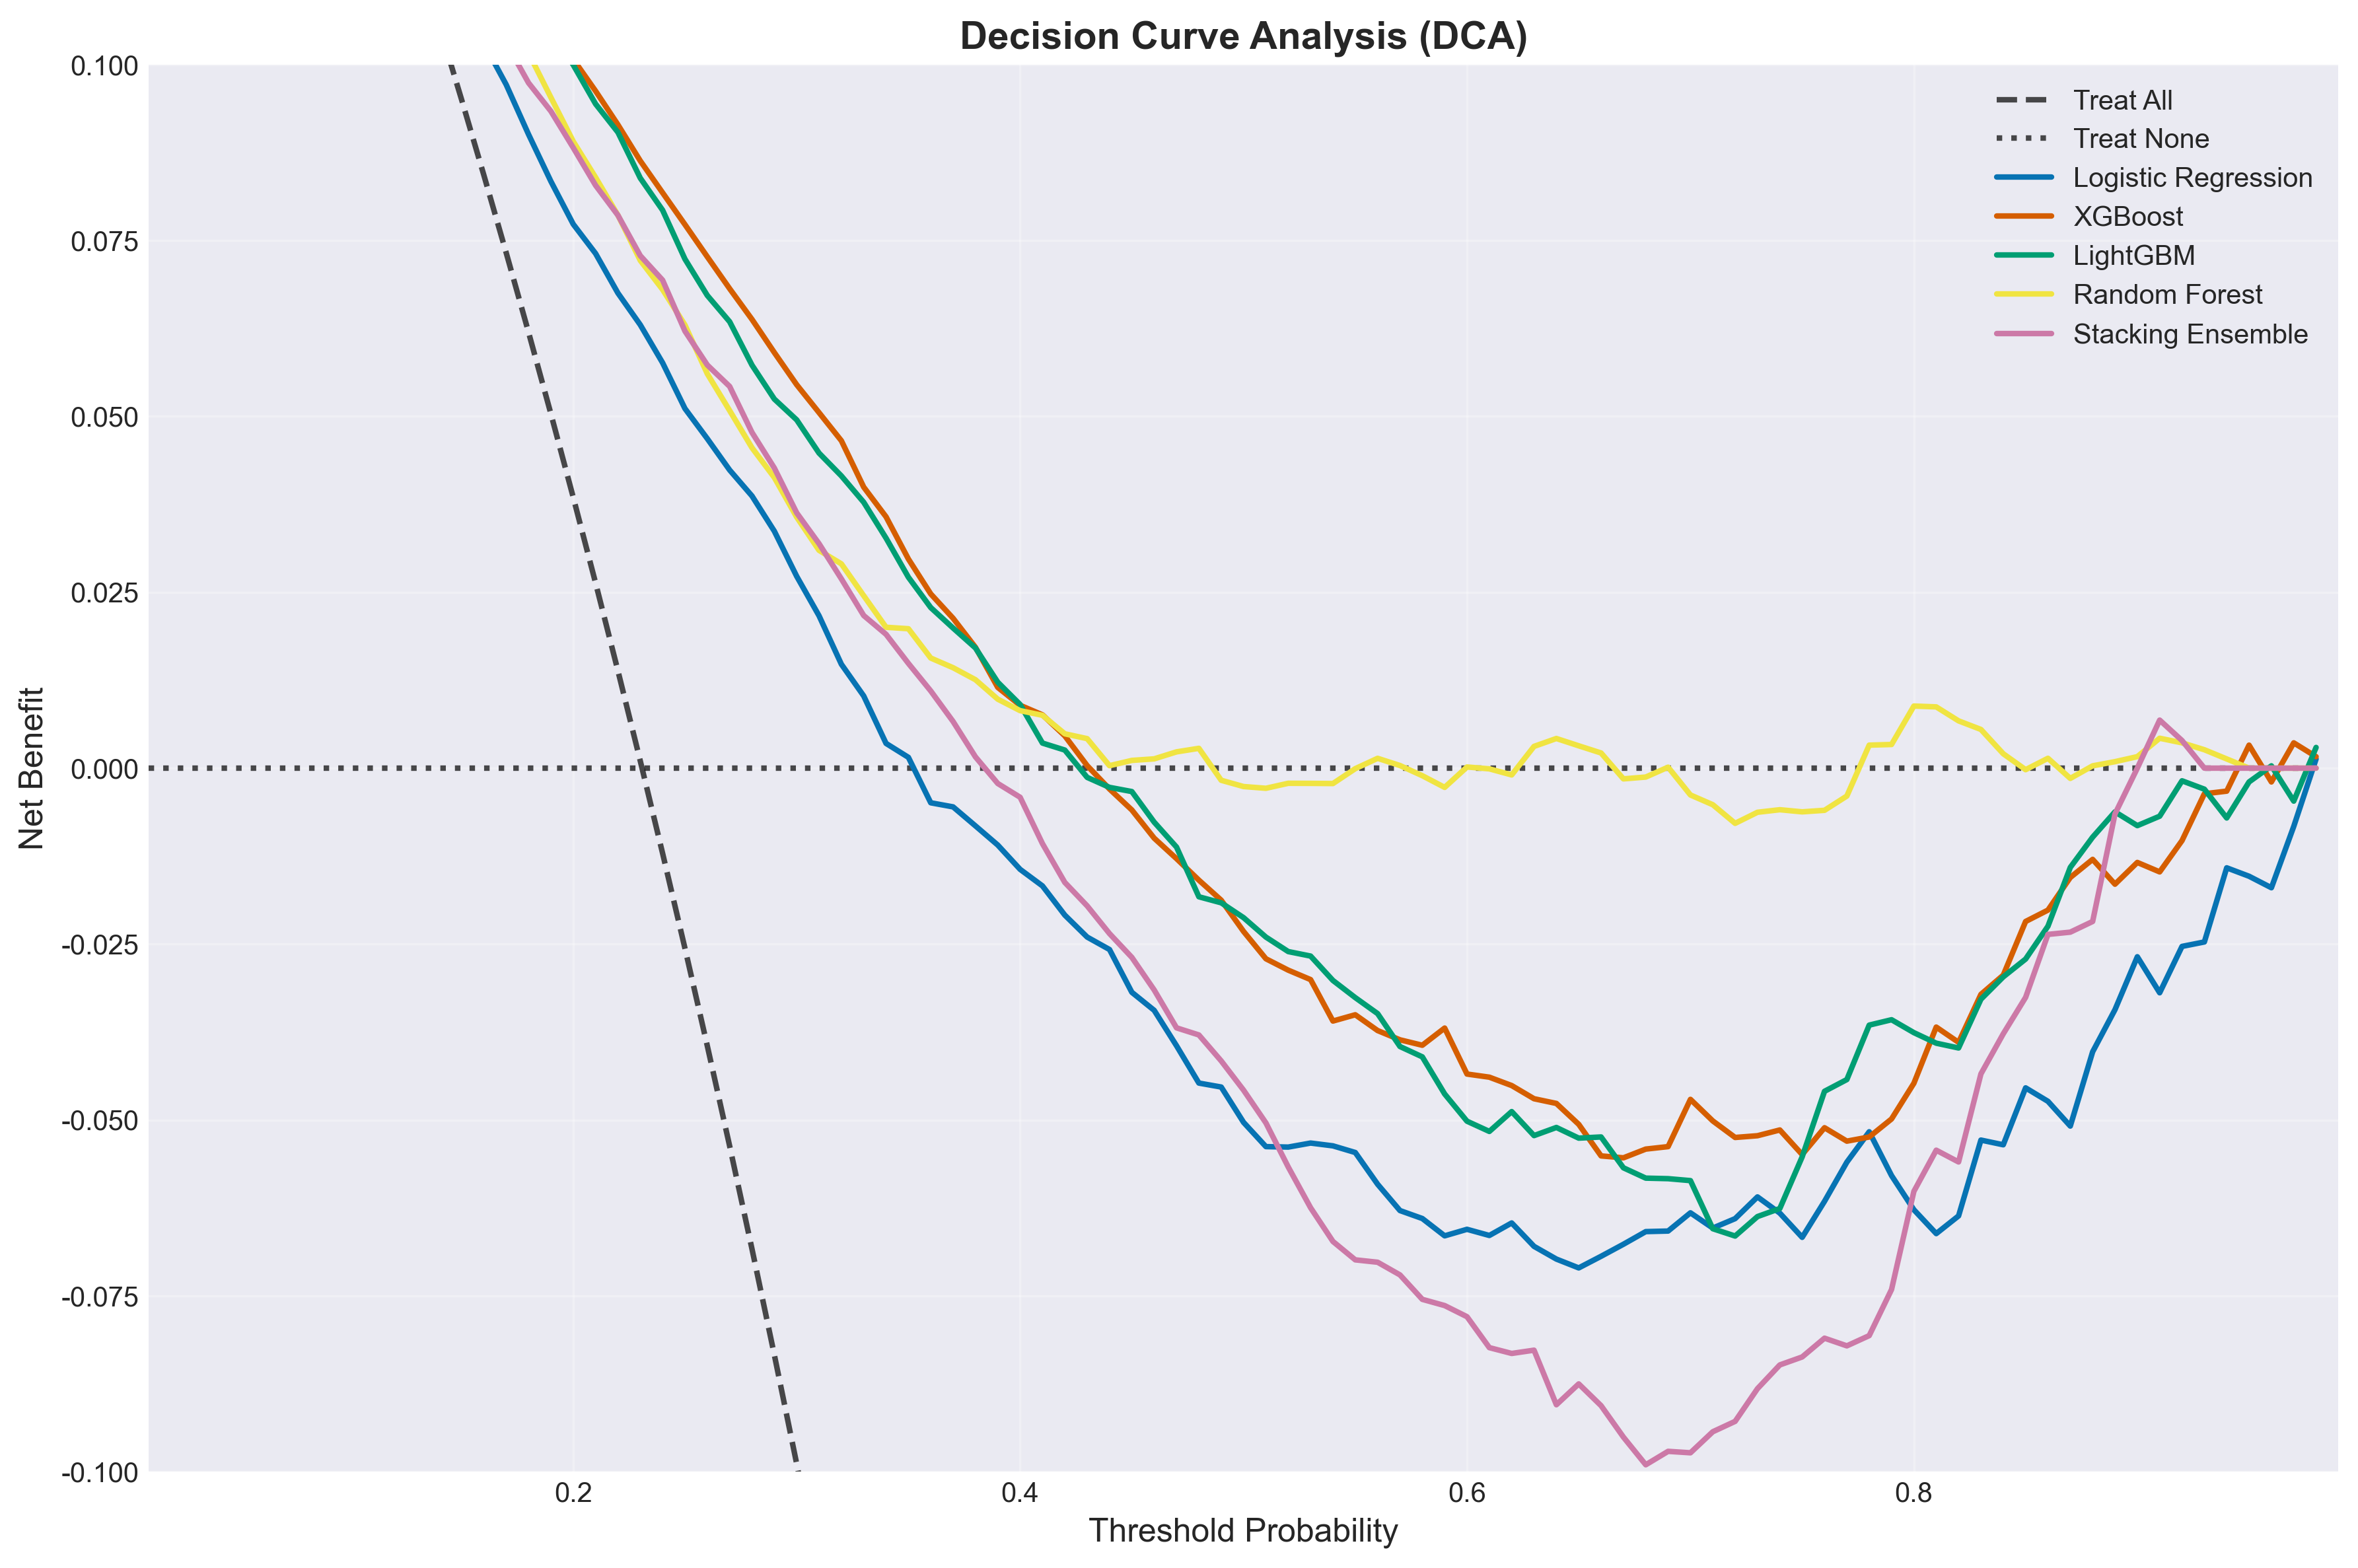

[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/dca_curve.png


In [162]:
print(f"\nGenerating Decision Curve Analysis (DCA)...")

dca_output_path = OUTPUT_PATHS['visualizations'] / 'dca_curve.png'
plot_dca_curve(models_dict, y_test, dca_output_path)   # function generates & saves

display(Image(filename=str(dca_output_path)))

print(f"[OK] Saved: {dca_output_path}")

### 4. Generate specific confusion matrices and DCA curves for requested models and thresholds


Generating specific confusion matrices and DCA curves (2x3 panel)...
--------------------------------------------------------------------------------
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/confusion_matrix_stacking_ensemble_thresh_0.35.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/confusion_matrix_stacking_ensemble_thresh_0.29.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/dca_curve_stacking_ensemble.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/confusion_matrix_xgboost_thresh_0.22.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/confusion_matrix_xgboost_thresh_0.27.png
[OK] Saved: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/dca_curve_xgboost.png

[OK] Saved 2x3 panel: /Users/zixuanhe/Desktop/ML4H/Final_code/output/visualizations/modeling/panel_confusion_DCA

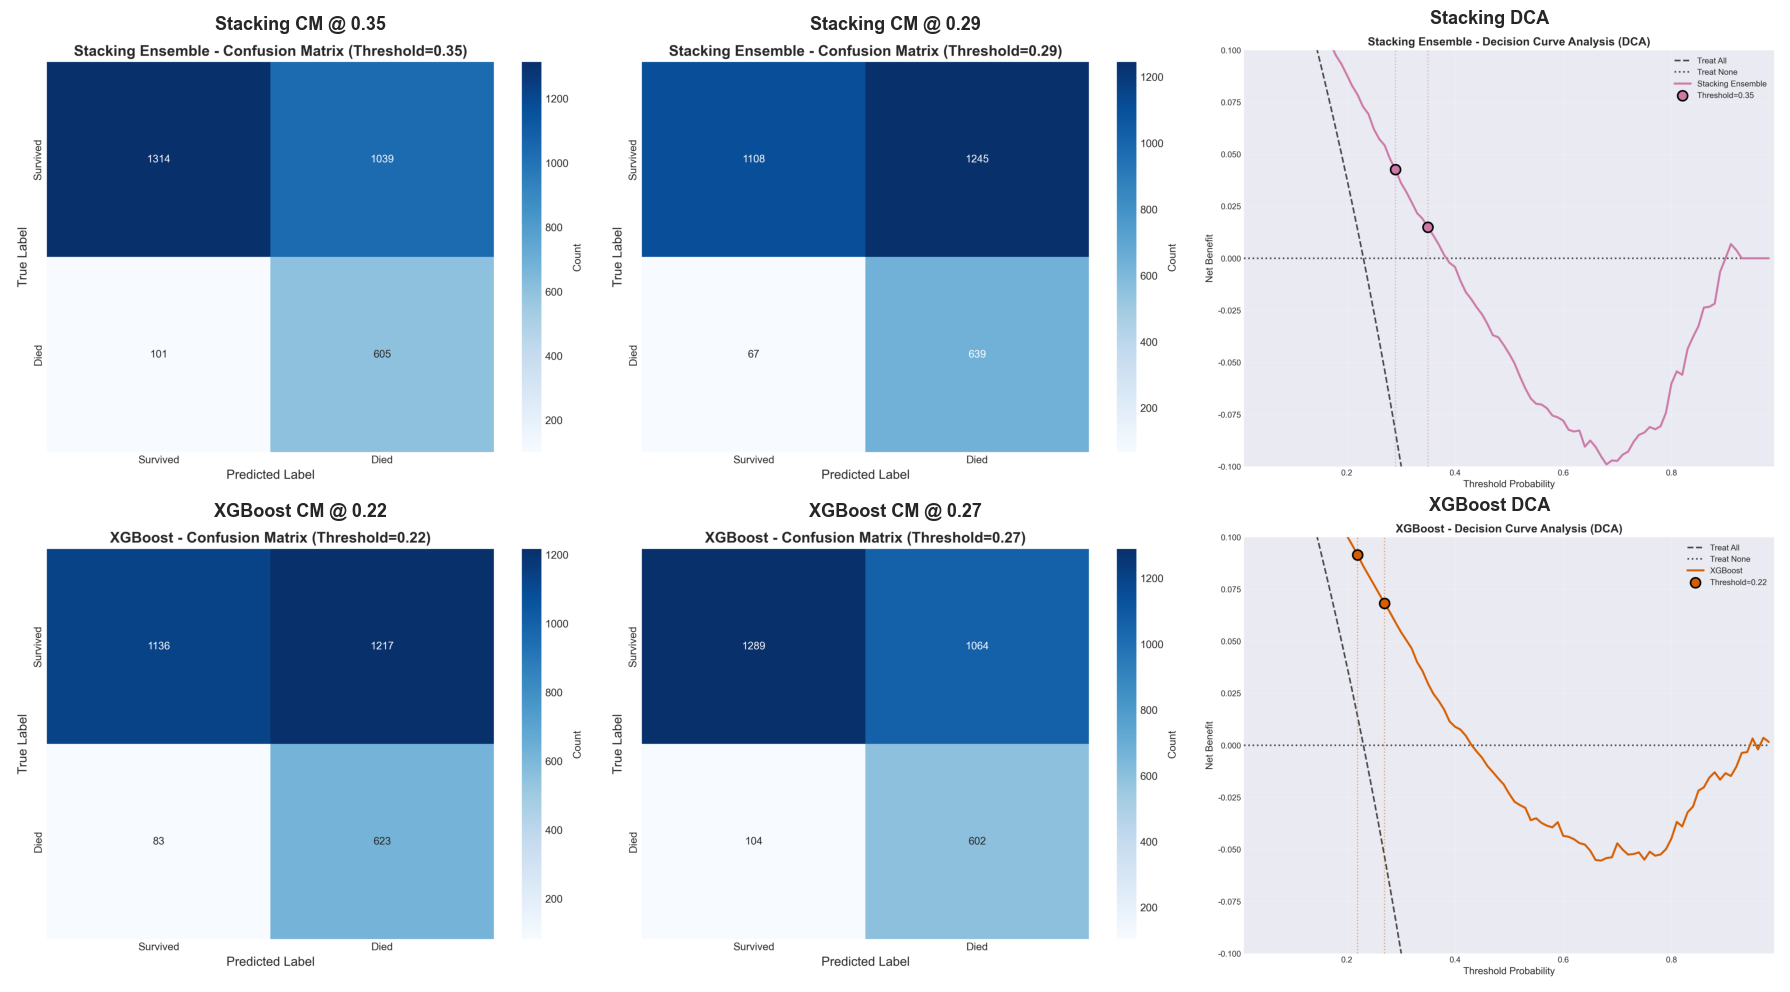

In [178]:
print(f"\nGenerating specific confusion matrices and DCA curves (2x3 panel)...")
print("-" * 80)

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

panel_items = []  # [(title, path), ...]

# -------------------------------------------------------------
# 1) Generate confusion matrices and DCA for Stacking Ensemble
# -------------------------------------------------------------
if 'Stacking Ensemble' in models_for_evaluation:
    stacking_data = models_for_evaluation['Stacking Ensemble']
    stacking_thresholds = [0.35, 0.29]
    
    for thresh in stacking_thresholds:
        y_pred = (stacking_data['y_proba'] >= thresh).astype(int)
        output_path = OUTPUT_PATHS['visualizations'] / f'confusion_matrix_stacking_ensemble_thresh_{thresh:.2f}.png'
        plot_confusion_matrix(
            stacking_data['y_test'],
            y_pred,
            'Stacking Ensemble',
            thresh,
            output_path
        )
        print(f"[OK] Saved: {output_path}")
        panel_items.append((f"Stacking CM @ {thresh:.2f}", output_path))
    
    # DCA curve (highlighting thresholds)
    dca_stacking_path = OUTPUT_PATHS['visualizations'] / 'dca_curve_stacking_ensemble.png'
    plot_single_model_dca(
        stacking_data['y_test'],
        stacking_data['y_proba'],
        'Stacking Ensemble',
        dca_stacking_path,
        highlight_thresholds=stacking_thresholds
    )
    print(f"[OK] Saved: {dca_stacking_path}")
    panel_items.append(("Stacking DCA", dca_stacking_path))


# -------------------------------------------------------------
# 2) Generate confusion matrices and DCA for XGBoost
# -------------------------------------------------------------
if 'XGBoost' in models_for_evaluation:
    xgb_data = models_for_evaluation['XGBoost']
    xgb_thresholds = [0.22, 0.27]

    for thresh in xgb_thresholds:
        y_pred = (xgb_data['y_proba'] >= thresh).astype(int)
        output_path = OUTPUT_PATHS['visualizations'] / f'confusion_matrix_xgboost_thresh_{thresh:.2f}.png'
        plot_confusion_matrix(
            xgb_data['y_test'],
            y_pred,
            'XGBoost',
            thresh,
            output_path
        )
        print(f"[OK] Saved: {output_path}")
        panel_items.append((f"XGBoost CM @ {thresh:.2f}", output_path))

    # DCA curve (highlighting thresholds)
    dca_xgb_path = OUTPUT_PATHS['visualizations'] / 'dca_curve_xgboost.png'
    plot_single_model_dca(
        xgb_data['y_test'],
        xgb_data['y_proba'],
        'XGBoost',
        dca_xgb_path,
        highlight_thresholds=xgb_thresholds
    )
    print(f"[OK] Saved: {dca_xgb_path}")
    panel_items.append(("XGBoost DCA", dca_xgb_path))


# -------------------------------------------------------------
# 3) Assemble into ONE 2x3 panel
# -------------------------------------------------------------
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.ravel()

for i in range(rows * cols):
    ax = axes[i]
    if i < len(panel_items):
        title, path = panel_items[i]
        path = Path(path)
        if path.exists():
            img = mpimg.imread(path)
            ax.imshow(img)
            ax.set_title(title, fontsize=13, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f"Missing: {path.name}", ha='center', va='center')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
panel_path = OUTPUT_PATHS['visualizations'] / 'panel_confusion_DCA_2x3.png'
plt.savefig(panel_path, dpi=300, bbox_inches='tight')
print(f"\n[OK] Saved 2x3 panel: {panel_path}")

print("\n" + "=" * 80)
print("[COMPLETE] Confusion matrices and DCA curves merged into a single 2x3 panel!")
print("=" * 80)